In [ ]:

# -*- coding: utf-8 -*-
# Standalone MNIST deblurring likelihood in PCA space
# Returns (X, loglik, grad_loglik) for all N PCA coefficient vectors.
# Designed to be run in a single Google Colab cell.

import numpy as np
from sklearn.decomposition import PCA
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# ----------------------------
# Utilities
# ----------------------------

def load_mnist_flat(n_samples: int, split: str = 'train', batch_size: int = 2048, seed: int = 0):
    """
    Load MNIST images and return a numpy array of shape (n_samples, 784) in [0,1].
    """
    assert split in ('train', 'test')
    rng = np.random.default_rng(seed)

    ds = datasets.MNIST(
        root="./data",
        train=(split=='train'),
        download=True,
        transform=transforms.ToTensor(), # returns CxHxW in [0,1]
    )
    # Randomly sample n_samples (without replacement if enough)
    indices = np.arange(len(ds))
    rng.shuffle(indices)
    pick = indices[:n_samples]
    subset = torch.utils.data.Subset(ds, pick)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=2)

    X = []
    for batch, _ in loader:
        # batch: [B, 1, 28, 28]
        X.append(batch.squeeze(1).numpy().reshape(batch.shape[0], -1))
    X = np.concatenate(X, axis=0).astype(np.float32)  # (n_samples, 784)
    return X

def make_gaussian_kernel_fft(h: int, w: int, sigma_pix: float):
    """
    Build a 2D Gaussian blur kernel (centered), roll to (0,0) for FFT convolution,
    return its FFT (for circular convolution). Kernel sums to 1.
    """
    yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    cy, cx = h//2, w//2
    g = np.exp(-0.5 * (((yy - cy)/sigma_pix)**2 + ((xx - cx)/sigma_pix)**2))
    g /= g.sum()
    # Roll so that the kernel's center is at (0,0) for correct circular conv in FFT
    g = np.roll(g, -cy, axis=0)
    g = np.roll(g, -cx, axis=1)
    G = np.fft.fft2(g)  # (h, w), complex
    return G

def fft_convolve_batch(images: np.ndarray, G_fft: np.ndarray, batch_axes=(1,2)):
    """
    Circular convolution via FFT: conv(image, kernel) where kernel's FFT is G_fft.
    images: (B, H, W), float32
    returns: (B, H, W), float32
    """
    F = np.fft.fft2(images, axes=batch_axes)          # (B,H,W), complex
    Y = F * G_fft[None, ...]                          # broadcast (B,H,W)
    y = np.fft.ifft2(Y, axes=batch_axes).real.astype(np.float32)
    return y

# ----------------------------
# Core: PCA + likelihood + gradient
# ----------------------------

def fit_pca_basis(train_flat: np.ndarray, n_components: int = 30):
    """
    Fit PCA on flattened images.
    Returns: pca object, X_train (coeffs), components (d, 784), mean (784,)
    """
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False, random_state=0)
    X_train = pca.fit_transform(train_flat)  # (N, d)
    # sklearn shapes:
    # components_: (d, 784), X ≈ (train_flat - mean_) @ components_.T
    return pca, X_train.astype(np.float32), pca.components_.astype(np.float32), pca.mean_.astype(np.float32)

def coeffs_to_images(X: np.ndarray, components: np.ndarray, mean_flat: np.ndarray):
    """
    Inverse PCA: from coeffs X (N,d) to images (N, 28, 28), float32.
    """
    imgs_flat = X @ components + mean_flat[None, :]
    imgs = imgs_flat.reshape(-1, 28, 28).astype(np.float32)
    return imgs

def build_observation_from_test(pca, components, mean_flat, blur_sigma=1.5, noise_sigma=0.05, test_pick=0, seed=0):
    """
    Choose one test image, form observation y_obs = K x_true + noise.
    Returns: y_obs (28,28), x_true (28,28), kernel_fft (28,28), params
    """
    # Load one test image (flattened)
    Xtest = load_mnist_flat(n_samples=test_pick+1, split='test', batch_size=256, seed=seed)
    x_true_flat = Xtest[test_pick]  # (784,)
    x_true = x_true_flat.reshape(28,28).astype(np.float32)
    # Blur kernel FFT
    G = make_gaussian_kernel_fft(28, 28, sigma_pix=blur_sigma)
    # Observation
    y_clean = fft_convolve_batch(x_true[None, ...], G)[0]
    rng = np.random.default_rng(seed)
    y_obs = (y_clean + noise_sigma * rng.standard_normal(y_clean.shape).astype(np.float32)).astype(np.float32)
    return y_obs, x_true, G, {'blur_sigma': blur_sigma, 'noise_sigma': noise_sigma}

def evaluate_deblurring_likelihood_and_grad(
    X: np.ndarray,
    components: np.ndarray,
    mean_flat: np.ndarray,
    y_obs: np.ndarray,
    G_fft: np.ndarray,
    noise_sigma: float,
    batch_size: int = 1024,
):
    """
    Evaluate (log-likelihood, gradient) for the deblurring model:
      y_obs ~ N( K x , noise_sigma^2 I ),  K = Gaussian blur (circular FFT conv)
    Gradient of log p(y|x) w.r.t. image x:  (K^T (y_obs - Kx)) / noise_sigma^2
    Since K is symmetric for Gaussian blur, K^T = K.

    We return:
      loglik: shape (N,), unnormalized log-likelihood (up to constant)
      grad_loglik: shape (N, d), gradient w.r.t. PCA coefficients (not image pixels)
    """
    N, d = X.shape
    H = W = 28
    loglik = np.empty(N, dtype=np.float32)
    grad_coeffs = np.empty((N, d), dtype=np.float32)

    # Precompute for speed
    # components: (d, 784); to map grad_image_flat -> grad_coeffs: grad_coeffs = grad_img_flat @ components.T
    comp_T = components.T.astype(np.float32)  # (784, d)

    y_obs = y_obs.astype(np.float32)
    y_obs_batch = np.broadcast_to(y_obs[None, ...], (1, H, W))

    inv_var = 1.0 / (noise_sigma**2)

    for i0 in range(0, N, batch_size):
        i1 = min(i0 + batch_size, N)
        Xb = X[i0:i1]                                  # (B, d)
        imgs = coeffs_to_images(Xb, components, mean_flat)   # (B, H, W)

        # Forward model: y_hat = K x
        y_hat = fft_convolve_batch(imgs, G_fft)        # (B, H, W)
        resid = (y_obs_batch - y_hat)                  # (B, H, W)

        # Unnormalized log-likelihood: -0.5/σ² * ||y_obs - Kx||²
        se = (resid**2).reshape(resid.shape[0], -1).sum(axis=1)  # (B,)
        loglik[i0:i1] = (-0.5 * inv_var * se).astype(np.float32)

        # Image-space gradient: K^T (y_obs - Kx) / σ² ; K^T = K for symmetric Gaussian blur
        grad_img = fft_convolve_batch(resid, G_fft) * inv_var  # (B, H, W)

        # Map to coefficient space via Jacobian: x = X @ components + mean  =>  ∂x/∂X = components
        grad_img_flat = grad_img.reshape(grad_img.shape[0], -1)   # (B, 784)
        grad_c = grad_img_flat @ comp_T                           # (B, d)
        grad_coeffs[i0:i1] = grad_c.astype(np.float32)

    return loglik, grad_coeffs

# ----------------------------
# Orchestrator
# ----------------------------

def prepare_mnist_pca_and_likelihood(
    N_train: int = 10_000,
    n_components: int = 30,
    blur_sigma: float = 1.5,
    noise_sigma: float = 0.05,
    seed: int = 0,
    batch_size_fft: int = 1024,
):
    """
    Main function:
      1) Load N_train MNIST training images and fit PCA(n_components).
      2) Return X = PCA coefficients (N_train, n_components).
      3) Build a single observed test image y_obs via blur+noise.
      4) Evaluate (loglik, grad_loglik) for all rows of X wrt y_obs.
    Returns:
      (X, loglik, grad_loglik)
    """
    # 1) Load train set, fit PCA
    train_flat = load_mnist_flat(n_samples=N_train, split='train', seed=seed)
    pca, X, components, mean_flat = fit_pca_basis(train_flat, n_components=n_components)

    # 2) Build an observation from test set
    y_obs, x_true, G_fft, meta = build_observation_from_test(
        pca, components, mean_flat, blur_sigma=blur_sigma, noise_sigma=noise_sigma, test_pick=0, seed=seed
    )

    # 3) Likelihood + gradient for all X
    loglik, grad_loglik = evaluate_deblurring_likelihood_and_grad(
        X=X,
        components=components,
        mean_flat=mean_flat,
        y_obs=y_obs,
        G_fft=G_fft,
        noise_sigma=noise_sigma,
        batch_size=batch_size_fft,
    )

    # For convenience, also return the observation/metadata if you want to reuse them downstream
    extras = {
        'pca': pca,
        'components': components,
        'mean_flat': mean_flat,
        'y_obs': y_obs,
        'x_true': x_true,
        'kernel_fft': G_fft,
        'meta': meta,
    }
    return (X, loglik, grad_loglik), extras

In [ ]:
from re import S
from ctypes import create_unicode_buffer
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
import math
from itertools import combinations

from math import ceil
from functools import partial
from sklearn.decomposition import PCA



# ----------------------------------------------
# Multi-scale MMD divergence
# ----------------------------------------------

try:
    import cupy as cp
except Exception:
    cp = None
import numpy as np

M_MMD_DEFAULTS = {
    # kernel mixture
    "kernel": "rbf",        # 'rbf' or 'imq'
    "scales": None,         # list/array of bandwidths (RBF sigmas or IMQ c's). If None, use median heuristic.
    "scale_weights": None,  # list/array of nonnegative weights (same length as scales). If None, uniform.
    # median heuristic for automatic scales (used if scales=None)
    "use_median_heuristic": True,
    "num_scales": 5,        # number of scales in the mixture
    "scale_min": 0.5,       # lower multiplier relative to base (logspace)
    "scale_max": 2.0,       # upper multiplier relative to base (logspace)
    # estimator & output
    "unbiased": True,       # U-statistic (exclude diagonals in Kxx, Kyy)
    "squared": False,       # return MMD^2 if True, else sqrt(max(MMD^2,0))
    # kernel-specific params
    "imq_beta": 0.5,        # k_IMQ(d2) = (1 + d2 / c^2)^(-beta)
    # numerics
    "chunk_size": 4096,     # process pairwise blocks to limit memory
    "return_per_scale": False, # if True, also return dict with per-scale contributions
    # optional per-sample weights (length N_x / N_y). If provided, computes *weighted* MMD.
    "x_weights": None,
    "y_weights": None,
}

def _xp_of(arr):
    """Return array module (np or cp) that matches arr."""
    if cp is not None and isinstance(arr, cp.ndarray):
        return cp
    return np

def _as_xp(x, xp):
    """Ensure x is an xp array."""
    if xp is np:
        return np.asarray(x)
    else:
        return x if isinstance(x, xp.ndarray) else xp.asarray(x)

def _median_pairwise_sqdist(Z, xp, max_samples=1024):
    """Robust median of pairwise squared distances from a subsample."""
    n = Z.shape[0]
    if n <= 1:
        return xp.array(1.0, dtype=Z.dtype)
    idx = xp.random.permutation(n)[:min(n, max_samples)]
    S = Z[idx]
    # pairwise squared distances for the subsample
    S2 = xp.sum(S * S, axis=1, keepdims=True)
    D2 = xp.maximum(S2 + S2.T - 2 * (S @ S.T), 0.0)
    # exclude zeros on the diagonal
    tri = D2[~xp.eye(D2.shape[0], dtype=bool)]
    if tri.size == 0:
        return xp.array(1.0, dtype=Z.dtype)
    return xp.median(tri)

def _kernel_from_d2(d2, kernel, scale, xp, beta):
    """Evaluate kernel from squared distances."""
    if kernel == "rbf":
        # k(d2) = exp(- d2 / (2 sigma^2))
        inv2sig2 = 1.0 / (2.0 * (scale ** 2))
        return xp.exp(-d2 * inv2sig2)
    elif kernel == "imq":
        # k(d2) = (1 + d2 / c^2)^(-beta)
        return (1.0 + d2 / (scale ** 2)) ** (-beta)
    else:
        raise ValueError(f"Unknown kernel '{kernel}' (use 'rbf' or 'imq').")

def _sum_kernel_pairs_XY(X, Y, scales, weights, kernel, xp, beta, chunk, xw=None, yw=None):
    """
    Sum over k(x_i, y_j) for all i,j across a *mixture* of kernels.
    Returns per-scale sums as array [S] and normalization constant (weighted).
    """
    nx, ny = X.shape[0], Y.shape[0]
    S = xp.zeros((len(scales),), dtype=X.dtype)
    # normalization (weighted or unweighted)
    if xw is None and yw is None:
        norm = float(nx) * float(ny)
    else:
        xw = xp.ones(nx, dtype=X.dtype) if xw is None else xw
        yw = xp.ones(ny, dtype=Y.dtype) if yw is None else yw
        norm = float(xp.sum(xw) * xp.sum(yw))

    for i0 in range(0, nx, chunk):
        Xi = X[i0:i0 + chunk]
        # precompute norms for distance
        Xi2 = xp.sum(Xi * Xi, axis=1, keepdims=True)  # (bi,1)
        wi = None if xw is None else xw[i0:i0 + chunk]
        for j0 in range(0, ny, chunk):
            Yj = Y[j0:j0 + chunk]
            Yj2 = xp.sum(Yj * Yj, axis=1, keepdims=True)  # (bj,1)
            # (bi,bj) squared distances
            D2 = xp.maximum(Xi2 + Yj2.T - 2.0 * (Xi @ Yj.T), 0.0)
            # stack per-scale kernels with broadcasting: (S, bi, bj)
            Ks = xp.stack([_kernel_from_d2(D2, kernel, s, xp, beta) for s in scales], axis=0)
            if xw is None and yw is None:
                S += Ks.sum(axis=(1, 2))
            else:
                wj = yw[j0:j0 + chunk]
                W = (wi[:, None] * wj[None, :])  # (bi,bj)
                S += xp.tensordot(Ks, W, axes=((1, 2), (0, 1)))  # sum_{bi,bj} Ks[...,bi,bj]*W[bi,bj]
    # apply mixture weights here (leave per-scale sums unweighted for diagnostics)
    if weights is not None:
        total = float(xp.sum(weights * (S / norm)))
    else:
        total = float(xp.sum(S / norm))
    return S, norm, total

def _sum_kernel_pairs_XX(A, scales, weights, kernel, xp, beta, chunk, unbiased=True, aw=None):
    """
    Sum over k(a_i, a_j) across a *mixture* of kernels for a single set A.
    Returns per-scale sums as array [S] and normalization constant (weighted).
    For unbiased=True, excludes diagonals (i != j) using ordered-pairs normalization n(n-1).
    """
    n = A.shape[0]
    S = xp.zeros((len(scales),), dtype=A.dtype)

    if aw is None:
        if unbiased:
            norm = float(n) * float(max(n - 1, 1))
        else:
            norm = float(n) * float(n)
    else:
        aw = aw.astype(A.dtype, copy=False)
        s1 = xp.sum(aw)
        if unbiased:
            norm = float(s1 * s1 - xp.sum(aw * aw))
        else:
            norm = float(s1 * s1)

    for i0 in range(0, n, chunk):
        Ai = A[i0:i0 + chunk]
        Ai2 = xp.sum(Ai * Ai, axis=1, keepdims=True)
        wi = None if aw is None else aw[i0:i0 + chunk]
        j_start = i0  # upper blocks including diagonal
        for j0 in range(j_start, n, chunk):
            Aj = A[j0:j0 + chunk]
            Aj2 = xp.sum(Aj * Aj, axis=1, keepdims=True)
            D2 = xp.maximum(Ai2 + Aj2.T - 2.0 * (Ai @ Aj.T), 0.0)
            Ks = xp.stack([_kernel_from_d2(D2, kernel, s, xp, beta) for s in scales], axis=0)  # (S,bi,bj)

            if aw is None:
                if i0 == j0:
                    if unbiased:
                        # subtract diagonals; keep off-diagonals both (i,j) and (j,i) inside the block
                        diag = xp.stack([xp.diag(Ks[k]) for k in range(Ks.shape[0])], axis=0).sum(axis=1)
                        S += Ks.sum(axis=(1, 2)) - diag
                    else:
                        S += Ks.sum(axis=(1, 2))
                else:
                    # off-diagonal blocks contribute both (i,j) and (j,i)
                    S += 2.0 * Ks.sum(axis=(1, 2))
            else:
                wj = aw[j0:j0 + chunk]
                W = (wi[:, None] * wj[None, :])  # (bi,bj)
                if i0 == j0:
                    if unbiased:
                        # zero-out diagonal weights before summing
                        # subtract weighted diagonal: sum_k Ks[k]*W with diag set to 0
                        # Equivalent: total sum minus diag(K)*w^2
                        diag = xp.stack([xp.diag(Ks[k]) for k in range(Ks.shape[0])], axis=0)  # (S, b)
                        diag_w2 = (wi * wi)[None, :] * diag  # (S,b)
                        S += xp.tensordot(Ks, W, axes=((1, 2), (0, 1))) - diag_w2.sum(axis=1)
                    else:
                        S += xp.tensordot(Ks, W, axes=((1, 2), (0, 1)))
                else:
                    # both (i,j) and (j,i) pairs
                    S += 2.0 * xp.tensordot(Ks, W, axes=((1, 2), (0, 1)))
    if weights is not None:
        total = float(xp.sum(weights * (S / norm)))
    else:
        total = float(xp.sum(S / norm))
    return S, norm, total

def M_MMD(X, Y, params=None):
    """
    Multi-scale MMD divergence between sample sets X ~ P and Y ~ Q.

    Args:
        X: (N_x, d) numpy or cupy array.
        Y: (N_y, d) numpy or cupy array.
        params: dict overriding M_MMD_DEFAULTS.
            - kernel: 'rbf' or 'imq'
            - scales: list/array of bandwidths (RBF sigmas or IMQ c's). If None, automatic.
            - scale_weights: list/array (same length as scales). Defaults to uniform.
            - use_median_heuristic: if True and scales=None, set base scale from combined median distance.
                * RBF: base sigma = sqrt(0.5 * median(D^2)), then logspace multipliers [scale_min, scale_max]
                * IMQ: base c = sqrt(median(D^2)), then logspace multipliers
            - num_scales, scale_min, scale_max: for automatic scales (logspace).
            - unbiased: U-statistic (exclude diagonals in within terms).
            - squared: return MMD^2 if True; else return sqrt(max(MMD^2, 0)).
            - imq_beta: exponent for IMQ kernel.
            - chunk_size: block size for memory control.
            - x_weights, y_weights: optional per-sample nonnegative weights.
            - return_per_scale: if True, also returns a dict with per-scale pieces.

    Returns:
        mmd_value (float), and optionally (if return_per_scale) a dict with
        'per_scale_mmd2', 'scales', 'scale_weights'.
    """
    # merge params with defaults
    p = dict(M_MMD_DEFAULTS)
    if params is not None:
        p.update(params)

    # choose backend
    xp = _xp_of(X)
    X = _as_xp(X, xp)
    Y = _as_xp(Y, xp)
    X = X.reshape(X.shape[0], -1)
    Y = Y.reshape(Y.shape[0], -1)

    # weights (optional)
    xw = None if p["x_weights"] is None else _as_xp(p["x_weights"], xp).astype(X.dtype, copy=False)
    yw = None if p["y_weights"] is None else _as_xp(p["y_weights"], xp).astype(Y.dtype, copy=False)

    # build scales & weights
    if p["scales"] is None:
        # base scale from combined median distance
        Z = xp.concatenate([X, Y], axis=0)
        med2 = _median_pairwise_sqdist(Z, xp, max_samples=1024)
        if p["kernel"] == "rbf":
            base = xp.sqrt(xp.maximum(0.5 * med2, 1e-12))
        else:  # imq
            base = xp.sqrt(xp.maximum(med2, 1e-12))
        mul = xp.logspace(np.log10(p["scale_min"]), np.log10(p["scale_max"]), p["num_scales"])
        scales = base * mul
    else:
        scales = _as_xp(p["scales"], xp).astype(X.dtype, copy=False)

    if p["scale_weights"] is None:
        scale_weights = xp.ones((len(scales),), dtype=X.dtype) / float(len(scales))
    else:
        w = _as_xp(p["scale_weights"], xp).astype(X.dtype, copy=False)
        w_sum = xp.sum(w)
        scale_weights = w / (w_sum if float(w_sum) > 0 else 1.0)

    # compute per-set & cross sums, with mixture applied after normalization
    Sxx, nxx, mix_xx = _sum_kernel_pairs_XX(X, scales, scale_weights, p["kernel"], xp,
                                            p["imq_beta"], p["chunk_size"], p["unbiased"], xw)
    Syy, nyy, mix_yy = _sum_kernel_pairs_XX(Y, scales, scale_weights, p["kernel"], xp,
                                            p["imq_beta"], p["chunk_size"], p["unbiased"], yw)
    Sxy, nxy, mix_xy = _sum_kernel_pairs_XY(X, Y, scales, scale_weights, p["kernel"], xp,
                                            p["imq_beta"], p["chunk_size"], xw, yw)

    # Full mixture MMD^2
    mmd2 = (mix_xx + mix_yy - 2.0 * mix_xy)
    # numerical guard
    if mmd2 < 0.0:
        mmd2 = 0.0

    if p["squared"]:
        out = float(mmd2)
    else:
        out = float(np.sqrt(mmd2))  # safe cast; cp scalar ok through numpy sqrt of float

    if p["return_per_scale"]:
        # per-scale contributions *before* mixture weighting, but normalized
        per_scale = (Sxx / nxx) + (Syy / nyy) - 2.0 * (Sxy / nxy)
        # clamp small negatives
        per_scale = xp.maximum(per_scale, 0.0)
        return out, {
            "per_scale_mmd2": _as_xp(per_scale, np),  # move to numpy for easy logging
            "scales": _as_xp(scales, np),
            "scale_weights": _as_xp(scale_weights, np),
        }
    return out



# ------------------------------ Single-σ MMD ----------------------------------
def OT_MMD(X, Y, *, sigma=1.0, unbiased=False, chunk=4096):
    """
    Single-scale RBF MMD between X and Y with bandwidth `sigma`.
    Works with NumPy or CuPy arrays; keeps everything on-device if CuPy.
    """
    # choose xp
    xp = cp if (cp is not None and isinstance(X, cp.ndarray)) or \
               (cp is not None and isinstance(Y, cp.ndarray)) else np
    X = xp.asarray(X, dtype=xp.float64).reshape(X.shape[0], -1)
    Y = xp.asarray(Y, dtype=xp.float64).reshape(Y.shape[0], -1)
    n, m = X.shape[0], Y.shape[0]
    inv2s2 = 1.0 / (2.0 * (float(sigma) ** 2))

    def _rbf_sum(A, B):
        SA = xp.sum(A * A, axis=1, keepdims=True)
        SB = xp.sum(B * B, axis=1, keepdims=True)
        D2 = xp.maximum(SA + SB.T - 2.0 * (A @ B.T), 0.0)
        return xp.exp(-inv2s2 * D2).sum()

    if unbiased:
        # U-statistic: exclude self terms in Kxx, Kyy, normalize by n(n-1), m(m-1)
        # Block to limit memory
        def _self_sum(A):
            s = xp.array(0.0, dtype=xp.float64)
            NA = A.shape[0]
            for i0 in range(0, NA, chunk):
                Ai = A[i0:i0 + chunk]
                Ai2 = xp.sum(Ai * Ai, axis=1, keepdims=True)
                for j0 in range(0, NA, chunk):
                    Aj = A[j0:j0 + chunk]
                    Aj2 = xp.sum(Aj * Aj, axis=1, keepdims=True)
                    D2 = xp.maximum(Ai2 + Aj2.T - 2.0 * (Ai @ Aj.T), 0.0)
                    K = xp.exp(-inv2s2 * D2)
                    if i0 == j0:
                        K = K - xp.eye(K.shape[0], dtype=K.dtype)
                    s += K.sum()
            return s

        s_xx = _self_sum(X) / max(n * (n - 1), 1)
        s_yy = _self_sum(Y) / max(m * (m - 1), 1)

    else:
        # Biased estimator: include diagonals, normalize by n^2, m^2
        s_xx = _rbf_sum(X, X) / max(n * n, 1)
        s_yy = _rbf_sum(Y, Y) / max(m * m, 1)

    s_xy = _rbf_sum(X, Y) / max(n * m, 1)
    mmd2 = float((s_xx + s_yy - 2.0 * s_xy))
    return math.sqrt(mmd2) if mmd2 > 0 else 0.0


import numpy as np

def _pairwise_min_k_dists(A, B, k=1, chunk=2000):
    """
    For each a in A, return distance to k-th NN in B (Euclidean).
    Chunked to stay memory-safe. Returns shape [len(A),].
    """
    nA, nB = A.shape[0], B.shape[0]
    out = np.empty(nA, dtype=np.float64)
    k = max(1, int(k))

    for i in range(0, nA, chunk):
        Ai = A[i:i+chunk]  # [m, d]
        # pairwise squared distances (Ai - B)^2
        # (m,1,d) - (1,nB,d) -> (m,nB,d) -> sum over d -> (m,nB)
        d2 = np.sum((Ai[:, None, :] - B[None, :, :])**2, axis=2)
        # sort small k efficiently
        # np.partition is O(n), returns k smallest unordered; take [:, k-1]
        kth = np.partition(d2, kth=k-1, axis=1)[:, k-1]
        out[i:i+chunk] = np.sqrt(kth)
    return out

def copying_index(gen, train, test, k=1, alphas=(0.9, 0.8), max_pts=8000, chunk=2000):
    """
    Train-vs-Test kNN ratio memorization metric.
    Returns dict with ratio stats and alpha-thresholded fractions.
    Downsamples to max_pts if needed for speed.
    """
    # (Optional) downsample for speed
    if gen.shape[0] > max_pts:
        idx = np.random.permutation(gen.shape[0])[:max_pts]
        gen = gen[idx]
    if train.shape[0] > max_pts:
        idx = np.random.permutation(train.shape[0])[:max_pts]
        train = train[idx]
    if test.shape[0] > max_pts:
        idx = np.random.permutation(test.shape[0])[:max_pts]
        test = test[idx]

    dg_train = _pairwise_min_k_dists(gen, train, k=k, chunk=chunk)
    dg_test  = _pairwise_min_k_dists(gen, test,  k=k, chunk=chunk)

    eps = 1e-12
    ratios = dg_train / (dg_test + eps)  # <1 => closer to TRAIN
    out = {
        "copy_ratio_mean": float(np.mean(ratios)),
        "copy_ratio_median": float(np.median(ratios)),
    }
    for a in alphas:
        out[f"copy_frac_a{str(a).replace('.','')}"] = float(np.mean(ratios < a))
    return out

def duplicate_rate(gen, eps=1e-5, max_pts=10000, chunk=2000):
    """
    Near-duplicate rate inside generated samples (birthday test).
    Fraction of points whose 2nd-NN distance (exclude self) < eps.
    """
    if gen.shape[0] > max_pts:
        idx = np.random.permutation(gen.shape[0])[:max_pts]
        gen = gen[idx]
    # distance to 2nd NN: compute to B=A; the 1st NN is itself at 0
    d2 = []
    for i in range(0, gen.shape[0], chunk):
        Ai = gen[i:i+chunk]
        dist2 = np.sum((Ai[:, None, :] - gen[None, :, :])**2, axis=2)
        # set self-distances to +inf to ignore true diagonal
        rows = np.arange(dist2.shape[0])
        dist2[rows, i + rows] = np.inf
        # take the minimum distance (actual 1st NN excluding self)
        nn1 = np.min(dist2, axis=1)
        d2.append(nn1)
    nn = np.sqrt(np.concatenate(d2, axis=0))
    return float(np.mean(nn < eps))



# Script One, works well, just fits np estimators uses for sampling


def _to_numpy(arr):
    """Return a NumPy view; copy from GPU to CPU if the input is a CuPy array."""
    try:
        import cupy as cp
        if isinstance(arr, cp.ndarray):
            return arr.get()          # move to host
    except ImportError:
        pass                          # no CuPy in this env
    return np.asarray(arr)


def prune_cp_arr(x_cp, p_percent = 1):
    x = cp.asarray(x_cp)
    if x.ndim != 2:
        raise ValueError("expected a 2D CuPy array (N,d)")
    if not (0 <= p_percent <= 100):
        raise ValueError("p_percent must be in [0, 100]")

    N = x.shape[0]
    if N == 0:
        return x, cp.zeros(0, dtype=cp.bool_)

    finite_rows = cp.isfinite(x).all(axis=1)
    idx_finite = cp.where(finite_rows)[0]
    xf = x[finite_rows]
    M = xf.shape[0]

    if M == 0:
        return x[:0], cp.zeros(N, dtype=cp.bool_)

    if p_percent == 0:
        keep_mask = cp.zeros(N, dtype=cp.bool_)
        keep_mask[idx_finite] = True
        return xf, keep_mask
    if p_percent == 100:
        return x[:0], cp.zeros(N, dtype=cp.bool_)

    k = int(cp.ceil(M * (1.0 - p_percent / 100.0)).item())  # rows to keep among finite ones
    if k <= 0:
        return x[:0], cp.zeros(N, dtype=cp.bool_)

    norms = cp.linalg.norm(xf, axis=1)
    keep_local = cp.argpartition(norms, kth=k-1)[:k]  # indices of k smallest norms in xf

    keep_mask = cp.zeros(N, dtype=cp.bool_)
    keep_mask[idx_finite[keep_local]] = True
    return x[keep_mask], keep_mask


import cupy as cp



def sample_gmm_gpu(n_samples, means, stds, weights, *, seed=None):
    xp = cp
    means   = xp.asarray(means,   dtype=xp.float64)
    stds    = xp.asarray(stds,    dtype=xp.float64)
    weights = xp.asarray(weights, dtype=xp.float64).reshape(-1)

    C, D = means.shape
    if stds.ndim == 1 and stds.shape == (C,):
        cov_mode = "isotropic"
    elif stds.ndim == 2 and stds.shape == (C, D):
        cov_mode = "diag"
    elif stds.ndim == 3 and stds.shape == (C, D, D):
        cov_mode = "full"
    else:
        raise ValueError("stds must be (C,), (C,D), or (C,D,D)")

    probs = (weights / float(weights.sum())).ravel()
    rng = xp.random.RandomState(seed) if seed is not None else xp.random
    choices = rng.choice(C, size=int(n_samples), p=cp.asnumpy(probs))
    out = xp.empty((n_samples, D), dtype=xp.float64)

    for i in range(C):
        mask = (choices == i); cnt = int(mask.sum())
        if not cnt: continue
        z = rng.standard_normal((cnt, D), dtype=xp.float64)
        if cov_mode == "isotropic":
            out[mask] = means[i] + z * stds[i]
        elif cov_mode == "diag":
            out[mask] = means[i] + z * stds[i]          # (cnt,D) * (D,)
        else:  # full
            L = xp.linalg.cholesky(stds[i])             # Σ^{1/2}
            out[mask] = means[i] + z @ L.T
    return out



def score_gmm_gpu(x, means, stds, weights, batch_size=4096):
    """
    ∇_x log ∑_c w_c N(x; μ_c, Σ_c)
    stds:
      - (C,)   : isotropic std per comp  (σ_c)          -> Σ_c = σ_c^2 I
      - (C,D)  : diagonal std per comp   (σ_{c,d})      -> Σ_c = diag(σ^2)
      - (C,D,D): full covariance per comp (Σ_c SPD)
    """
    xp = cp
    x       = xp.asarray(x,       dtype=xp.float64)
    means   = xp.asarray(means,   dtype=xp.float64)
    weights = xp.asarray(weights, dtype=xp.float64).reshape(-1)
    stds    = xp.asarray(stds,    dtype=xp.float64)

    N, D = x.shape
    C    = means.shape[0]
    if N == 0:
        return xp.zeros((0, D), dtype=xp.float64)

    const = -0.5 * D * xp.log(2.0 * xp.pi)
    log_w = xp.log(weights + 1e-300)
    out   = xp.zeros_like(x)

    # ----- (1) Isotropic: stds = (C,)
    if stds.ndim == 1:
        inv_vars     = 1.0 / (stds**2)                 # (C,)
        log_det_vars = D * xp.log(stds**2)             # (C,)
        norm_const   = const - 0.5 * log_det_vars      # (C,)

        for i in range(0, N, batch_size):
            xb   = x[i:i+batch_size]                   # (B,D)
            diff = means[None, :, :] - xb[:, None, :]  # (B,C,D)
            quad = (diff**2).sum(axis=-1) * inv_vars[None, :]         # (B,C)

            logp = log_w[None, :] + norm_const[None, :] - 0.5 * quad  # (B,C)
            m    = xp.max(logp, axis=1, keepdims=True)
            resp = xp.exp(logp - m); resp /= resp.sum(axis=1, keepdims=True) + 1e-300

            contrib = (resp[:, :, None] * diff) * inv_vars[None, :, None]   # (B,C,D)
            out[i:i+batch_size] = contrib.sum(axis=1)

        return out

    # ----- (2) Diagonal: stds = (C,D)
    if stds.ndim == 2 and stds.shape[1] == D:
        inv_vars     = 1.0 / (stds**2)                 # (C,D)
        log_det_vars = xp.log(stds**2).sum(axis=1)     # (C,)
        norm_const   = const - 0.5 * log_det_vars      # (C,)

        for i in range(0, N, batch_size):
            xb   = x[i:i+batch_size]                   # (B,D)
            diff = means[None, :, :] - xb[:, None, :]  # (B,C,D)
            quad = ((diff**2) * inv_vars[None, :, :]).sum(axis=-1)          # (B,C)

            logp = log_w[None, :] + norm_const[None, :] - 0.5 * quad        # (B,C)
            m    = xp.max(logp, axis=1, keepdims=True)
            resp = xp.exp(logp - m); resp /= resp.sum(axis=1, keepdims=True) + 1e-300

            contrib = (resp[:, :, None] * diff) * inv_vars[None, :, :]      # (B,C,D)
            out[i:i+batch_size] = contrib.sum(axis=1)

        return out

    # ----- (3) Full: stds = (C,D,D)  (here 'stds' is Σ_c)
    if stds.ndim == 3 and stds.shape[1] == D and stds.shape[2] == D:
        # Cholesky once per component
        Ls      = xp.linalg.cholesky(stds)                                     # (C,D,D), Σ = L L^T
        log_det = 2.0 * xp.log(xp.diagonal(Ls, axis1=1, axis2=2)).sum(axis=1)  # (C,)
        norm_const = const - 0.5 * log_det                                     # (C,)

        for i in range(0, N, batch_size):
            xb    = x[i:i+batch_size]                         # (B,D)
            B     = xb.shape[0]
            logp  = xp.empty((B, C), dtype=xp.float64)
            grads = xp.empty((B, C, D), dtype=xp.float64)

            for c in range(C):
                L = Ls[c]                                      # (D,D)

                # quad term: (x - μ)^T Σ^{-1} (x - μ) = || L^{-1}(x-μ) ||^2
                diff_x = xb - means[c][None, :]                # (B,D)
                v = xp.linalg.solve(L, diff_x.T)               # (D,B)
                quad = xp.sum(v * v, axis=0)                   # (B,)
                logp[:, c] = log_w[c] + norm_const[c] - 0.5 * quad

                # gradient per comp: Σ^{-1}(μ - x) = L^{-T} L^{-1} (μ - x)
                diff_m = means[c][None, :] - xb                # (B,D)
                y = xp.linalg.solve(L, diff_m.T)               # (D,B)
                g = xp.linalg.solve(L.T, y).T                  # (B,D)
                grads[:, c, :] = g

            m    = xp.max(logp, axis=1, keepdims=True)
            resp = xp.exp(logp - m); resp /= resp.sum(axis=1, keepdims=True) + 1e-300

            out[i:i+batch_size] = xp.einsum("bc,bcd->bd", resp, grads)

        return out

    raise ValueError("stds must be (C,), (C,D), or (C,D,D) (the last is full covariances).")




def score_div_gmm(x, means, covs, weights, batch_size=4096):

    xp = cp
    x       = xp.asarray(x, dtype=xp.float64)
    means   = xp.asarray(means, dtype=xp.float64)
    covs    = xp.asarray(covs,  dtype=xp.float64)
    weights = xp.asarray(weights, dtype=xp.float64).reshape(-1)

    N, D = x.shape
    C    = means.shape[0]
    if N == 0:
        return xp.zeros_like(x), xp.zeros((0,), dtype=xp.float64)

    # --- weight normalization & constants
    wsum = xp.sum(weights)
    if not xp.isfinite(wsum) or wsum <= 0:
        raise ValueError("Mixture weights must sum to a positive value.")
    log_w = xp.log(weights / wsum + 1e-300)
    const = -0.5 * D * xp.log(2.0 * xp.pi)

    # --- covariance handling
    kind = None
    if covs.ndim == 1 and covs.shape[0] == C:             # isotropic stds
        kind     = "iso"
        inv_vars = 1.0 / (covs**2)                         # (C,)
        log_det  = D * xp.log(covs**2)                     # (C,)
        trA      = D * inv_vars                            # (C,)
    elif covs.ndim == 2 and covs.shape == (C, D):          # diagonal stds
        kind     = "diag"
        inv_vars = 1.0 / (covs**2)                         # (C,D)
        log_det  = xp.log(covs**2).sum(axis=1)             # (C,)
        trA      = inv_vars.sum(axis=1)                    # (C,)
    elif covs.ndim == 3 and covs.shape[1:] == (D, D):      # full Σ
        kind = "full"
        Ls, log_det, trA = [], xp.empty(C), xp.empty(C)
        I = xp.eye(D, dtype=xp.float64)
        for c in range(C):
            L = xp.linalg.cholesky(covs[c])
            Ls.append(L)
            log_det[c] = 2.0 * xp.sum(xp.log(xp.diag(L)))
            Z = xp.linalg.solve(L, I)                      # L^{-1}
            trA[c] = xp.sum(Z * Z)                         # ||L^{-1}||_F^2 = tr(Σ^{-1})
    else:
        raise ValueError("covs must be (C,), (C,D) with stds, or (C,D,D) with full covariances.")

    # --- outputs
    score = xp.empty_like(x)
    div   = xp.empty((N,), dtype=xp.float64)

    for i in range(0, N, batch_size):
        xb = x[i:i+batch_size]                             # (B,D)
        B  = xb.shape[0]

        # per-component log-densities and a_c = A_c (mu_c - x)
        if kind in ("iso", "diag"):
            diff = means[None, :, :] - xb[:, None, :]      # (B,C,D)
            if kind == "iso":
                quad = (diff**2).sum(-1) * inv_vars[None, :]          # (B,C)
                a    = diff * inv_vars[None, :, None]                  # (B,C,D)
            else:
                quad = ((diff**2) * inv_vars[None, :, :]).sum(-1)      # (B,C)
                a    = diff * inv_vars[None, :, :]                     # (B,C,D)
        else:
            quad = xp.empty((B, C), dtype=xp.float64)
            a    = xp.empty((B, C, D), dtype=xp.float64)
            for c in range(C):
                diff = (means[c][None, :] - xb)                        # (B,D)
                # a_c = Σ_c^{-1} diff via two triangular solves
                z = xp.linalg.solve(Ls[c], diff.T)                     # (D,B)
                u = xp.linalg.solve(Ls[c].T, z)                        # (D,B)
                a_c = u.T                                              # (B,D)
                a[:, c, :] = a_c
                quad[:, c] = xp.sum(diff * a_c, axis=1)                # diff^T Σ^{-1} diff

        log_comp = log_w[None, :] + const - 0.5*log_det[None, :] - 0.5*quad  # (B,C)
        m   = xp.max(log_comp, axis=1, keepdims=True)
        resp = xp.exp(log_comp - m)
        resp /= (resp.sum(axis=1, keepdims=True) + 1e-300)             # (B,C)
        s = xp.sum(resp[:, :, None] * a, axis=1)                        # (B,D)

        a_norm2 = xp.sum(a * a, axis=2)                                 # (B,C)
        s_dot_a = xp.sum(s[:, None, :] * a, axis=2)                     # (B,C)
        div_b   = xp.sum(resp * (a_norm2 - s_dot_a - trA[None, :]), axis=1)  # (B,)

        score[i:i+B] = s
        div[i:i+B]   = div_b

    return score, div


def hyvarinen_to_target(X, score_fn, div_fn, batch_size=65536):
    """
    Hyvärinen-to-target loss: E[ 0.5||s(x)||^2 + div s(x) ].
    `score_fn` returns (N,D), `div_fn` returns (N,).
    """
    xp = cp
    X  = xp.asarray(X, dtype=xp.float64)
    N  = X.shape[0]
    acc = 0.0
    cnt = 0
    for i in range(0, N, int(batch_size)):
        xb = X[i:i+batch_size]
        s  = score_fn(xb)
        dv = div_fn(xb)
        acc += float(xp.mean(0.5 * xp.sum(s*s, axis=1) + dv))
        cnt += 1
    return acc / max(cnt, 1)




def density_gmm_gpu(x, means, stds, weights, mode="absolute", iso_std=1.0, batch_size=4096):
    xp = cp
    x      = x.astype(xp.float64, copy=False)
    means  = means.astype(xp.float64, copy=False)
    stds   = stds.astype(xp.float64, copy=False)
    weights= weights.astype(xp.float64, copy=False)

    N, D = x.shape
    if N == 0:
        return xp.zeros((0,), dtype=xp.float64)

    # Normalize mixture weights safely
    wsum = weights.sum()
    if wsum <= 0:
        raise ValueError("Mixture weights must sum to a positive value.")
    w = weights / wsum
    log_w = xp.log(w + 1e-40)  # [C]

    # Handle variances and normalization constants
    if stds.ndim == 1:
        # Isotropic per-component: Σ_c = (std_c^2) * I
        inv_vars = 1.0 / (stds**2)                 # [C]
        log_det_vars = D * xp.log(stds**2)         # [C]  (since det = (std^2)^D)
    elif stds.ndim == 2 and stds.shape[1] == D:
        # Diagonal per-component: Σ_c = diag(std_{c,1}^2, ..., std_{c,D}^2)
        inv_vars = 1.0 / (stds**2)                 # [C, D]
        log_det_vars = xp.log(stds**2).sum(axis=1) # [C]  (since det = prod_d std_{c,d}^2)
    else:
        raise ValueError("`stds` must have shape (C,) or (C, D).")

    const = -0.5 * D * xp.log(2.0 * xp.pi)         # scalar
    norm_const = const - 0.5 * log_det_vars        # [C]

    out = xp.empty((N,), dtype=xp.float64)

    for i in range(0, N, batch_size):
        xb = x[i:i+batch_size]                     # [B, D]
        diff = xb[:, None, :] - means[None, :, :]  # [B, C, D]

        if inv_vars.ndim == 1:
            # quadratic term = sum_d (diff^2) * (1/std_c^2)
            d2 = (diff**2).sum(axis=-1)            # [B, C]
            quad = d2 * inv_vars[None, :]          # [B, C]
        else:
            # quadratic term = sum_d (diff^2 / std_{c,d}^2)
            quad = ((diff**2) * inv_vars[None, :, :]).sum(axis=-1)  # [B, C]

        # log component densities (including weights)
        log_comp = log_w[None, :] + norm_const[None, :] - 0.5 * quad  # [B, C]

        # log-sum-exp over components for numerical stability
        m = xp.max(log_comp, axis=1, keepdims=True)                   # [B, 1]
        log_mix = xp.squeeze(m, 1) + xp.log(xp.exp(log_comp - m).sum(axis=1))  # [B]

        if mode == "absolute":
            out[i:i+batch_size] = xp.exp(log_mix)                     # p_mix(x)
        elif mode == "relative":
            s2 = float(iso_std) ** 2
            # log phi_iso(x) for N(0, s2 I)
            log_iso = -0.5 * D * xp.log(2.0 * xp.pi * s2) - 0.5 * (xb**2).sum(axis=1) / s2  # [B]
            out[i:i+batch_size] = xp.exp(log_mix - log_iso)           # p_mix(x)/phi_iso(x)
        else:
            raise ValueError("mode must be 'absolute' or 'relative'.")

    return out
import cupy as cp


def get_ou_evolved_gmm_params(t, means0, stds0, w0):
    xp = cp
    means0 = xp.asarray(means0)
    e = xp.exp(-t)
    e2 = e * e

    # Evolved means
    m_t = e * means0

    S0 = xp.asarray(stds0)
    K = means0.shape[0]
    D = means0.shape[1]

    # --- Full covariance cases ---
    if (S0.ndim == 3 and S0.shape[-1] == S0.shape[-2]) or (S0.ndim == 2 and S0.shape[0] == S0.shape[1]):
        # Ensure shape (K, D, D)
        if S0.ndim == 2:  # (D, D) for all components
            S0 = xp.broadcast_to(S0[None, :, :], (K, D, D))
        # Σ_t = e^{-2t} Σ_0 + (1 - e^{-2t}) I
        eye = xp.eye(D, dtype=S0.dtype)[None, :, :]  # (1, D, D)
        Sigma_t = e2 * S0 + (1.0 - e2) * eye
        return m_t, Sigma_t, w0

    # --- Diagonal / isotropic std cases ---
    # Treat S0 as stds; compute variances elementwise with broadcasting
    v0 = S0 * S0
    v_t = e2 * v0 + (1.0 - e2)  # adds isotropic I term
    std_t = xp.sqrt(v_t)
    return m_t, std_t, w0


def OU_evolve_samples(y_cp, t_scalar):
    import cupy as cp
    y = cp.asarray(y_cp)
    t = float(t_scalar)
    et = cp.exp(-t)
    sigma = cp.sqrt(cp.maximum(1.0 - et*et, 0.0))
    z = cp.random.standard_normal(y.shape, dtype=y.dtype)
    return et * y + sigma * z


def samples_to_sampler(samples):
    samples = np.asarray(samples)
    N = samples.shape[0]
    def sampler(n):
        if n <= N:
            return samples[:n].copy()
        k = n // N; r = n % N
        out = [samples for _ in range(k)]
        if r: out.append(samples[:r])
        return np.concatenate(out, axis=0).copy()
    return sampler


import numpy as np
try:
    import cupy as cp
except Exception:
    cp = None

import numpy as np
try:
    import cupy as cp
except Exception:
    cp = None



def normalize_gmm_params(means, stds, weights, *, mode="global", eps=1e-12):
    """
    Center & scale a GMM so the mixture mean is 0 and the marginal variance is 1.

    Inputs
    ------
    means   : (C, D)
    stds    : (C,)  or (C, D)     # isotropic or diagonal per component (std, not var)
    weights : (C,)
    mode    : "global" -> one scalar scale s so average marginal variance == 1
              "per_dim" -> vector scale s_d so EACH marginal variance == 1

    Returns
    -------
    means_n : (C, D)
    stds_n  : (C,)  if input was (C,) and mode="global"
              (C,D) if mode="per_dim" or input was (C,D)
    weights_n : (C,)   (re-normalized to sum to 1)
    """
    # pick backend
    try:
        import cupy as cp
        xp = cp if isinstance(means, cp.ndarray) else __import__("numpy")
    except Exception:
        import numpy as np
        xp = np

    m = xp.asarray(means,   dtype=xp.float64)
    s = xp.asarray(stds,    dtype=xp.float64)
    w = xp.asarray(weights, dtype=xp.float64)

    # normalize weights
    w = xp.clip(w, 0, xp.inf)
    ws = w.sum()
    if not xp.isfinite(ws) or ws <= 0:
        raise ValueError("weights must sum to a positive value.")
    w = w / ws

    C, D = m.shape

    # per-dimension variance contributions
    if s.ndim == 1:          # isotropic per component
        var_terms = (s**2)[:, None]                # (C,1) -> broadcast to (C,D)
    elif s.ndim == 2 and s.shape[1] == D:
        var_terms = s**2                            # (C,D)
    else:
        raise ValueError("stds must have shape (C,) or (C,D).")

    # mixture stats
    mu_mix  = w @ m                                  # (D,)
    Ex2     = (w[:, None] * (var_terms + m**2)).sum(axis=0)  # (D,)
    var_mix = xp.maximum(Ex2 - mu_mix**2, eps)       # (D,)

    if mode == "global":
        scale = xp.sqrt(var_mix.mean())              # scalar s
        m_n = (m - mu_mix[None, :]) / scale
        s_n = s / scale                              # keeps shape of s
    elif mode == "per_dim":
        scale = xp.sqrt(var_mix)                     # (D,)
        m_n = (m - mu_mix[None, :]) / scale[None, :]
        if s.ndim == 1:
            s_n = s[:, None] / scale[None, :]        # becomes diagonal (C,D)
        else:
            s_n = s / scale[None, :]
    else:
        raise ValueError('mode must be "global" or "per_dim".')

    return (m_n.astype(means.dtype, copy=False),
            s_n.astype(stds.dtype,  copy=False),
            w.astype(weights.dtype, copy=False))




def get_gmm_funcs(
    num_c: int = 200,
    k_dim: int = 5,
    variant: str = "helix",
    comp_std: float = 0.10,
    overall_scale: float = 1.0,
    rs=None,
    m_dim: int = 3,
    powerlaw_weights: bool = True,
    seed: int = 0,
    stds_specified = None,
    weights_specified = None,
    preset_params = None,
    normalize = False,
    size = 1,
    embedding_mode: str = "linear"  # NEW
):
    # ---- RNG (seeded if requested) -----------------------------------------
    if rs is not None and not isinstance(rs, np.random.RandomState):
        raise TypeError("rs must be a numpy.random.RandomState")
    rng = rs if rs is not None else (np.random.RandomState(seed) if seed is not None
                                     else np.random.RandomState())

    xp = cp
    m_embed = m_dim  # intrinsic dimension placeholder; updated by some variants

    # -------------------------- helpers (NEW) -------------------------------
    def _qr_tall(k, m):
        """Q in R^{k×m} with orthonormal columns (k >= m)."""
        Q, _ = np.linalg.qr(rng.randn(k, m))
        return Q[:, :m]

    def _qr_wide(m, k):
        """A in R^{m×k} with orthonormal columns (k <= m)."""
        G = rng.randn(m, k)
        # Orthonormalize columns of G via SVD
        U, _, Vt = np.linalg.svd(G, full_matrices=False)
        return (U @ Vt)  # shape (m×k), columns orthonormal

    def _orthonormal_complement(Q, k, s):
        """Given Q (k×m) with orthonormal cols, return Q_perp (k×s) orthonormal & Q^T Q_perp = 0."""
        if s <= 0:
            return None
        G = rng.randn(k, s)
        G = G - Q @ (Q.T @ G)
        Qp, _ = np.linalg.qr(G)
        return Qp[:, :s]

    def _embed_linear(X_intr):
        # Preserve original behavior (branch uses m_dim, not m_embed)
        if k_dim > m_dim:
            Q = _qr_tall(k_dim, X_intr.shape[1])  # k×m_embed
            Z = X_intr @ Q.T                      # num_c×k
            covs = np.array([ (comp_std**2) * (Q @ Q.T) + (1e-4*comp_std)**2*np.eye(k_dim)
                              for _ in range(num_c) ])
        else:
            Z = X_intr[:, :k_dim]
            covs = np.array([ (comp_std**2) * np.eye(k_dim) for _ in range(num_c) ])
        return Z, covs

    def _embed_sine_wiggle(X_intr, amp=0.25, freq=1.0):
        m = X_intr.shape[1]
        # base linear map into k-dim
        if k_dim >= m:
            Q = _qr_tall(k_dim, m)               # k×m
            Zlin = X_intr @ Q.T                  # num_c×k
            # add wiggle in orthogonal directions
            s = min(max(1, m), max(0, k_dim - m))
            Q_perp = _orthonormal_complement(Q, k_dim, s)
            if Q_perp is not None:
                R = rng.randn(s, m) * freq
                b = rng.uniform(0.0, 2*np.pi, size=(s,))
                H = np.sin(X_intr @ R.T + b)     # num_c×s
                Zwig = H @ Q_perp.T              # num_c×k
                Z = Zlin + amp * Zwig
            else:
                Z = Zlin
        else:
            # reduce then wiggle using internal orthonormal columns
            A = _qr_wide(m, k_dim)               # m×k
            Zlin = X_intr @ A                    # num_c×k
            # small nonlinear bump inside the current k-subspace
            R = rng.randn(k_dim, m) * freq
            b = rng.uniform(0.0, 2*np.pi, size=(k_dim,))
            H = np.sin(X_intr @ R.T + b)         # num_c×k
            Z = Zlin + amp * H
        covs = np.array([ (comp_std**2) * np.eye(k_dim) for _ in range(num_c) ])
        return Z, covs

    def _embed_rff(X_intr, freq=1.0):
        m = X_intr.shape[1]
        M = max(1, k_dim // 2)
        W = rng.randn(M, m) * freq
        b = rng.uniform(0.0, 2*np.pi, size=(M,))
        C = np.cos(X_intr @ W.T + b)
        S = np.sin(X_intr @ W.T + b)
        Z = np.concatenate([C, S], axis=1)
        if Z.shape[1] < k_dim:
            pad = X_intr @ rng.randn(m, k_dim - Z.shape[1])
            Z = np.concatenate([Z, pad], axis=1)
        else:
            Z = Z[:, :k_dim]
        covs = np.array([ (comp_std**2) * np.eye(k_dim) for _ in range(num_c) ])
        return Z, covs

    def _embed_radial(X_intr):
        r = np.linalg.norm(X_intr, axis=1, keepdims=True)
        feats = [X_intr, r, r**2, np.sin(r), np.cos(r)]
        Z = np.concatenate(feats, axis=1)
        while Z.shape[1] < k_dim:
            w = rng.randn(X_intr.shape[1])
            Z = np.hstack([Z, (X_intr @ w[:, None])**2])
        Z = Z[:, :k_dim]
        covs = np.array([ (comp_std**2) * np.eye(k_dim) for _ in range(num_c) ])
        return Z, covs

    # --------------------------- custom branch ------------------------------
    if variant == "custom":
        if preset_params is not None:
            means_np, stds_np, weights_np = preset_params
        else:
            # draw random means in R^k_dim
            means_np = rng.randn(num_c, k_dim) * overall_scale
            # isotropic component stds
            stds_np  = np.full(num_c, comp_std, dtype=float)
            # random non-uniform weights
            weights_np = rng.rand(num_c)
            weights_np /= weights_np.sum()
        # move to GPU
        means   = xp.asarray(means_np, dtype=xp.float64)
        stds    = xp.asarray(stds_np,   dtype=xp.float64)
        weights = xp.asarray(weights_np, dtype=xp.float64)

        def sampler(n, seed=None, debug=False):
            return sample_gmm_gpu(n, means, stds, weights, seed=seed)

        def score_func(x):
            return score_gmm_gpu(x, means, stds, weights)

        def density_func(x):
            return density_gmm_gpu(x, means, stds, weights, mode='absolute')

        def score_div_func(x):
            _, d = score_div_gmm(x, means, stds, weights)
            return d

        params = (means, stds, weights)
        return params, sampler, score_func, density_func, score_div_func

    # ---------- 1) build intrinsic manifold in R^{m_embed} -----------------
    if variant == "helix":
        t = np.linspace(0, 4*np.pi, num_c)
        r = 1.0 + 0.25 * np.sin(3*t)
        xyz = np.stack([r*np.cos(t), r*np.sin(t), 0.4*t], axis=1)
        X_intr = xyz; m_embed = 3

    elif variant == "concentric":
        shells    = 3
        shell_id  = np.repeat(np.arange(shells),
                              int(np.ceil(num_c / shells)))[:num_c]
        radii     = 0.7 + 0.7 * shell_id
        vecs      = rng.randn(num_c, m_dim)
        vecs     /= np.linalg.norm(vecs, axis=1, keepdims=True)
        X_intr    = radii[:, None] * vecs
        m_embed   = m_dim

    elif variant == "sparse":
        xyz       = rng.uniform(-2.5, 2.5, size=(num_c, m_dim))
        if m_dim >= 2:
            xyz[:, 1] *= 0.3
        if m_dim >= 3:
            xyz[:, 2] *= 0.1
        if m_dim > 3:
            xyz[:, 3:] *= 0.05
        X_intr = xyz; m_embed = m_dim

    elif variant == "knotted_torus":
        t = np.linspace(0, 2*np.pi, num_c)
        r = 0.1
        knot_x = (2 + np.cos(5*t)) * np.cos(3*t)
        knot_y = (2 + np.cos(5*t)) * np.sin(3*t)
        knot_z = np.sin(5*t)
        base = np.stack([knot_x, knot_y, knot_z], axis=1)

        tan = np.gradient(base, axis=0)
        tan /= np.linalg.norm(tan, axis=1, keepdims=True) + 1e-12
        rnd = rng.randn(num_c, 3)
        n1 = rnd - (rnd * tan).sum(1, keepdims=True) * tan
        n1 /= np.linalg.norm(n1, axis=1, keepdims=True) + 1e-12
        n2 = np.cross(tan, n1)
        n2 /= np.linalg.norm(n2, axis=1, keepdims=True) + 1e-12

        theta  = rng.uniform(0, 2*np.pi, num_c)
        tube_r = r * (0.7 + 0.3 * np.sin(6*t + 0.5))
        xyz = base + tube_r[:, None] * (np.cos(theta)[:, None]*n1 + np.sin(theta)[:, None]*n2)
        xyz += 0.05 * rng.randn(*xyz.shape) * (0.5 + 0.5 * np.sin(8*t)[:, None])
        X_intr = xyz; m_embed = 3

    else:
        raise ValueError("unknown variant")

    # ---------- 2) embed into R^{k_dim} per embedding_mode -----------------
    if embedding_mode == "linear":
        means_np, covs = _embed_linear(X_intr)
    elif embedding_mode == "sine_wiggle":
        means_np, covs = _embed_sine_wiggle(X_intr, amp=0.5, freq=1.0)
    elif embedding_mode == "rff":
        means_np, covs = _embed_rff(X_intr, freq=1.0)
    elif embedding_mode == "radial":
        means_np, covs = _embed_radial(X_intr)
    else:
        raise ValueError(f"unknown embedding_mode: {embedding_mode}")

    # ---------- 3) center & scale ------------------------------------------
    means_np *= overall_scale / np.max(np.abs(means_np))
    means  = xp.asarray(means_np, dtype=xp.float64)

    # ---------- 4) stds/weights (respect variant-provided if any) ----------
    if not stds_specified:
        stds_np    = np.full(num_c, comp_std, dtype=float)
    if not weights_specified:
        weights_np = np.full(num_c, 1.0/num_c, dtype=float)

    stds    = xp.asarray(stds_np, dtype=xp.float64)
    weights = xp.asarray(weights_np, dtype=xp.float64)

    # Optional normalization to a target size box
    if normalize:
        means, stds, weights = normalize_gmm_params(means, stds, weights)
        means, stds = size * means, size * stds

    # ---------- 5) public API: sampler/score/density -----------------------
    def sampler(n, seed=None):
        return sample_gmm_gpu(n, means, stds, weights, seed=seed)

    def score_func(x):
        return score_gmm_gpu(x, means, stds, weights)

    def density_func(x):
        return density_gmm_gpu(x, means, stds, weights, mode='absolute')

    def score_div_func(x):
        _, d = score_div_gmm(x, means, stds, weights)
        return d

    params = (means, stds, weights)  # covs computed above if you need it internally
    return params, sampler, score_func, density_func, score_div_func


def _rand_orth(d, k, seed=None):
    rs = cp.random.RandomState(seed) if seed is not None else cp.random
    G = rs.standard_normal((d, k), dtype=cp.float64)
    # thin QR, make orthonormal columns
    Q, _ = cp.linalg.qr(G, mode='reduced')
    return Q  # d x k


def embed_base(dist, d: int, *, sigma_perp=0.0, rotate=True, seed=None):
    """
    dist: object with 2 callables
        - dist['sample_k'](n, seed) -> cp.ndarray [n,k]
        - dist['score_k'](Z)        -> cp.ndarray [n,k]
    Returns (sampler_func, score_func) on R^d.

    Embedding: x = Q_k z  +  Q_perp eps,  eps ~ N(0, sigma_perp^2 I_{d-k})
    Score:     s(x) = Q_k s_z  +  Q_perp s_eps,  s_eps = -(1/sigma_perp^2) eps
    """
    k = dist['sample_k'](1, seed=seed).shape[1]
    assert 1 <= k <= d
    if rotate:
        Qk = _rand_orth(d, k, seed=seed)
        # Build an orthonormal complement (cheap Gram-Schmidt on random)
        Qp = _rand_orth(d, d, seed=(None if seed is None else seed+1))
        # Re-orth so [Qk | Qperp] spans R^d with Qk preserved
        # Householder trick: project Qp off Qk
        Qp = Qp - Qk @ (Qk.T @ Qp)
        # Orthonormalize columns and take first d-k
        Qp, _ = cp.linalg.qr(Qp, mode='reduced')
        Qp = Qp[:, :d-k] if d>k else cp.zeros((d,0), dtype=cp.float64)
    else:
        Qk = cp.pad(cp.eye(k, dtype=cp.float64), ((0, d-k),(0,0)))  # top k of I_d
        Qp = cp.pad(cp.eye(d-k, dtype=cp.float64), ((k,0),(0,0)))

    sigma_perp = float(sigma_perp)
    inv_perp2  = 0.0 if sigma_perp==0.0 else 1.0/(sigma_perp**2)

    def sampler_func(n, seed=None):
        Z = dist['sample_k'](int(n), seed=seed)                  # [n,k]
        if d == k:
            return (Qk @ Z.T).T
        rs = cp.random.RandomState(seed) if seed is not None else cp.random
        eps = rs.standard_normal((int(n), d-k), dtype=cp.float64) * sigma_perp
        X = (Qk @ Z.T).T + (Qp @ eps.T).T
        return X

    def score_func(X):
        X = cp.asarray(X, dtype=cp.float64)
        Z   = (Qk.T @ X.T).T                                     # [n,k]
        s_k = dist['score_k'](Z)                                 # [n,k]
        if d == k:
            return (Qk @ s_k.T).T
        eps = (Qp.T @ X.T).T                                     # [n,d-k]
        s_perp = -inv_perp2 * eps
        S = (Qk @ s_k.T).T + (Qp @ s_perp.T).T
        return S

    return sampler_func, score_func


def make_banana_2d(beta=0.25, a=1.0, sigma1=1.0, sigma2=0.1):
    def sample_k(n, seed=None):
        rs = cp.random.RandomState(seed) if seed is not None else cp.random
        z1 = rs.standard_normal(int(n)) * sigma1
        u  = rs.standard_normal(int(n)) * sigma2
        z2 = u - beta*(z1**2 - a)
        return cp.stack([z1, z2], axis=1).astype(cp.float64)

    def score_k(Z):
        Z = cp.asarray(Z, dtype=cp.float64)
        z1, z2 = Z[:,0], Z[:,1]
        y = z2 + beta*(z1*z1 - a)
        s1 = - z1/(sigma1**2) - (2*beta*z1*y)/(sigma2**2)
        s2 = - y/(sigma2**2)
        return cp.stack([s1, s2], axis=1)
    return {'sample_k': sample_k, 'score_k': score_k}


def make_ring_2d(R=3.0, sigma_r=0.1, with_jacobian=True):
    def sample_k(n, seed=None):
        rs = cp.random.RandomState(seed) if seed is not None else cp.random
        theta = rs.uniform(0, 2*cp.pi, int(n))
        r = R + rs.standard_normal(int(n)) * sigma_r
        z = cp.stack([r*cp.cos(theta), r*cp.sin(theta)], axis=1)
        return z.astype(cp.float64)

    def score_k(Z):
        Z = cp.asarray(Z, dtype=cp.float64)
        r = cp.linalg.norm(Z, axis=1) + 1e-12
        coef = -(r - R)/(sigma_r**2)
        if with_jacobian:
            coef = coef + 1.0/r
        return (coef[:,None] * (Z / r[:,None])).astype(cp.float64)

    return {'sample_k': sample_k, 'score_k': score_k}



def _xp_random(seed=None, use_cupy=True):
    if use_cupy and cp is not None:
        if seed is not None: cp.random.seed(seed)
        return cp
    rng = np.random.RandomState(seed)
    class NPShim:
        random = rng
        def asarray(self, x, dtype=None): return np.asarray(x, dtype=dtype)
        def zeros(self, shape, dtype=None): return np.zeros(shape, dtype=dtype)
        def ones(self, shape, dtype=None): return np.ones(shape, dtype=dtype)
        def exp(self, x): return np.exp(x)
        def sin(self, x): return np.sin(x)
        def cos(self, x): return np.cos(x)
        def dot(self, a,b): return a @ b
        def maximum(self, a,b): return np.maximum(a,b)
        def minimum(self, a,b): return np.minimum(a,b)
        def sqrt(self, x): return np.sqrt(x)
        def where(self, cond, a, b): return np.where(cond, a, b)
        def eye(self, n): return np.eye(n)
        def stack(self, arrs, axis=0): return np.stack(arrs, axis=axis)
        def concatenate(self, arrs, axis=0): return np.concatenate(arrs, axis=axis)
        def norm(self, x, axis=None): return np.linalg.norm(x, axis=axis)
    return NPShim()

def make_corrugated_gaussian(k=6, r=None, omega=80.0, c=0.6, use_cupy=True, seed=0):
    """
    Toy distribution in R^k with 'r' sinusoidal corrugations along orthonormal directions.
    Returns a dict with 'sample_k' and 'score_k' just like the banana/ring toys.

    log p(x) = -1/2 ||x||^2  - (c/omega) * sum_{j=1}^r sin(omega v_j^T x)
    ⇒ score(x) = -x - c * sum_j cos(omega v_j^T x) v_j
    The likelihood ratio to N(0,I) is bounded by exp(± r*c/omega) (so no huge spikes if r*c/omega is modest).
    """
    # pick backend RNG/array module (your helper keeps cp when available)
    xp = _xp_random(seed=seed, use_cupy=use_cupy)
    if r is None:
        r = min(3, k)  # default: a few ripples but <= k
    assert 1 <= r <= k, "require 1 <= r <= k"

    # Build V ∈ R^{k×r} with orthonormal columns in the SAME array library
    # Generate Gaussian (k×r), QR -> V
    if xp is cp:
        W = xp.random.randn(k, r)
        Q, _ = xp.linalg.qr(W, mode='reduced')   # (k,r)
        V = Q
    else:
        W = np.random.RandomState(seed).randn(k, r)
        Q, _ = np.linalg.qr(W)                   # (k,r)
        V = xp.asarray(Q)

    omega = float(omega); c = float(c)
    rho = c / omega   # appears in the target potential, controls closeness to Gaussian

    def _proj(X):  # (n,k) -> (n,r)
        return X @ V

    # exact score in R^k
    def score_k(Z):
        Z = xp.asarray(Z, dtype=xp.float64)
        U = _proj(Z)                              # (n,r)
        C = xp.cos(omega * U)                     # (n,r)
        return (-Z - (c * C) @ V.T).astype(xp.float64)

    # rejection sample from N(0,I) with envelope exp(r * rho)
    # acceptance ≥ exp(-r*rho) and no host/device copying
    def sample_k(n, seed=None, batch=8192):
        xp_loc = _xp_random(seed=seed, use_cupy=use_cupy)
        out = []
        need = int(n)
        logC = r * rho
        while need > 0:
            m = max(batch, need)
            Z = xp_loc.random.randn(m, k).astype(xp.float64)
            U = Z @ V                              # (m,r)
            w = xp_loc.exp(-rho * xp_loc.sin(omega * U)).prod(axis=1)
            acc = w / xp_loc.exp(logC)
            u = xp_loc.random.rand(m)
            keep = u < acc
            if keep.sum() > 0:
                out.append(Z[keep])
                need -= int(keep.sum())
        return xp.concatenate(out, axis=0)[:n]

    return {'sample_k': sample_k, 'score_k': score_k}



def make_funnel(m):
    d = m + 1
    def sample_k(n, seed=None):
        rs = cp.random.RandomState(seed) if seed is not None else cp.random
        z  = rs.standard_normal(int(n))
        x  = rs.standard_normal((int(n), m)) * cp.exp(z)[:,None]
        return cp.concatenate([x, z[:,None]], axis=1).astype(cp.float64)

    def score_k(Z):
        Z = cp.asarray(Z, dtype=cp.float64)
        x, z = Z[:, :m], Z[:, m]
        ezm2 = cp.exp(-2.0*z)
        s_x  = - (ezm2[:,None] * x)
        s_z  = - z + ezm2 * cp.sum(x*x, axis=1) - m
        return cp.concatenate([s_x, s_z[:,None]], axis=1)
    return {'sample_k': sample_k, 'score_k': score_k}



def make_student_t(k, nu=5.0, Sigma=None, seed=None):
    rs = cp.random.RandomState(seed) if seed is not None else cp.random
    if Sigma is None:
        # strong anisotropy
        scales = cp.asarray(cp.logspace(np.log10(0.1), np.log10(5.0), num=k), dtype=cp.float64)
        L = cp.diag(scales)
        Sinv = cp.diag(1.0/(scales**2))
    else:
        S = cp.asarray(Sigma, dtype=cp.float64)
        L = cp.linalg.cholesky(S)
        Sinv = cp.linalg.inv(S)

    def sample_k(n, seed=None):
        rng = cp.random.RandomState(seed) if seed is not None else cp.random
        eps = rng.standard_normal((int(n), k), dtype=cp.float64)
        g   = rng.chisquare(df=nu, size=int(n)).astype(cp.float64)
        x   = (eps @ L.T) / cp.sqrt(g/nu)[:,None]
        return x

    def score_k(Z):
        Z = cp.asarray(Z, dtype=cp.float64)
        Mah = cp.einsum('nd,dd,nd->n', Z, Sinv, Z)           # x^T S^{-1} x
        coef = - (nu + k) / (nu + Mah)
        return coef[:,None] * (Z @ Sinv.T)
    return {'sample_k': sample_k, 'score_k': score_k}



def make_k_rotated_banana(K=6, beta=0.25, a=1.0, sigma1=1.0, sigma2=0.1):
    base = make_banana_2d(beta, a, sigma1, sigma2)
    thetas = cp.linspace(0, 2*cp.pi, K, endpoint=False)
    Rks = cp.stack([cp.stack([cp.cos(t), -cp.sin(t)], axis=0)
                    for t in thetas], axis=0)  # [K,2]
    Rks = cp.stack([cp.stack([Rks[i], cp.stack([cp.sin(thetas[i]), cp.cos(thetas[i])])],axis=0)
                    for i in range(K)], axis=0)  # [K,2,2]

    def sample_k(n, seed=None):
        rs = cp.random.RandomState(seed) if seed is not None else cp.random
        idx = rs.randint(0, K, size=int(n))
        Z   = base['sample_k'](int(n), seed=None)
        # rotate each sample by chosen R_k
        X = cp.einsum('nij,nj->ni', Rks[idx], Z)
        return X

    def _logp_k(Z):
        # compute log p_k for each k by un-rotating into banana frame
        # log p up to constant from base form
        Z = cp.asarray(Z, dtype=cp.float64)
        Y = cp.einsum('kij,nj->nki', Rks.transpose(0,2,1), Z)  # [n,K,2]
        z1, z2 = Y[...,0], Y[...,1]
        y = z2 + beta*(z1*z1 - a)
        lp = -0.5*(z1*z1/(sigma1**2) + y*y/(sigma2**2))  # [n,K]
        return lp

    def score_k(Z):
        Z = cp.asarray(Z, dtype=cp.float64)
        lp = _logp_k(Z)                       # [n,K]
        m  = lp.max(axis=1, keepdims=True)
        W  = cp.exp(lp - m); W /= W.sum(1, keepdims=True) + 1e-30
        # component scores in x-space: rotate base score
        Y = cp.einsum('kij,nj->nki', Rks.transpose(0,2,1), Z)         # un-rotate
        sb = base['score_k'](Y.reshape(-1,2)).reshape(Z.shape[0], K, 2)
        sx = cp.einsum('kij,nkj->nki', Rks, sb)                       # rotate back
        s  = cp.einsum('nk,nki->ni', W, sx)                           # mixture score
        return s

    return {'sample_k': sample_k, 'score_k': score_k}



def make_folded_2d(c=1.0):
    def sample_k(n, seed=None):
        rs = cp.random.RandomState(seed) if seed is not None else cp.random
        u1 = rs.standard_normal(int(n))
        u2 = rs.standard_normal(int(n))
        z1 = u1
        z2 = u2 + c*cp.abs(u1)
        return cp.stack([z1, z2], axis=1).astype(cp.float64)

    def score_k(Z):
        Z = cp.asarray(Z, dtype=cp.float64)
        z1, z2 = Z[:,0], Z[:,1]
        y = z2 - c*cp.abs(z1)
        s2 = -y
        s1 = -z1 - y*c*cp.sign(z1)
        return cp.stack([s1, s2], axis=1)
    return {'sample_k': sample_k, 'score_k': score_k}






def get_spiky_gmm_funcs(
    num_c=200, k_dim=6, base_std=0.15, spike_std=0.001, spike_frac=0.1, seed=0
):
    rng = np.random.RandomState(seed)
    C_spike = max(1, int(num_c * spike_frac))
    C_base  = num_c - C_spike

    means_base = rng.randn(C_base, k_dim)
    means_spk  = rng.randn(C_spike, k_dim)*0.5 + 3.0*rng.choice([-1,1], size=(C_spike,k_dim))
    means = np.concatenate([means_base, means_spk], 0)

    stds  = np.concatenate([np.full(C_base, base_std), np.full(C_spike, spike_std)])
    w     = np.full(num_c, 1.0/num_c)

    means = cp.asarray(means, dtype=cp.float64)
    stds  = cp.asarray(stds,  dtype=cp.float64)
    w     = cp.asarray(w,     dtype=cp.float64)

    def sampler(n, seed=None):
        return sample_gmm_gpu(n, means, stds, w, seed=seed)
    def score(x): return score_gmm_gpu(x, means, stds, w)
    return sampler, score


def make_pathological_gmm(
    C=500, d=39, sep=5.0, cov_scale=0.05, seed=0):
    rng = np.random.RandomState(seed)
    # place means on a d‐dim hypercube corners or random large coordinates
    means = rng.randn(C, d) * sep
    # tiny isotropic covariances
    stds = np.full(C, cov_scale)
    # nonuniform weights
    weights = rng.rand(C)
    weights /= weights.sum()
    # wrap for existing API
    params = (means, stds, weights)
    sampler, score = get_gmm_funcs(
        num_c=C, k_dim=d, variant='custom', comp_std=cov_scale,
        overall_scale=sep, rs=rng)
    return params, sampler, score


def resample_by_alpha(X, alpha, N, return_indices=False, rng=None):
    xp = np
    is_cupy = type(X).__module__.split('.')[0] == 'cupy' or type(alpha).__module__.split('.')[0] == 'cupy'
    if is_cupy:
        import cupy as cp
        xp = cp

    X = xp.asarray(X)
    alpha = xp.asarray(alpha).reshape(-1)
    M = alpha.size
    if X.shape[0] != M:
        raise ValueError(f"Length mismatch: len(alpha)={M} but X.shape[0]={X.shape[0]}")

    # Normalize weights safely
    w = xp.clip(alpha, 0, xp.inf).astype(xp.float64)
    w_sum = w.sum()
    if not xp.isfinite(w_sum) or w_sum <= 0:
        # Fallback: uniform sampling if weights are invalid or all zero
        p = xp.full(M, 1.0 / M, dtype=xp.float64)
    else:
        p = w / w_sum

    # Draw indices
    if rng is None:
        idx = xp.random.choice(M, size=int(N), replace=True, p=p)
    else:
        # rng must have a .choice method (NumPy/CuPy Generator)
        idx = rng.choice(M, size=int(N), replace=True, p=p)

    Y = X[idx]
    return (Y, idx) if return_indices else Y

# --- Rank-k linear likelihood on GPU (CuPy) ---



def _orthonormal_rows_A(D, k, seed=None):
    """
    Build A with k orthonormal rows in R^{k x D}.
    Uses QR on a (D x k) Gaussian and transposes.
    """
    rs = cp.random.RandomState(int(seed)) if (seed is not None and seed != 'rand') else cp.random
    G = rs.standard_normal((D, k), dtype=cp.float64)      # (D,k)
    Q, _ = cp.linalg.qr(G, mode='reduced')                # (D,k) with orthonormal columns
    A = Q.T                                               # (k,D) with orthonormal rows
    return A.astype(cp.float64, copy=False)

def make_rank_k_likelihood(
    D, rank_k, obs_sigma,
    sampler_func=None,            # optional: to synthesize y as A x* + eps
    y_obs=None,                   # optional: provide your own observed y in R^k
    seed=None
):
    """
    Build rank-k linear Gaussian likelihood:
        log p(y | x) = - (1/(2 sigma^2)) || y - A x ||^2
        grad_x log p  = (1/sigma^2) A^T ( y - A x )

    Returns:
      A              : (k, D) CuPy array
      y_obs_k        : (k,)   CuPy array
      likelyhood_func: (N,D) -> (N,)  log-lik up to additive const
      log_likelyhood_func: alias to likelyhood_func
      loglik_grad_fn : (N,D) -> (N,D)
    """
    k = int(rank_k)
    assert 1 <= k <= D, f"rank_k must be in [1, {D}]"
    A = _orthonormal_rows_A(D, k, seed=seed)             # (k,D)
    inv_var = cp.asarray(1.0 / (obs_sigma * obs_sigma), dtype=cp.float64)
    alpha = 0.5 * inv_var                                 # = 1/(2 sigma^2)

    if y_obs is None:
        if sampler_func is None:
            raise ValueError("Provide sampler_func to synthesize y_obs or pass y_obs directly.")
        x_star = sampler_func(1, seed=seed).reshape(-1)   # (D,)
        eps = cp.random.normal(0.0, obs_sigma, size=(k,)).astype(cp.float64)
        y_obs_k = (A @ x_star.astype(cp.float64)) + eps   # (k,)
    else:
        y_obs_k = cp.asarray(y_obs, dtype=cp.float64).reshape(k)
        # if user passed a D-dim y, project it:
        if y_obs_k.size == D:
            y_obs_k = (A @ y_obs_k)

    def likelyhood_func(x_ref):
        """
        x_ref: (N,D) -> returns log-likelihood up to constant: -(1/(2σ^2)) ||y - A x||^2
        """
        X = cp.asarray(x_ref, dtype=cp.float64)
        Ax = X @ A.T                                      # (N,k)
        resid = y_obs_k[None, :] - Ax                     # (N,k)
        return -alpha * cp.sum(resid * resid, axis=1)     # (N,)

    def loglik_grad_fn(x_ref):
        """
        x_ref: (N,D) -> gradient wrt x: (1/σ^2) A^T (y - A x)
        """
        X = cp.asarray(x_ref, dtype=cp.float64)
        Ax = X @ A.T                                      # (N,k)
        resid = y_obs_k[None, :] - Ax                     # (N,k)
        return (inv_var * (resid @ A))                    # (N,D)

    # keep your API surface:
    def log_likelyhood_func(x_ref):
        # already a log-likelihood; return it directly (do NOT take cp.log again)
        return likelyhood_func(x_ref)

    return A, y_obs_k, likelyhood_func, log_likelyhood_func, loglik_grad_fn


def calculate_true_score_at_t(y, t, means0, stds0, w0, batch_size):
    m, s, w = get_ou_evolved_gmm_params(t, means0, stds0, w0)
    return score_gmm_gpu(y, m, s, w, batch_size)


def ou_logweights_with_lik(x, t, x_ref, loglik_ref=None):
    """
    x:      [B, d] current particles (y_t in your notation)
    x_ref:  [N, d] reference particles ~ p(x0)
    t:      float
    loglik_ref: [N] log p(y | x_ref) (any constant offset OK)

    returns: normalized weights wbar [B, N], plus cached scalars
    """
    xp = cp
    et  = xp.exp(-t)
    sig2 = 1.0 - xp.exp(-2*t)             # sigma_t^2

    # pairwise squared distances ||x - e^{-t} x_i||^2
    diff = x[:, None, :] - et * x_ref[None, :, :]
    sq   = xp.sum(diff*diff, axis=-1)     # [B, N]

    logw = -0.5 * sq / sig2               # OU kernel (const cancels)
    if loglik_ref is not None:
        logw = logw + loglik_ref[None, :] # add the likelihood term

    # stabilize & normalize
    m = xp.max(logw, axis=1, keepdims=True)
    w = xp.exp(logw - m)
    wbar = w / xp.sum(w, axis=1, keepdims=True)  # [B, N]
    return wbar, et, sig2


def gaussian_obs_loglik(x_ref, y, alpha):
    diff = x_ref - y[None, :]
    return -alpha * cp.sum(diff*diff, axis=1)     # [N]


# --- helper (drop near your other utils) ------------------------------------
def _resolve_loglik(x_ref, xp, loglik_ref=None, loglik_fn=None):
    """Return xp.ndarray of shape [N] with per-ref log-likelihoods, or None."""
    if loglik_fn is not None:
        ll = loglik_fn(x_ref)
    else:
        ll = loglik_ref
    if ll is None:
        return None
    ll = xp.asarray(ll).reshape(-1)
    assert ll.shape[0] == x_ref.shape[0], "loglik_ref must have shape [N]"
    return ll


def kss_score_t(y_batch, t, x_ref, s_ref,
                loglik_ref=None, loglik_fn=None,
                w_correct=1.0,
                grad_loglik_ref=None, grad_loglik_fn=None):
    xp = cp
    ll = _resolve_loglik(x_ref, xp, loglik_ref, loglik_fn)

    # build posterior-at-0 reference score if gradient supplied
    if grad_loglik_ref is None and grad_loglik_fn is not None:
        grad_loglik_ref = grad_loglik_fn(x_ref)           # [N,d]

    s_ref_eff = s_ref if grad_loglik_ref is None else (s_ref + grad_loglik_ref)

    var = 1.0 - xp.exp(-2.0*t); inv_v = 1.0/var; et = xp.exp(-t)
    diff   = y_batch[:, None, :] - et * x_ref[None, :, :]
    logits = -0.5 * inv_v * xp.sum(diff**2, axis=-1)
    if ll is not None:
        logits = logits + ll[None, :]

    m = xp.max(logits, axis=1, keepdims=True)
    w = xp.exp(logits - m)
    w *= w_correct
    w = w / (xp.sum(w, axis=1, keepdims=True) + 1e-30)

    return xp.exp(t) * (w @ s_ref_eff)




def tweedie_score_t(y, t, x_ref, loglik_ref=None, loglik_fn=None , w_correct = 1.0):
    xp = cp
    if t < 1e-12:
        raise ValueError("t must be >0 for Tweedie estimator.")
    ll = _resolve_loglik(x_ref, xp, loglik_ref, loglik_fn)

    B, D = y.shape
    var   = 1.0 - xp.exp(-2.0 * t)
    inv_v = 1.0 / var
    et    = xp.exp(-t)

    mu_i  = et * x_ref                                  # (N,D)
    diff  = y[:, None, :] - mu_i[None, :, :]            # (B,N,D)

    logits = -0.5 * inv_v * xp.sum(diff**2, axis=-1)    # (B,N)
    if ll is not None:
        logits = logits + ll[None, :]                   # add log-lik

    m = xp.max(logits, axis=1, keepdims=True)

    w = xp.exp(logits - m)
    w *= w_correct
    w = w / (xp.sum(w, axis=1, keepdims=True) + 1e-30)  # (B,N)


    score = - xp.einsum('bn, bnd -> bd', w, diff) * inv_v
    return score

def proxy_tweedie_score_t(y, t, mu_ref, loglik_ref=None, loglik_fn=None, w_correct=1.0):
    """
    Tweedie NP score but centered on proxy means mu_i (from local Gaussian fits),
    i.e. weights and conditional mean are computed w.r.t. e^{-t} mu_i.
    """
    xp = cp
    if t < 1e-12:
        raise ValueError("t must be >0 for Tweedie estimator.")
    Z = xp.asarray(mu_ref, dtype=xp.float64)  # basis = mu_i

    # optional likelihood values evaluated at mu_i
    if loglik_fn is not None:
        ll = loglik_fn(Z)
    else:
        ll = loglik_ref
    if ll is not None:
        ll = xp.asarray(ll).reshape(-1)

    B, D = y.shape
    var   = 1.0 - xp.exp(-2.0 * t)
    inv_v = 1.0 / var
    et    = xp.exp(-t)

    mu_i_t = et * Z                                      # (N,D)
    diff   = y[:, None, :] - mu_i_t[None, :, :]          # (B,N,D)
    logits = -0.5 * inv_v * xp.sum(diff**2, axis=-1)     # (B,N)
    if ll is not None:
        logits = logits + ll[None, :]

    m = xp.max(logits, axis=1, keepdims=True)
    w = xp.exp(logits - m)
    w *= w_correct
    w = w / (xp.sum(w, axis=1, keepdims=True) + 1e-30)   # (B,N)

    score = - xp.einsum('bn,bnd->bd', w, diff) * inv_v
    return score

'''

def snis_blend(y_batch, x_ref, s0_ref, t, *,
               xp=None, eps=1e-12, return_details=False,
               loglik_ref=None, loglik_fn=None, w_correct=1.0,
               grad_loglik_ref=None, grad_loglik_fn=None):
    if xp is None:
        try: import cupy as _cp; xp = _cp
        except: import numpy as _np; xp = _np

    ll = _resolve_loglik(x_ref, xp, loglik_ref, loglik_fn)

    # NEW: posterior-at-0 reference score used everywhere
    if grad_loglik_ref is None and grad_loglik_fn is not None:
        grad_loglik_ref = grad_loglik_fn(x_ref)

    s_ref_eff = s0_ref if grad_loglik_ref is None else (s0_ref + grad_loglik_ref)

    B, d = y_batch.shape
    var  = xp.maximum(1.0 - xp.exp(-2.0*t), eps)
    inv_v = 1.0/var
    et    = xp.exp(-t)

    diff   = y_batch[:, None, :] - et * x_ref[None, :, :]
    logits = -0.5 * inv_v * xp.sum(diff*diff, axis=-1)
    if ll is not None:
        logits = logits + ll[None, :]

    m  = xp.max(logits, axis=1, keepdims=True)
    w  = xp.exp(logits - m)
    w *= w_correct
    w /= xp.sum(w, axis=1, keepdims=True) + eps

    w2 = w * w
    S0 = xp.sum(w2, axis=1)

    # --- scores with s_ref_eff ---
    s_kss = xp.exp(t) * (w @ s_ref_eff)
    mu_x  = w @ x_ref
    s_twd = -(inv_v) * (y_batch - et * mu_x)

    den_sn = xp.maximum(1.0 - S0, eps)

    # --- Vk (use s_ref_eff) ---
    a_i = xp.exp(t) * s_ref_eff                # [N,d]
    a_norm2 = xp.sum(a_i * a_i, axis=1)        # [N]
    S1a = w2 @ a_norm2                         # [B]
    S2a = w2 @ a_i                             # [B,d]
    mu_a = s_kss
    mu_a_norm2 = xp.sum(mu_a * mu_a, axis=1)
    num_Vk = S1a - 2.0 * xp.sum(mu_a * S2a, axis=1) + mu_a_norm2 * S0
    Vk = num_Vk / den_sn

    # --- Vt (unchanged) ---
    y_norm2 = xp.sum(y_batch*y_batch, axis=1)
    x_norm2 = xp.sum(x_ref*x_ref, axis=1)
    w2_x    = w2 @ x_ref
    y_dot_xW = xp.sum(y_batch * w2_x, axis=1)
    S1b = (y_norm2 * S0 - 2.0 * et * y_dot_xW + (et**2) * (w2 @ x_norm2)) * (inv_v**2)
    S2b = -(inv_v) * (y_batch * S0[:, None] - et * w2_x)
    mu_b = s_twd
    mu_b_norm2 = xp.sum(mu_b * mu_b, axis=1)
    num_Vt = S1b - 2.0 * xp.sum(mu_b * S2b, axis=1) + mu_b_norm2 * S0
    Vt = num_Vt / den_sn

    # --- C (use a_i = exp(t)*s_ref_eff) ---
    a_dot_x = xp.sum(a_i * x_ref, axis=1)      # [N]
    Wa = w2 @ a_i                               # [B,d]
    term1 = xp.sum(Wa * y_batch, axis=1)
    term2 = w2 @ a_dot_x
    Sab = -(inv_v) * (term1 - et * term2)
    num_C = (Sab
             - xp.sum(mu_a * S2b, axis=1)
             - xp.sum(mu_b * S2a, axis=1)
             + xp.sum(mu_a * mu_b, axis=1) * S0)
    C = num_C / den_sn

    denom = xp.maximum(Vk + Vt - 2.0 * C, eps)
    lam = (Vk - C) / denom
    lam = xp.clip(lam, 0.0, 1.0)
    lam = xp.nan_to_num(lam, nan=0.5, posinf=1.0, neginf=0.0)

    if return_details:
        ess = 1.0 / (S0 + eps)
        return lam, dict(w=w, ess=ess, s_kss=s_kss, s_twd=s_twd, Vk=Vk, Vt=Vt, C=C)
    return lam
'''

def snis_blend(y_batch, x_ref, s0_ref, t, *,
               xp=None, eps=1e-12, return_details=False,
               loglik_ref=None, loglik_fn=None, w_correct=1.0,
               grad_loglik_ref=None, grad_loglik_fn=None,
               twd_basis=None):   # <-- NEW
    if xp is None:
        try: import cupy as _cp; xp = _cp
        except: import numpy as _np; xp = _np

    # Use proxy basis for Tweedie if provided; else fall back to x_ref
    Z_ref = x_ref if twd_basis is None else xp.asarray(twd_basis, dtype=xp.float64)

    # likelihood for the basis used in Tweedie weights
    ll = _resolve_loglik(Z_ref, xp, loglik_ref, loglik_fn)

    if grad_loglik_ref is None and grad_loglik_fn is not None:
        grad_loglik_ref = grad_loglik_fn(x_ref)  # still eval grad at true anchors

    s_ref_eff = s0_ref if grad_loglik_ref is None else (s0_ref + grad_loglik_ref)

    B, d = y_batch.shape
    var  = xp.maximum(1.0 - xp.exp(-2.0*t), eps)
    inv_v = 1.0/var
    et    = xp.exp(-t)

    # weights built against Z_ref (proxy means if provided)
    diff   = y_batch[:, None, :] - et * Z_ref[None, :, :]
    logits = -0.5 * inv_v * xp.sum(diff*diff, axis=-1)
    if ll is not None:
        logits = logits + ll[None, :]

    m  = xp.max(logits, axis=1, keepdims=True)
    w  = xp.exp(logits - m)
    w *= w_correct
    w /= xp.sum(w, axis=1, keepdims=True) + eps

    w2 = w * w
    S0 = xp.sum(w2, axis=1)

    # scores (KSS uses same weights w; Tweedie uses Z_ref)
    s_kss = xp.exp(t) * (w @ s_ref_eff)
    mu_x  = w @ Z_ref
    s_twd = -(inv_v) * (y_batch - et * mu_x)

    den_sn = xp.maximum(1.0 - S0, eps)

    # --- Vk ---
    a_i = xp.exp(t) * s_ref_eff
    a_norm2 = xp.sum(a_i * a_i, axis=1)
    S1a = w2 @ a_norm2
    S2a = w2 @ a_i
    mu_a = s_kss
    mu_a_norm2 = xp.sum(mu_a * mu_a, axis=1)
    num_Vk = S1a - 2.0 * xp.sum(mu_a * S2a, axis=1) + mu_a_norm2 * S0
    Vk = num_Vk / den_sn

    # --- Vt (now uses Z_ref everywhere) ---
    y_norm2 = xp.sum(y_batch*y_batch, axis=1)
    z_norm2 = xp.sum(Z_ref*Z_ref, axis=1)
    w2_z    = w2 @ Z_ref
    y_dot_zW = xp.sum(y_batch * w2_z, axis=1)
    S1b = (y_norm2 * S0 - 2.0 * et * y_dot_zW + (et**2) * (w2 @ z_norm2)) * (inv_v**2)
    S2b = -(inv_v) * (y_batch * S0[:, None] - et * w2_z)
    mu_b = s_twd
    mu_b_norm2 = xp.sum(mu_b * mu_b, axis=1)
    num_Vt = S1b - 2.0 * xp.sum(mu_b * S2b, axis=1) + mu_b_norm2 * S0
    Vt = num_Vt / den_sn

    # --- C (cross, use Z_ref in the a⋅z term) ---
    a_dot_z = xp.sum(a_i * Z_ref, axis=1)      # [N]
    Wa = w2 @ a_i
    term1 = xp.sum(Wa * y_batch, axis=1)
    term2 = w2 @ a_dot_z
    Sab = -(inv_v) * (term1 - et * term2)
    num_C = (Sab
             - xp.sum(mu_a * S2b, axis=1)
             - xp.sum(mu_b * S2a, axis=1)
             + xp.sum(mu_a * mu_b, axis=1) * S0)
    C = num_C / den_sn

    denom = xp.maximum(Vk + Vt - 2.0 * C, eps)
    lam = (Vk - C) / denom
    lam = xp.clip(lam, 0.0, 1.0)
    lam = xp.nan_to_num(lam, nan=0.5, posinf=1.0, neginf=0.0)

    if return_details:
        ess = 1.0 / (S0 + eps)
        return lam, dict(w=w, ess=ess, s_kss=s_kss, s_twd=s_twd, Vk=Vk, Vt=Vt, C=C)
    return lam



'''
def s_blend(x, t, x_ref, s_ref, loglik_ref=None, loglik_fn=None,
            loglik_grad_fn = None, w_correct = 1.0):
    s_tweedie = tweedie_score_t(x, t, x_ref,
        loglik_ref=loglik_ref, loglik_fn=loglik_fn, w_correct=w_correct)
    s_kss = kss_score_t(x, t, x_ref, s_ref, grad_loglik_fn = loglik_grad_fn,
        loglik_ref=loglik_ref, loglik_fn=loglik_fn, w_correct=w_correct)
    wt = snis_blend(x, x_ref, s_ref, t, grad_loglik_fn = loglik_grad_fn,
        loglik_ref=loglik_ref, w_correct=w_correct)
    return (1.0 - wt)[:, None] * s_kss + wt[:, None] * s_tweedie
'''


def s_blend(x, t, x_ref, s_ref, loglik_ref=None, loglik_fn=None,
            loglik_grad_fn=None, w_correct=1.0,
            twd_basis=None):   # <-- NEW (None = use x_ref; array = use mu_i)
    if twd_basis is None:
        # original path (real Tweedie + KSS)
        s_tweedie = tweedie_score_t(x, t, x_ref,
            loglik_ref=loglik_ref, loglik_fn=loglik_fn, w_correct=w_correct)
        s_kss = kss_score_t(x, t, x_ref, s_ref, grad_loglik_fn=loglik_grad_fn,
            loglik_ref=loglik_ref, loglik_fn=loglik_fn, w_correct=w_correct)
        wt = snis_blend(x, x_ref, s_ref, t, grad_loglik_fn=loglik_grad_fn,
            loglik_ref=loglik_ref, loglik_fn=loglik_fn, w_correct=w_correct)
        return (1.0 - wt)[:, None] * s_kss + wt[:, None] * s_tweedie
    else:
        # proxy path: get λ, s_kss, s_twd consistently from the same weights
        lam, det = snis_blend(x, x_ref, s_ref, t, return_details=True,
                              grad_loglik_fn=loglik_grad_fn,
                              loglik_ref=loglik_ref, loglik_fn=loglik_fn,
                              w_correct=w_correct, twd_basis=twd_basis)
        s_kss = det['s_kss']
        s_twd = det['s_twd']
        return (1.0 - lam)[:, None] * s_kss + lam[:, None] * s_twd



def gmm_posterior_params(
    y, pis, mus, Sigmas, *, A=None, b=None, R=None, alpha=None, out="full"
):
    """
    Prior:
        x ~ sum_k pi_k N(mu_k, Σ_k)
        Σ_k may be isotropic: Sigmas.shape == (K,)
              or diagonal :   Sigmas.shape == (K, D)

    Likelihood:
        y ~ N(A x + b, R)     (general case)
        or, if A,b,R omitted and alpha given: identity with sigma^2 = 1/(2*alpha).

    Returns
    -------
    if out == "full":
        w_post, means_post, covs_post        # covs_post: (K, D, D)
    elif out == "diag":
        w_post, means_post, stds_post        # stds_post: (K, D) (sqrt of diag cov)
    """
    # --- backend ---
    try:
        import cupy as cp
        xp = cp.get_array_module(mus)
    except Exception:
        import numpy as np
        xp = np
    import numpy as _np

    K, D = mus.shape
    pis = xp.asarray(pis, dtype=mus.dtype).reshape(K)
    mus = xp.asarray(mus, dtype=mus.dtype).reshape(K, D)

    # Likelihood set-up
    if A is None and alpha is not None:
        sigma2 = 1.0 / (2.0 * alpha)
        A = xp.eye(D, dtype=mus.dtype)
        b = xp.zeros(D, dtype=mus.dtype)
        R = sigma2 * xp.eye(D, dtype=mus.dtype)
    elif A is None:
        raise ValueError("Provide (A,b,R) or alpha.")
    A = xp.asarray(A, dtype=mus.dtype)
    k = int(A.shape[0])

    y = xp.asarray(y, dtype=mus.dtype).reshape(k)
    b = xp.zeros(k, dtype=mus.dtype) if b is None else xp.asarray(b, dtype=mus.dtype).reshape(k)
    if R is None and alpha is not None:
        sigma2 = 1.0 / (2.0 * alpha)
        R = sigma2 * xp.eye(k, dtype=mus.dtype)
    elif R is None:
        raise ValueError("R must be provided when using general A without alpha.")
    R = xp.asarray(R, dtype=mus.dtype).reshape(k, k)

    # Prior variances (support isotropic or diagonal)
    Sigmas = xp.asarray(Sigmas, dtype=mus.dtype)
    if Sigmas.ndim == 1 and Sigmas.shape[0] == K:
        s2 = (Sigmas**2)[:, None] * xp.ones((1, D), dtype=mus.dtype)     # (K, D)
    elif Sigmas.ndim == 2 and Sigmas.shape == (K, D):
        s2 = Sigmas**2                                                  # (K, D)
    else:
        raise ValueError("Sigmas must have shape (K,) or (K,D) (isotropic or diagonal).")
    inv_s2 = 1.0 / xp.maximum(s2, 1e-300)                                # (K, D)

    # Data terms: J = A^T R^{-1} A, h = A^T R^{-1} (y - b)
    Rinv_A = xp.linalg.solve(R, A)               # (k, D)
    J = A.T @ Rinv_A                             # (D, D)
    h = A.T @ xp.linalg.solve(R, (y - b))        # (D,)

    means_post = xp.empty((K, D), dtype=mus.dtype)
    stds_post  = xp.empty((K, D), dtype=mus.dtype) if out == "diag" else None
    covs_post  = xp.empty((K, D, D), dtype=mus.dtype) if out == "full" else None
    logw       = xp.empty(K, dtype=mus.dtype)

    TWO_PI = xp.asarray(2.0 * _np.pi, dtype=mus.dtype)
    y_center = y[None, :] - (A @ mus.T).T - b[None, :]                   # (K, k)
    I_D = xp.eye(D, dtype=mus.dtype)

    for i in range(K):
        # Posterior precision: P_i = J + diag(inv_s2[i])
        P_i = J + xp.diag(inv_s2[i])

        # Mean: m_i = P_i^{-1} (diag(inv_s2[i]) mu_i + h) via Cholesky
        L = xp.linalg.cholesky(P_i)                                      # lower
        rhs = inv_s2[i] * mus[i] + h
        z = xp.linalg.solve(L, rhs)
        m_i = xp.linalg.solve(L.T, z)
        means_post[i] = m_i

        # Covariance: S_i = P_i^{-1}; compute from Cholesky
        # L L^T = P_i => P_i^{-1} = L^{-T} L^{-1}
        Z = xp.linalg.solve(L, I_D)                                      # L^{-1}
        if out == "full":
            covs_post[i] = Z.T @ Z
        else:  # "diag"
            diag_S = xp.sum(Z * Z, axis=0)
            stds_post[i] = xp.sqrt(xp.maximum(diag_S, 0.0))

        # Evidence weight for component i: N(y; A mu_i + b, A Σ_i A^T + R)
        AiSigmaAT = (A * s2[i][None, :]) @ A.T                           # A diag(s2_i) A^T
        C_i = AiSigmaAT + R                                              # (k, k)
        Lc = xp.linalg.cholesky(C_i)
        v  = y_center[i]
        zc = xp.linalg.solve(Lc, v)
        #quad = zc @ xp.linalg.solve(Lc.T, zc)
        quad = zc @ zc
        log_det = 2.0 * xp.sum(xp.log(xp.diag(Lc)))
        log_like = -0.5 * (k * xp.log(TWO_PI) + log_det + quad)
        logw[i] = xp.log(pis[i] + 1e-300) + log_like

    # normalize mixture weights
    mlog = xp.max(logw)
    w_post = xp.exp(logw - mlog)
    w_post /= xp.sum(w_post) + 1e-300

    if out == "full":
        return w_post, means_post, covs_post
    else:
        return w_post, means_post, stds_post





# ─── 2. SLICED-WASSERSTEIN-2 HELPER ────────────────────────────────────────────
def sliced_wasserstein2(a, b, n_proj: int = 256, max_pts: int = 5000):
    xp = cp                                             # keep GPU

    # ----- subsample to equal size -----------------------------------------
    n = min(max_pts, a.shape[0], b.shape[0])
    ia = xp.random.choice(a.shape[0], n, replace=False)
    ib = xp.random.choice(b.shape[0], n, replace=False)
    a_, b_ = a[ia], b[ib]

    # ----- random directions in R^D ----------------------------------------
    D = a_.shape[1]
    dirs = xp.random.randn(n_proj, D, dtype=xp.float64)
    dirs /= xp.linalg.norm(dirs, axis=1, keepdims=True) + 1e-12   # unit vectors

    # ----- project, sort, average squared diffs ----------------------------
    pa = xp.sort(a_ @ dirs.T, axis=0)
    pb = xp.sort(b_ @ dirs.T, axis=0)
    w2_sq = xp.mean((pa - pb)**2)

    return float(xp.sqrt(w2_sq).get())          # move single value to host



def _median_pairwise_dist(X):
    # median ||x_i - x_j|| over i<j (approx via full matrix; subsample with max_pts)
    x2 = cp.sum(X*X, axis=1, keepdims=True)
    D2 = cp.maximum(x2 + x2.T - 2.0*(X @ X.T), 0.0)
    i = cp.triu_indices(D2.shape[0], 1)
    d = cp.sqrt(D2[i])
    return float(cp.median(d))

def _median_knn_dist(X, k=5):
    # median distance to the k-th NN (leave-one-out via inf diagonal)
    x2 = cp.sum(X*X, axis=1, keepdims=True)
    D2 = cp.maximum(x2 + x2.T - 2.0*(X @ X.T), 0.0)
    cp.fill_diagonal(D2, cp.inf)
    # kth smallest along rows
    kth = cp.partition(D2, kth=k-1, axis=1)[:, k-1]
    return float(cp.sqrt(cp.median(kth)))

def _choose_sigmas(X, mode="auto_pair+mnn", knn_k=5,
                   mnn_multipliers=(0.5, 1.0, 2.0, 4.0),
                   pair_multipliers=(0.5, 1.0, 2.0)):
    sigs = []
    if "pair" in mode:
        md = _median_pairwise_dist(X)
        sigs += [md*m for m in pair_multipliers]
    if "mnn" in mode:
        mnn = _median_knn_dist(X, k=knn_k)
        sigs += [mnn*m for m in mnn_multipliers]
    sigs = sorted({float(s) for s in sigs if s > 0})
    if not sigs:  # fallback
        md = _median_pairwise_dist(X)
        sigs = [md]
    return cp.asarray(sigs, dtype=cp.float64)

def auto_multiscale_ksd(
    x, score_fn, *,
    sigmas="auto_pair+mnn",      # "auto_mnn", "auto_pair", "auto_pair+mnn", or array-like
    knn_k=5,
    mnn_multipliers=(0.5, 1.0, 2.0, 4.0),
    pair_multipliers=(0.5, 1.0, 2.0),
    max_pts=5000,
    agg="mean",                  # "mean" or "max"
):
    """
    Multiscale KSD with data-adaptive σ including median k-NN spacing.
    Uses your existing RBF-Stein formula and averages (or maxes) across σ's.
    """
    xp = cp
    X = xp.asarray(x, dtype=xp.float64)
    if X.shape[0] > max_pts:
        idx = xp.random.choice(X.shape[0], max_pts, replace=False)
        X = X[idx]
    N, D = X.shape

    s = score_fn(X)                             # (N,D)
    diff = X[:, None, :] - X[None, :, :]        # (N,N,D)
    r2 = xp.sum(diff*diff, axis=-1)             # (N,N)

    if isinstance(sigmas, str) and sigmas.startswith("auto"):
        sig = _choose_sigmas(
            X, mode=sigmas, knn_k=knn_k,
            mnn_multipliers=mnn_multipliers,
            pair_multipliers=pair_multipliers
        )
    else:
        sig = xp.asarray(sigmas, dtype=xp.float64).ravel()
    sig = sig[xp.isfinite(sig) & (sig > 0)]
    assert sig.size >= 1, "No valid σ found."

    # Precompute score inner products
    sdot = s @ s.T                                # (N,N)
    # r·s terms
    r_dot_sx = xp.einsum('ijd,id->ij', diff, s)   # (N,N)
    r_dot_sy = xp.einsum('ijd,jd->ij', diff, s)   # (N,N)

    vals = []
    for σ in sig:
        σ2 = σ*σ
        K = xp.exp(-r2 / (2.0*σ2))                # RBF
        term1 = sdot * K
        term2 = (r_dot_sx - r_dot_sy) * (K / σ2)
        term3 = (D/σ2 - r2/(σ2*σ2)) * K
        U = term1 + term2 + term3
        ksd2 = xp.sum(U) / (N*N)
        vals.append(ksd2)

    vals = xp.asarray(vals, dtype=xp.float64)
    out = (float(xp.mean(vals)) if agg == "mean" else float(xp.max(vals)))
    return out, cp.asnumpy(sig)  # return σ’s too for debugging


def compute_multiscale_ksd(x, score_fn, sigmas = (0.1, 0.2, 0.4, .8)): #sigmas=(0.33, 0.5, 1.0, 2.0)):
    xp = cp
    N, D = x.shape
    s = score_fn(x)
    diff = x[:,None,:] - x[None,:,:]
    r2   = xp.sum(diff**2, axis=-1)
    ksd2 = 0.0
    for σ in sigmas:
        K = xp.exp(-r2 / (2*σ*σ))
        sdot = s @ s.T
        r_dot_sx = xp.einsum('ijd,id->ij', diff, s)
        r_dot_sy = xp.einsum('ijd,jd->ij', diff, s)
        term1 = sdot * K
        term2 = (r_dot_sx - r_dot_sy) / (σ*σ) * K
        term3 = (D/(σ*σ) - r2/(σ**4)) * K
        U = term1 + term2 + term3
        ksd2 += xp.sum(U) / (N*N)
    return float(ksd2 / len(sigmas))


def xp_rmse(x,y):
  xp = cp
  diff = xp.square(x-y)
  return xp.sqrt(xp.mean(diff))



def blend_diagnostics(y, t, x_ref, s0_ref, *, xp=cp):
    # weights
    var = xp.maximum(1.0 - xp.exp(-2.0*t), 1e-12)
    inv_v = 1.0 / var
    et    = xp.exp(-t)
    diff  = y[:, None, :] - et * x_ref[None, :, :]
    logits = -0.5 * inv_v * xp.sum(diff*diff, axis=-1)
    m = xp.max(logits, axis=1, keepdims=True)
    w = xp.exp(logits - m); w /= xp.sum(w, axis=1, keepdims=True) + 1e-12

    # scores
    s_twd = -(inv_v) * (y - et * (w @ x_ref))
    s_kss = xp.exp(t) * (w @ s0_ref)

    # cosine
    num = xp.sum(s_twd * s_kss, axis=1)
    den = xp.linalg.norm(s_twd, axis=1) * xp.linalg.norm(s_kss, axis=1) + 1e-12
    cos = num / den

    # ESS and λ (using your current snis_blend)
    lam, det = snis_blend(y, x_ref, s0_ref, t, return_details=True)
    ess = det['ess']
    return dict(
        cos=cos, ess=ess, lam=lam, w=w,
        s_twd=s_twd, s_kss=s_kss
    )

def summarize_diag(diag, tag=""):
    to_np = lambda z: cp.asnumpy(z)
    cos = to_np(diag['cos']); ess = to_np(diag['ess']); lam = to_np(diag['lam'])
    print(f"[{tag}] cos  median/05%/95%: {np.median(cos):+.3f}  {np.percentile(cos,5):+.3f}  {np.percentile(cos,95):+.3f}")
    print(f"[{tag}] ESS  median/min/max: {np.median(ess):.1f}   {ess.min():.1f}  {ess.max():.1f}")
    print(f"[{tag}] lam  median/min/max: {np.median(lam):.3f}   {lam.min():.3f}  {lam.max():.3f}")


'''
# ─── 3. SAMPLER WITH K PRE-IMAGES FOR OU-HOP ──────────────────────────────────
def blend_sampler(
    N_part, N_ref, time_pts, batch_size,sampler_func, score_func, mode,
    likelyhood_func = None, loglik_grad_fn = None,
    true_score_func=None, h_coeff=0.5,
    seed='rand', weight_mode = 'snis', w_correct_func = None):

    xp = cp
    rmse_list = []
    dim = int(sampler_func(5).shape[1]) # Get the dimension from means0
    y = xp.random.randn(N_part, dim).astype(xp.float64) # Initialize y with the correct dimension

    if seed == 'rand':
      x0_ref = sampler_func(N_ref)
    else:
      x0_ref = sampler_func(N_ref, seed = seed)


    if w_correct_func is None:
      w_correct = 1.0
    else:
      w_correct =w_correct_func(x0_ref)


    s0_ref =  score_func(x0_ref)

    for k_step in range(len(time_pts)-1):
        t_cur, t_prev = time_pts[k_step], time_pts[k_step+1]
        dt = t_cur - t_prev
        noise = xp.random.randn(N_part,dim).astype(xp.float64)

        if weight_mode == 'snis' or not true_score_func:
            S_cur = s_blend(y, t_cur, x0_ref, s0_ref, loglik_fn = likelyhood_func,
                            loglik_grad_fn = loglik_grad_fn, w_correct = w_correct)
            y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
            S_proxy = s_blend(y_hat, t_prev, x0_ref, s0_ref, loglik_fn = likelyhood_func,
                              loglik_grad_fn = loglik_grad_fn, w_correct = w_correct)

        elif weight_mode == 'oracle':
           S_cur = true_score_func(y, t_cur)
           y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
           S_proxy = true_score_func(y_hat, t_prev)


        if mode == 'ou_sde':
            y = y_hat

        elif mode == 'pf_ode':
            y =  y + dt * (y + S_cur)

        elif mode == 'heun_pc':
            drift_avg = 0.5 * ((y + 2 * S_cur) + (y_hat + 2 * S_proxy))
            y = y + dt * drift_avg + xp.sqrt(2.0 * dt) * noise

        elif mode == 'heun_hop':
           A,B = xp.exp(dt),(xp.exp(2 * dt) - 1.0),
           C,D = xp.sqrt(B), B/A
           y = A * y + h_coeff * B * S_proxy + (1-h_coeff) * D * S_cur + C * noise
        else:
            raise ValueError(f"Unknown mode {mode}")

    if true_score_func:
            S_true1 = true_score_func(y, t_cur)   # params passed in closure
            S_true2 = true_score_func(y_hat, t_prev)

            S_1_hat = S_cur
            S_2_hat = S_proxy

            rmse_list.append(float(xp_rmse(S_1_hat, S_true1)))
            rmse_list.append(float(xp_rmse(S_2_hat, S_true2)))
            return y, rmse_list
    else:
      return y
'''

def blend_sampler(
    N_part, N_ref, time_pts, batch_size, sampler_func, score_func, mode,
    likelyhood_func=None, loglik_grad_fn=None, true_score_func=None,
    h_coeff=0.5, seed='rand', weight_mode='snis', w_correct_func=None,
    use_proxy_tweedie=False,          # <-- NEW
    proxy_mu_func=None,               # <-- NEW: callable x_ref -> mu_ref
):
    xp = cp
    rmse_list = []
    dim = int(sampler_func(5).shape[1])
    y = xp.random.randn(N_part, dim).astype(xp.float64)

    x0_ref = sampler_func(N_ref) if seed == 'rand' else sampler_func(N_ref, seed=seed)

    if w_correct_func is None:
        w_correct = 1.0
    else:
        w_correct = w_correct_func(x0_ref)

    s0_ref = score_func(x0_ref)

    # if requested, build proxy means once
    mu_ref = None
    if use_proxy_tweedie:
        if proxy_mu_func is None:
            raise ValueError("use_proxy_tweedie=True requires proxy_mu_func.")
        mu_ref, _ = proxy_mu_func(x0_ref) if isinstance(proxy_mu_func, type(lambda:0)) else proxy_mu_func(x0_ref)
        # allow proxy_mu_func to return (mu,var) or just mu
        if isinstance(mu_ref, tuple):
            mu_ref = mu_ref[0]

    for k_step in range(len(time_pts)-1):
        t_cur, t_prev = time_pts[k_step], time_pts[k_step+1]
        dt = t_cur - t_prev
        noise = xp.random.randn(N_part, dim).astype(xp.float64)

        if weight_mode == 'snis' or not true_score_func:
            S_cur = s_blend(y, t_cur, x0_ref, s0_ref,
                            loglik_fn=likelyhood_func, loglik_grad_fn=loglik_grad_fn,
                            w_correct=w_correct, twd_basis=mu_ref)
            y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
            S_proxy = s_blend(y_hat, t_prev, x0_ref, s0_ref,
                              loglik_fn=likelyhood_func, loglik_grad_fn=loglik_grad_fn,
                              w_correct=w_correct, twd_basis=mu_ref)
        elif weight_mode == 'oracle':
            S_cur = true_score_func(y, t_cur)
            y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
            S_proxy = true_score_func(y_hat, t_prev)

        if mode == 'ou_sde':
            y = y_hat
        elif mode == 'pf_ode':
            y = y + dt * (y + S_cur)
        elif mode == 'heun_pc':
            drift_avg = 0.5 * ((y + 2 * S_cur) + (y_hat + 2 * S_proxy))
            y = y + dt * drift_avg + xp.sqrt(2.0 * dt) * noise
        elif mode == 'heun_hop':
            A, B = xp.exp(dt), (xp.exp(2 * dt) - 1.0)
            C, D = xp.sqrt(B), B / A
            y = A * y + h_coeff * B * S_proxy + (1 - h_coeff) * D * S_cur + C * noise
        else:
            raise ValueError(f"Unknown mode {mode}")

    if true_score_func:
        S_true1 = true_score_func(y, t_cur)
        S_true2 = true_score_func(y_hat, t_prev)
        rmse_list.append(float(xp_rmse(S_cur,  S_true1)))
        rmse_list.append(float(xp_rmse(S_proxy, S_true2)))
        return y, rmse_list
    else:
        return y



# ─── 3. SAMPLER WITH K PRE-IMAGES FOR OU-HOP ──────────────────────────────────
def tweedie_sampler(
    N_part, N_ref, time_pts, batch_size,
    sampler_func, mode, likelyhood_func = None,
    true_score_func=None, h_coeff=0.5, seed='rand', w_correct_func = None):


    xp = cp
    rmse_list = []
    dim = int(sampler_func(5).shape[1]) # Get the dimension from means0
    y = xp.random.randn(N_part, dim).astype(xp.float64) # Initialize y with the correct dimension


    if seed == 'rand':
      x0_ref = sampler_func(N_ref)
    else:
      x0_ref = sampler_func(N_ref, seed = seed)

    if w_correct_func is None:
      w_correct = 1.0
    else:
      w_correct =w_correct_func(x0_ref)


    for k_step in range(len(time_pts)-1):
        t_cur, t_prev = time_pts[k_step], time_pts[k_step+1]

        dt = t_cur - t_prev
        noise = xp.random.randn(N_part,dim).astype(xp.float64)


        A = xp.exp(dt)
        B = (xp.exp(2 * dt) - 1.0)
        C = xp.sqrt((xp.exp(2.0 * dt) - 1.0))
        D = B/A
        E = xp.log(A)

        S_cur = tweedie_score_t(y, t_cur, x0_ref, loglik_fn = likelyhood_func, w_correct = w_correct)
        y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
        S_proxy = tweedie_score_t(y_hat, t_prev, x0_ref, loglik_fn = likelyhood_func, w_correct = w_correct)

        if mode == 'ou_sde':
            y = y_hat

        elif mode == 'pf_ode':
            y =  y + dt * (y + S_cur)

        elif mode == 'heun_pc':
            drift_avg = 0.5 * ((y + 2 * S_cur) + (y_hat + 2 * S_proxy))
            y = y + dt * drift_avg + xp.sqrt(2.0 * dt) * noise

        elif mode == 'heun_hop':
           A,B = xp.exp(dt),(xp.exp(2 * dt) - 1.0),
           C,D = xp.sqrt(B), B/A
           y = A * y + h_coeff * B * S_proxy + (1-h_coeff) * D * S_cur + C * noise
        else:
            raise ValueError(f"Unknown mode {mode}")

    if true_score_func:
            S_true1 = true_score_func(y, t_cur)   # params passed in closure
            S_true2 = true_score_func(y_hat, t_prev)

            S_1_hat = S_cur
            S_2_hat = S_proxy

            rmse_list.append(float(xp_rmse(S_1_hat, S_true1)))
            rmse_list.append(float(xp_rmse(S_2_hat, S_true2)))
            return y, rmse_list
    else:
      return y



# ─── 3. SAMPLER WITH K PRE-IMAGES FOR OU-HOP ──────────────────────────────────
def kss_sampler(
    N_part, N_ref, time_pts, batch_size,
    sampler_func, score_func, mode, likelyhood_func = None, loglik_grad_fn = None,
    true_score_func=None, h_coeff=0.5, seed='rand', w_correct_func = 1.0):

    xp = cp
    rmse_list = []
    dim = int(sampler_func(5).shape[1]) # Get the dimension from means0
    y = xp.random.randn(N_part, dim).astype(xp.float64) # Initialize y with the correct dimension


    if seed == 'rand':
      x0_ref = sampler_func(N_ref)
    else:
      x0_ref = sampler_func(N_ref, seed = seed)

    s0_ref =  score_func(x0_ref)

    if w_correct_func is None:
      w_correct = 1.0
    else:
      w_correct =w_correct_func(x0_ref)

    for k_step in range(len(time_pts)-1):
        t_cur, t_prev = time_pts[k_step], time_pts[k_step+1]

        dt = t_cur - t_prev
        noise = xp.random.randn(N_part,dim).astype(xp.float64)

        S_cur = kss_score_t(y, t_cur, x0_ref, s0_ref, loglik_fn = likelyhood_func,
                            loglik_grad_fn = loglik_grad_fn, w_correct = w_correct)
        y_hat = y + dt * (y + 2 * S_cur) + xp.sqrt(2.0 * dt) * noise
        S_proxy = kss_score_t(y_hat, t_prev, x0_ref, s0_ref, loglik_fn = likelyhood_func,
                              loglik_grad_fn = loglik_grad_fn, w_correct = w_correct)

        if mode == 'ou_sde':
            y = y_hat

        elif mode == 'pf_ode':
            y =  y + dt * (y + S_cur)

        elif mode == 'heun_pc':
            drift_avg = 0.5 * ((y + 2 * S_cur) + (y_hat + 2 * S_proxy))
            y = y + dt * drift_avg + xp.sqrt(2.0 * dt) * noise

        elif mode == 'heun_hop':
           A,B = xp.exp(dt),(xp.exp(2 * dt) - 1.0),
           C,D = xp.sqrt(B), B/A
           y = A * y + h_coeff * B * S_proxy + (1-h_coeff) * D * S_cur + C * noise
        else:
            raise ValueError(f"Unknown mode {mode}")

    if true_score_func:
            S_true1 = true_score_func(y, t_cur)   # params passed in closure
            S_true2 = true_score_func(y_hat, t_prev)

            S_1_hat = S_cur
            S_2_hat = S_proxy

            rmse_list.append(float(xp_rmse(S_1_hat, S_true1)))
            rmse_list.append(float(xp_rmse(S_2_hat, S_true2)))
            return y, rmse_list
    else:
      return y


def blackbox_sampler(
    N_part, time_pts, custom_score, sampler_func, *,
    mode="heun_hop", h_coeff=0.5, true_score_func=None,
    p_prune = 0, likelyhood_func = None, loglik_grad_fn = None):
    xp  = cp
    dim = int(sampler_func(5).shape[1])           # match model/data dim
    y   = xp.random.randn(N_part, dim).astype(xp.float64)

    rmse_list = []                                # collect RMSE vs oracle

    for k in range(len(time_pts)-1):
        t_cur, t_prev = time_pts[k], time_pts[k+1]
        dt    = t_cur - t_prev
        noise = xp.random.randn(N_part, dim).astype(xp.float64)

        S_cur  = custom_score(y, t_cur)           # [N_part, dim]
        y_hat  = y + dt*(y + 2*S_cur) + xp.sqrt(2.0*dt)*noise
        S_prev = custom_score(y_hat, t_prev)

        if mode == "heun_hop":
            A = xp.exp(dt); B = xp.exp(2*dt) - 1.0; C = xp.sqrt(B); D = B / A
            y = A*y + h_coeff*B*S_prev + (1-h_coeff)*D*S_cur + C*noise
        elif mode == "ou_sde":
            y = y_hat
        elif mode == "pf_ode":
            y = y + dt*(y + S_cur)
        elif mode == "heun_pc":
            drift_avg = 0.5*(y + 2*S_cur) + 0.5*(y_hat + 2*S_prev)
            y = y + dt*drift_avg + xp.sqrt(2.0 * dt) * noise
        else:
            raise ValueError(mode)

    if true_score_func is not None:
        S_cur_true = true_score_func(y, t_cur)
        S_prev_true = true_score_func(y_hat, t_prev)

        S_cur_safe, cur_idx_safe = prune_cp_arr(S_cur, p_percent = p_prune)
        S_prev_safe, prev_idx_safe = prune_cp_arr(S_prev, p_percent = p_prune)

        RMSE_cur = float(xp_rmse(S_cur_safe, S_cur_true[cur_idx_safe]))
        RMSE_prev = float(xp_rmse(S_prev_safe, S_prev_true[prev_idx_safe]))

        rmse_list.append(RMSE_cur)
        rmse_list.append(RMSE_prev)
        return y, rmse_list
    else:
      return y


# --------------------------------------------------------------------------
def _to_numpy(arr):
    """Return a NumPy array, copying from GPU if input is CuPy."""
    try:
        import cupy as cp
        if isinstance(arr, cp.ndarray):
            return arr.get()
    except ImportError:
        pass
    return np.asarray(arr)


def div_unique_pairs(n: int):
    pairs, cnt, out = list(combinations(range(1, n + 1), 2)), [0]*(n + 1), []
    while pairs:
        p = min(pairs, key=lambda t: (cnt[t[0]] + cnt[t[1]], t))
        pairs.remove(p); out.append(p)
        cnt[p[0]] += 1; cnt[p[1]] += 1
    return out


def get_row_norm(norm_ref, i,j, bins, norm_mode = "max"):
    H_true, xedges, yedges = np.histogram2d(
          norm_ref[:, i], norm_ref[:, j], bins=bins, density=False)
    density_true = H_true / norm_ref.shape[0]
    if norm_mode == "max":
        vmax = density_true.max()
    elif norm_mode == "median":
        vmax = 2.0 * np.median(density_true[density_true > 0])
    else:
        raise ValueError("norm_mode must be 'max' or 'median'.")
    norm = plt.Normalize(vmin=0.0, vmax=vmax)
    return norm



import numpy as np
import matplotlib.pyplot as plt

def plot_likelihood_contours(
    ax,
    likelihood_func,
    xlim, ylim,
    *,
    levels=5,
    color="white",
    alpha=0.9,
    linewidths=1.2,
    linestyles="solid",
    grid_res=200,
    is_log_density=False,
    normalize=True,
    transform=None,
    chunk_size=200_000,
    zorder=12,
    backend="auto",
    full_dim=None,
    ij=None,
    anchor=None,
    levels_mode="auto",
    percentile_range=(70, 99.5),
    coverage_clip=1/3,
    min_level=None,
    mass_levels=None,
    # --- debug ---
    debug_save_path=None,
    debug_save_raw=False,
    verbose=False,
):
    xs = np.linspace(xlim[0], xlim[1], int(grid_res))
    ys = np.linspace(ylim[0], ylim[1], int(grid_res))
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    P2 = np.stack([X.ravel(), Y.ravel()], axis=1)

    try:
        import cupy as cp
    except Exception:
        cp = None

    def is_cupy(a): return (cp is not None) and isinstance(a, cp.ndarray)
    def to_backend(a, use_cp):
        if use_cp:
            if cp is None: raise RuntimeError("backend='cupy' but CuPy unavailable.")
            return cp.asarray(a)
        return np.asarray(a)

    use_cp = (backend == "cupy") or (backend == "auto" and cp is not None)

    # ---- lift 2D -> d if requested ----
    if full_dim is not None and ij is not None:
        i, j = ij
        xp   = cp if use_cp else np
        P2xp = to_backend(P2, use_cp)
        if anchor is None:
            anchor_xp = xp.zeros(full_dim, dtype=P2xp.dtype)
        else:
            anchor_xp = xp.asarray(anchor, dtype=P2xp.dtype)
            if anchor_xp.shape != (full_dim,):
                raise ValueError(f"`anchor` must have shape ({full_dim},), got {anchor_xp.shape}")
        U = xp.broadcast_to(anchor_xp, (P2xp.shape[0], full_dim)).copy()
        U[:, i] = P2xp[:, 0]
        U[:, j] = P2xp[:, 1]
    else:
        U = to_backend(transform(P2) if transform is not None else P2, use_cp)

    # ---- evaluate likelihood ----
    try:
        vals = likelihood_func(U)
    except Exception:
        out = []
        N = U.shape[0]
        for k in range(0, N, chunk_size):
            out.append(likelihood_func(U[k:k+chunk_size]))
        vals = (cp.concatenate(out, 0) if use_cp else np.concatenate(out, 0))

    Z = cp.asnumpy(vals) if is_cupy(vals) else np.asarray(vals)
    Z = Z.reshape(Y.shape)

    # convert log-like -> like
    if is_log_density:
        Z = Z - np.nanmax(Z)
        Z = np.exp(Z)

    # optional normalization (does not affect mass-level ordering)
    if normalize:
        m = np.nanmax(Z)
        if np.isfinite(m) and m > 0:
            Z = Z / m

    zfin = Z[np.isfinite(Z)]
    if zfin.size == 0:
        if verbose: print("[contours] all values non-finite; skip")
        return None

    # === NEW: HDR mass-based levels ===
    if mass_levels is not None:
        masses = np.sort(np.clip(np.asarray(mass_levels, float), 0.0, 0.999999))
        # compute highest-density thresholds: find t s.t. ∫_{Z>=t} Z dx dy = m * ∫ Z dx dy
        dx = (xs[-1] - xs[0]) / (len(xs) - 1) if len(xs) > 1 else 1.0
        dy = (ys[-1] - ys[0]) / (len(ys) - 1) if len(ys) > 1 else 1.0
        area = dx * dy
        vals1d = Z.ravel()
        order = np.argsort(vals1d)[::-1]
        sorted_vals = vals1d[order]
        cums = np.cumsum(sorted_vals) * area
        total = cums[-1] if cums.size else 1.0
        lev = []
        actual = []
        for m in masses:
            k = np.searchsorted(cums, m * total, side="left")
            thr = sorted_vals[k] if k < sorted_vals.size else sorted_vals[-1]
            lev.append(thr)
            # report actual enclosed mass with this threshold
            mask = Z >= thr
            actual_mass = (Z[mask].sum() * area) / total
            actual.append(actual_mass)
        lev = np.array(sorted(lev))  # ascending for contour
        if verbose:
            print("[contours] HDR mass levels requested:", masses)
            print("[contours] actual enclosed masses:    ", np.round(actual, 4))
    else:
        # --- old value-based level selection (kept for compatibility) ---
        if isinstance(levels, int):
            zmin, zmax = float(np.min(zfin)), float(np.max(zfin))
            if levels_mode == "percentile":
                lo, hi = np.percentile(zfin, percentile_range)
            elif levels_mode == "linear":
                lo, hi = zmin, zmax
            else:
                p95 = np.percentile(zfin, 95.0)
                lo, hi = (np.percentile(zfin, percentile_range)
                          if p95 < 0.15 else (zmin, zmax))
            eps = 1e-12 * max(1.0, abs(hi))
            lev = np.linspace(lo + eps, hi - eps, max(1, levels))
        else:
            lev = np.asarray(levels, float)

        if min_level is not None:
            lev = lev[lev >= float(min_level)]

        if coverage_clip is not None and lev.size > 0:
            keep = []
            for lv in lev:
                cov = np.mean(Z >= lv)
                keep.append(cov <= coverage_clip)
            keep = np.array(keep, bool)
            if keep.any():
                lev = lev[keep]
            if lev.size == 0:
                lev = np.sort(np.unique(np.percentile(zfin, np.linspace(85, 99.5, max(3, levels if isinstance(levels, int) else 6)))))

    if lev.size == 0:
        if verbose: print("[contours] no levels; skip")
        return None

    cs = ax.contour(
        X, Y, Z, levels=lev,
        colors=color, linewidths=linewidths, linestyles=linestyles,
        alpha=alpha, zorder=zorder, antialiased=True,
    )

    if debug_save_path is not None:
        fig, axd = plt.subplots(1, 1, dpi=200)
        im = axd.imshow(Z, origin="lower",
                        extent=[xs[0], xs[-1], ys[0], ys[-1]],
                        aspect="equal", cmap="magma")
        fig.colorbar(im, ax=axd, fraction=0.046, pad=0.04).set_label("likelihood (scaled)" if normalize else "likelihood")
        axd.contour(X, Y, Z, levels=lev, colors="w", linewidths=1.2)
        axd.set_xlim(xlim); axd.set_ylim(ylim)
        axd.set_title("Likelihood contours (HDR mass levels)" if mass_levels is not None else "Likelihood contours")
        fig.savefig(debug_save_path, bbox_inches="tight"); plt.close(fig)
        if debug_save_raw:
            base = debug_save_path.rsplit(".", 1)[0]
            np.savez(base + ".npz", X=X, Y=Y, Z=Z, levels=np.asarray(lev),
                     xlim=np.asarray(xlim), ylim=np.asarray(ylim))

    return cs



def plot_pair_histograms(
        y_finals_dict: dict,
        prior_samples,
        post_samples,
        save_path: str,
        dim_pairs: list[tuple[int, int]] = None,
        *,
        bins: int = 100,
        norm_mode: str = "max",
        hist_norm: float = 1.25,
        nrows: int = 3,
        mode: str = 'first',
        display_mode: str = 'standard',
        pre_process_f=None,       # <--- NEW: optional preprocessing callable
        colormap: str = 'inferno',
        post_ref = True,
        likelyhood_func = None,
        draw_countours = True,
        prior_scale = True,
        plot_prior = True,
        plot_post = True,
        post_hist_norm = .8):
    # ------------------------------------------------------------------ #
    # prep data & optional preprocessing
    # ------------------------------------------------------------------ #
    def _to_numpy_local(arr):
        try:
            import cupy as _cp
            if isinstance(arr, _cp.ndarray):
                return arr.get()
        except Exception:
            pass
        return np.asarray(arr)


    true_np = _to_numpy_local(prior_samples)
    if post_samples is not None and plot_post:
        post_dict = {'Posterior': _to_numpy_local(post_samples)}
        y_finals_dict = {**post_dict, **y_finals_dict}


    #true_np = _to_numpy_local(true_samples)
    y_finals_np = {k: _to_numpy_local(v) for k, v in y_finals_dict.items()}

    # apply preprocessing if provided
    if pre_process_f is not None:
        true_np = _to_numpy_local(pre_process_f(true_np))
        y_finals_np = {k: _to_numpy_local(pre_process_f(v)) for k, v in y_finals_np.items()}

    # ------------------------------------------------------------------ #
    # choose coordinate pairs on the (possibly transformed) space
    # ------------------------------------------------------------------ #
    if dim_pairs is None:
        d = true_np.shape[1]
        pairs = div_unique_pairs(d)
        if mode == 'first':
            dim_pairs = pairs[: min(nrows, d)]
        elif mode == 'rand':
            idx = np.random.choice(len(pairs), min(nrows, d), replace=False)
            dim_pairs = [pairs[i] for i in idx]
        elif mode == 'pca':
            pca = PCA(n_components=min(32, d))
            pca.fit(true_np)
            sorted_idx = np.argsort(-pca.explained_variance_)
            dim_pairs = [(sorted_idx[2*k] + 1, sorted_idx[2*k+1] + 1)
                        for k in range(min(nrows, d // 2))]
        else:
            raise ValueError(f"Unknown mode {mode}")

    # convert to 0-based indices
    pairs = [(i - 1, j - 1) for (i, j) in dim_pairs]
    max_dim = max(max(p) for p in pairs)
    if true_np.shape[1] <= max_dim:
        raise ValueError("Requested dimension exceeds data dimensionality.")
    for name, gen in y_finals_np.items():
        if gen.shape[1] <= max_dim:
            raise ValueError(f"{name!r} has too few dimensions for selected pairs.")

    # ------------------------------------------------------------------ #
    # figure grid
    # ------------------------------------------------------------------ #
    n_rows = len(pairs)
    if plot_prior:
      n_cols = 1 + len(y_finals_np)
    else:
      n_cols = len(y_finals_np)

    fig_w = 4 * n_cols
    fig_h = 4 * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)

    # spacing
    if display_mode == 'min_label':
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
    else:
        plt.subplots_adjust(wspace=0.25, hspace=0.25)

    # ------------------------------------------------------------------ #
    # loop over coordinate pairs
    # ------------------------------------------------------------------ #

    if post_samples is not None and post_ref:
        norm_ref = _to_numpy_local(post_samples)
        h_ref = post_hist_norm
    else:
        norm_ref = true_np
        h_ref = hist_norm

    if not prior_scale:
        plot_refs = norm_ref
    else:
        plot_refs = true_np

    for row_idx, (i, j) in enumerate(pairs):

        H_true, xedges, yedges = np.histogram2d(
            plot_refs[:, i], plot_refs[:, j], bins=bins, density=False
        )
        norm = get_row_norm(_to_numpy_local(norm_ref), i,j, bins, norm_mode)

        def _draw(ax, data_np, n_samples, title, draw_title: bool,
                  plt_norm = norm, h_norm = hist_norm,
                  likelihood_func=None, like_levels=6, like_color="#D3D3D3",
                  like_alpha=.92,like_linewidths=1.5, like_linestyles="solid",
                  like_grid_res=200,like_is_log_density=False,
                  like_normalize=True, like_transform=None,
                  like_backend="auto",like_full_dim=None,
                  mass_levels = [.5, .85, .975],
                  percentiles = (70, 99.5),
                  like_ij=None, like_anchor=None, debug_save_path = None):

            d = data_np.shape[1]
            H, _, _ = np.histogram2d(
                data_np[:, i], data_np[:, j],
                bins=[xedges, yedges], density=False)
            density = (h_norm * H / n_samples) ** .95
            ax.imshow(
                density.T,
                origin="lower",
                cmap=colormap,
                norm=plt_norm,
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                aspect="auto",
                interpolation="nearest",)

            if display_mode == 'min_label':
                ax.set_xticks([]); ax.set_yticks([])
            else:
                ax.set_xlabel(f"$d_{{{i+1}}}$")
                ax.set_ylabel(f"$d_{{{j+1}}}$")
            if draw_title:
                ax.set_title(title, fontsize=16)

            if likelihood_func is not None:
                xlim = ax.get_xlim()
                ylim = ax.get_ylim()
                plot_likelihood_contours( ax,likelihood_func,xlim, ylim,
                    levels=like_levels,color=like_color,
                    alpha=like_alpha, linewidths=like_linewidths,
                    linestyles=like_linestyles,
                    grid_res=like_grid_res, is_log_density=like_is_log_density,
                    normalize=like_normalize,transform=like_transform,
                    backend=like_backend,full_dim=d,
                    ij=like_ij, anchor=like_anchor,
                    percentile_range = percentiles,
                    mass_levels = mass_levels,
                    debug_save_path= None)

        # column 0: ground truth
        prior_norm = get_row_norm(true_np, i,j, bins, norm_mode)

        if likelyhood_func is not None and draw_countours:
           def like_wrapper(U_np):
                return cp.asnumpy(likelyhood_func(cp.asarray(U_np)))
        else:
           like_wrapper = None

        if plot_prior:
          _draw(
              axes[row_idx, 0],
              true_np, true_np.shape[0],
              True, #"Prior & Likelyhood",
              draw_title=(row_idx == 0),
              plt_norm = prior_norm,
              h_norm = hist_norm,
              like_full_dim=d,              # lift 2D -> 9D
              like_is_log_density=True,
              like_ij=(i, j),
              like_anchor=None,
              debug_save_path= None,
              likelihood_func = like_wrapper)

        # remaining columns: each sampler
        for col_idx, (lab, y_gen) in enumerate(y_finals_np.items(),
                                               start=int(plot_prior)):
            _draw(
                axes[row_idx, col_idx],
                y_gen, y_gen.shape[0],
                lab,
                draw_title=(row_idx == 0),
                h_norm = h_ref,
                likelihood_func  = None)

        # compact y-label column (min_label mode)
        if display_mode == 'min_label':
            ax0 = axes[row_idx, 0]
            label = f"$d_{{{i+1}}}\\,v\\,d_{{{j+1}}}$"
            ax0.set_ylabel(label, rotation=90, labelpad=20,
                           va='center', ha='center', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close(fig)



def lambda_two_step(N, T_end, T_target):
    # --- first step only ----------------
    delta = T_target ** (1.0 / N)
    dt0   = T_end * (1.0 - delta)

    B0    = math.exp(2*dt0) - 1.0
    D0    = B0 / math.exp(dt0)
    R0    = (math.exp(dt0) - 1.0 - dt0) / (dt0*math.exp(dt0)-math.exp(dt0)+1)
    lam1  = (R0 * D0) / (B0 + R0 * D0)

    # --- two-step cancellation ----------
    dt1   = dt0 * delta
    def R(dt): return (math.exp(dt)-1-dt)/(dt*math.exp(dt)-math.exp(dt)+1)
    def B(dt): return math.exp(2*dt)-1
    def D(dt): return B(dt)/math.exp(dt)
    lam2_num = R(dt0)*D(dt0)*dt0**2 + R(dt1)*D(dt1)*dt1**2
    lam2_den = B(dt0)*dt0**2       + B(dt1)*dt1**2
    lam2     = lam2_num / lam2_den

    return .5 * (lam1+lam2)



def power_grid(t0, tT, n, gamma=1.0):  # gamma<1 flattens big steps
    frac = (tT / t0)
    exps = (np.arange(n+1) / n) ** gamma
    return t0 * frac ** exps


# --- Get local Gaussian stats (mu_i, var_i+r) used by proxy Tweedie ----
def local_gaussian_stats(x_ref, params=None):
    """
    Returns (mu, var_r) from the same local Gaussian fit used in fit_kernel_score.
      mu   : (N,D) weighted local means
      var_r: (N,D) diagonal variances with ridge added
    """
    if params is None:
        params = {}

    X = cp.asarray(x_ref)
    N, D = X.shape
    dtype = params.get("dtype", cp.float32)
    X = X.astype(dtype, copy=False)

    # kNN with adaptive bandwidths (same as fit_kernel_score)
    N0, k0, alpha = 2000, max(4*D, 48), 0.4
    k_default = int(min(N-1, max(4*D, round(k0 * (X.shape[0]/N0) ** alpha))))
    k = int(params.get("k", k_default))
    k = max(1, min(k, N - 1))

    x2 = cp.sum(X * X, axis=1, keepdims=True)
    dist2 = cp.maximum(x2 + x2.T - 2.0 * (X @ X.T), 0.0)
    cp.fill_diagonal(dist2, cp.inf)
    idx = cp.argpartition(dist2, kth=k - 1, axis=1)[:, :k]
    d2_knn = cp.take_along_axis(dist2, idx, axis=1)
    h2 = cp.maximum(cp.max(d2_knn, axis=1), cp.finfo(dtype).tiny)

    w   = cp.exp(-d2_knn / (2.0 * h2[:, None]))
    Xnb = X[idx]  # (N,k,D)
    denom = cp.sum(w, axis=1, keepdims=True) + cp.finfo(dtype).eps
    mu   = cp.sum(w[:, :, None] * Xnb, axis=1) / denom  # (N,D)
    diff = Xnb - mu[:, None, :]
    var  = cp.sum(w[:, :, None] * diff * diff, axis=1) / denom  # (N,D)

    ridge_frac = float(params.get("ridge_frac", 1e-3))
    tau = ridge_frac * cp.mean(var, axis=1, keepdims=True)       # (N,1)
    var_r = var + tau
    return mu.astype(cp.float64), var_r.astype(cp.float64)



def fit_kernel_score(x_ref, params=None):
    """
    Local Gaussian (diagonal) kernel score fit, with optional GMM/KDE score recomputation.

    Inputs:
      x_ref   : (N, D) array-like (moved to GPU).
      params  : dict (optional)
        - k            : int, kNN size for local fit (default ~4*D, clipped to N-1)
        - ridge_frac   : float, ridge as fraction of per-point mean var (default: 1e-2)
        - dtype        : cp.float32 or cp.float64 (default: float32)
        - recompute    : bool, if True return GMM/KDE score at anchors (default: False)
        - gmm_batch    : int, component batch size for recompute (default: 1024)

    Returns:
      s_hat : (N, D) CuPy array.
              If recompute=False: local score  s_i = (mu_i - x_i) / (var_i + ridge).
              If recompute=True : GMM/KDE score s(x_i) = [∑_j N(x_i|mu_j,Σ_j) Σ_j^{-1}(mu_j-x_i)] / [∑_j N(x_i|mu_j,Σ_j)].
    """
    if params is None:
        params = {}

    X = cp.asarray(x_ref)
    N, D = X.shape
    dtype = params.get("dtype", cp.float32)
    X = X.astype(dtype, copy=False)

    # -------- Local fit (as before) -----------------------------------------
    N0, k0, alpha = 2000, max(4*D, 48), 0.4
    k_default = int(min(N-1, max(4*D, round(k0 * (X.shape[0]/N0) ** alpha))))
    k = int(params.get("k", k_default))
    k = max(1, min(k, N - 1))

    # Pairwise squared distances (self-excluded by inf on diag)
    x2 = cp.sum(X * X, axis=1, keepdims=True)
    dist2 = x2 + x2.T - 2.0 * (X @ X.T)
    dist2 = cp.maximum(dist2, 0)
    cp.fill_diagonal(dist2, cp.inf)

    # kNN
    idx = cp.argpartition(dist2, kth=k - 1, axis=1)[:, :k]
    d2_knn = cp.take_along_axis(dist2, idx, axis=1)

    # Adaptive bandwidth per point
    h2 = cp.maximum(cp.max(d2_knn, axis=1), cp.finfo(dtype).tiny)

    # RBF weights with per-point bandwidth
    w = cp.exp(-d2_knn / (2.0 * h2[:, None]))

    # Neighbor points
    X_nb = X[idx]                            # (N, k, D)

    # Weighted mean
    denom = cp.sum(w, axis=1, keepdims=True) + cp.finfo(dtype).eps
    mu = cp.sum(w[:, :, None] * X_nb, axis=1) / denom   # (N, D)

    # Weighted diagonal covariance
    diff = X_nb - mu[:, None, :]                        # (N, k, D)
    var = cp.sum(w[:, :, None] * diff * diff, axis=1) / denom  # (N, D)

    # Ridge
    ridge_frac = float(params.get("ridge_frac", 1e-3))
    tau = ridge_frac * cp.mean(var, axis=1, keepdims=True)      # (N, 1)
    var_r = var + tau                                           # (N, D)

    # Local score at anchors (diagonal precision)
    s_local = (mu - X) / var_r                                  # (N, D)

    # -------- Optional recomputation: KDE/GMM score at each x_i -------------
    if not params.get("recompute", False):
        return s_local

    # We treat {mu_j, var_r_j} as a uniform GMM; compute s(x_i) for all i.
    # log N(x | mu_j, diag(var_j)) = -0.5 * [sum_d log(2π var_jd) + sum_d (x_d - mu_jd)^2 / var_jd]
    # Use two passes with log-sum-exp for stability and batch over components j.

    B = int(params.get("gmm_batch", 1024))
    two_pi = dtype(2.0 * np.pi)

    # Precompute per-component constants: logdet terms
    # (We’ll slice them inside the loop)
    logdet = cp.sum(cp.log(two_pi * var_r), axis=1)   # (N,)

    # Pass 1: find per-i maxima of log weights over all j
    m = cp.full((N,), -cp.inf, dtype=dtype)
    for j0 in range(0, N, B):
        jb = slice(j0, min(j0 + B, N))
        mu_j = mu[jb]          # (B, D)
        var_j = var_r[jb]      # (B, D)
        logdet_j = logdet[jb]  # (B,)

        # (N, B, D)
        dX = X[:, None, :] - mu_j[None, :, :]
        quad = cp.sum(dX * dX / var_j[None, :, :], axis=2)      # (N, B)
        logw = -0.5 * (quad + logdet_j[None, :])                # (N, B)

        m = cp.maximum(m, cp.max(logw, axis=1))                 # (N,)

    # Pass 2: accumulate numerator and denominator in linear space
    den = cp.zeros((N,), dtype=dtype)
    num = cp.zeros((N, D), dtype=dtype)
    eps = cp.finfo(dtype).eps

    for j0 in range(0, N, B):
        jb = slice(j0, min(j0 + B, N))
        mu_j = mu[jb]             # (B, D)
        var_j = var_r[jb]         # (B, D)
        logdet_j = logdet[jb]     # (B,)

        dX = X[:, None, :] - mu_j[None, :, :]                    # (N, B, D)
        quad = cp.sum(dX * dX / var_j[None, :, :], axis=2)       # (N, B)
        logw = -0.5 * (quad + logdet_j[None, :])                 # (N, B)
        w_nb = cp.exp(logw - m[:, None])                         # (N, B)

        # Component scores at x_i: Σ_j^{-1}(μ_j - x_i) = -(x_i - μ_j)/var_j
        comp_score = -dX / var_j[None, :, :]                     # (N, B, D)

        # Weighted sums over components in this block
        num += cp.einsum('nb,nbd->nd', w_nb, comp_score)         # (N, D)
        den += cp.sum(w_nb, axis=1)                              # (N,)

    s_gmm = num / (den[:, None] + eps)                           # (N, D)

    return s_gmm


def KSE_diff(X_ref, target_score_func):
   proxy_score = fit_kernel_score(X_ref.get())
   real_score = target_score_func(X_ref)
   diff = cp.square(proxy_score - real_score)
   return cp.asnumpy(cp.sqrt(cp.mean(diff)).get())




def fit_kernel_score_SVD(x_ref, params=None):
    """
    Option A: Local low-rank-plus-diag precision (rank-r PCA/Woodbury).

    params:
      - k              : int, kNN size (default ~4*D, clipped to N-1)
      - rank           : int, PCA rank r (default: min(8, D))
      - dtype          : cp.float32 or cp.float64 (default: float32)
      - lam_clip_mult  : float, cap λ_i ≤ lam_clip_mult * τ (default: 1e3)
      - # --- new / clarified ridge controls ---
      - ridge_mode     : {"tail_mean","tail_trimmed","tail_median"} (default: "tail_mean")
      - tail_trim_q    : float in [0,0.5], trim frac for "tail_trimmed" (default: 0.1)
      - ridge_scale    : float, scales τ_i from tail (default: 1.0)
      - ridge_floor    : float, min τ_i (default: 1e-6)
      - # --- recompute controls ---
      - recompute      : bool, if True return KDE/GMM score using low-rank Σ_j (default: False)
      - gmm_batch      : int, component batch size for recompute (default: 128)
    """
    if params is None:
        params = {}

    # -------- defaults (add/ensure these lines) --------
    params.setdefault("recompute", False)
    params.setdefault("gmm_batch", 128)
    params.setdefault("ridge_mode", "tail_mean")
    params.setdefault("tail_trim_q", 0.1)
    params.setdefault("ridge_scale", 1.0)
    params.setdefault("ridge_floor", 1e-6)
    params.setdefault("lam_clip_mult", 1e3)
    params.setdefault("rank", min(8, x_ref.shape[1]))
    # ---------------------------------------------------

    X = cp.asarray(x_ref)
    N, D = X.shape
    dtype = params.get("dtype", cp.float32)
    X = X.astype(dtype, copy=False)

    # ---------------- kNN and weights (same as before) ----------------
    N0, k0, alpha = 2000, max(4*D, 48), 0.4
    k_default = int(min(N-1, max(4*D, round(k0 * (X.shape[0]/N0) ** alpha))))
    k = int(params.get("k", k_default))
    k = max(1, min(k, N - 1))

    # Pairwise squared distances (self-excluded)
    x2 = cp.sum(X * X, axis=1, keepdims=True)
    dist2 = x2 + x2.T - 2.0 * (X @ X.T)
    dist2 = cp.maximum(dist2, 0)
    cp.fill_diagonal(dist2, cp.inf)

    # kNN indices + distances
    idx = cp.argpartition(dist2, kth=k - 1, axis=1)[:, :k]
    d2_knn = cp.take_along_axis(dist2, idx, axis=1)

    # Adaptive bandwidth and RBF weights
    h2 = cp.maximum(cp.max(d2_knn, axis=1), cp.finfo(dtype).tiny)
    w = cp.exp(-d2_knn / (2.0 * h2[:, None]))                   # (N, k)
    X_nb = X[idx]                                                # (N, k, D)

    # Weighted mean μ_i
    denom = cp.sum(w, axis=1, keepdims=True) + cp.finfo(dtype).eps
    mu = cp.sum(w[:, :, None] * X_nb, axis=1) / denom           # (N, D)

    # Diagonal variances (only to set τ robustly)
    diff = X_nb - mu[:, None, :]                                 # (N, k, D)
    var = cp.sum(w[:, :, None] * diff * diff, axis=1) / denom    # (N, D)

    # Ridge floor τ_i (scalar per point)
    ridge_frac = float(params.get("ridge_frac", 1e-3))
    tau = ridge_frac * cp.mean(var, axis=1, keepdims=True)       # (N, 1)
    eps = cp.finfo(dtype).eps

    # ---------------- Local score at anchors via rank-r PCA ----------------
    r = int(params.get("rank", min(8, D)))
    lam_clip_mult = float(params.get("lam_clip_mult", 1e3))

    ridge_mode   = params.get("ridge_mode", "tail_mean")  # "tail_mean" | "tail_trimmed" | "tail_median"
    tail_trim_q  = float(params.get("tail_trim_q", 0.1))  # top fraction of tail to drop (0.0–0.5)
    ridge_scale  = float(params.get("ridge_scale", 1.0))  # multiply the tail estimate
    ridge_floor  = float(params.get("ridge_floor", 1e-6)) # absolute min tau
    eps = cp.finfo(dtype).eps

    s_local = cp.empty_like(X)
    def _estimate_tau_from_tail(S, r_eff):
        """Estimate tau_i from singular values S of R_i (so λ = S^2)."""
        if S.shape[0] <= r_eff:
            return ridge_floor
        lam_tail = (S[r_eff:] * S[r_eff:])  # λ_j for j>r
        if ridge_mode == "tail_trimmed":
            # drop the largest tail_trim_q fraction of the tail (robust to a few structured dirs)
            m = lam_tail.shape[0]
            if m > 2:
                kdrop = int(max(1, min(m-1, round(tail_trim_q * m))))
                lam_tail_sorted = cp.sort(lam_tail)
                lam_tail = lam_tail_sorted[:m - kdrop]
            tau_i = cp.mean(lam_tail)
        elif ridge_mode == "tail_median":
            tau_i = cp.median(lam_tail)
        else:  # "tail_mean"
            tau_i = cp.mean(lam_tail)
        tau_i = float(ridge_scale) * float(tau_i)
        tau_i = float(max(tau_i, ridge_floor))
        return tau_i

    def _apply_precision_single(v, R, r_eff, Vh, S, tau_i):
        """Compute (tau I + U Λ U^T)^(-1) v using top r_eff of Vh,S and scalar tau_i."""
        if r_eff == 0 or Vh is None or S is None:
            return v / (tau_i + eps)
        V_r = Vh[:r_eff, :].T
        lam = S[:r_eff] * S[:r_eff]
        lam = cp.minimum(lam, lam_clip_mult * tau_i)
        coef = V_r.T @ v
        scale = lam / (tau_i * (tau_i + lam) + eps)
        corr = V_r @ (scale * coef)
        return (v / (tau_i + eps)) - corr

    # -------- Local score with per-point tau_i from SVD tail --------
    taus = cp.empty((N,), dtype=dtype)   # keep if you want to inspect τ_i later
    for i in range(N):
        v_i = (mu[i] - X[i])                              # (D,)
        sw = cp.sqrt(w[i] / (denom[i, 0] + eps))          # (k,)
        R_i = sw[:, None] * (X_nb[i] - mu[i])             # (k, D)
        try:
            _, S, Vh = cp.linalg.svd(R_i, full_matrices=False)
            r_eff = int(min(r, Vh.shape[0]))
        except cp.linalg.LinAlgError:
            S, Vh, r_eff = None, None, 0

        # --- NEW: τ_i from the discarded spectrum ---
        tau_i = _estimate_tau_from_tail(S, r_eff) if S is not None else ridge_floor
        taus[i] = tau_i

        s_local[i] = _apply_precision_single(v_i, R_i, r_eff, Vh, S, tau_i)

    if not params.get("recompute", False):
        return s_local

    # ---------------- Recompute path: reuse per-component τ_j and (V, λ) --------------
    B = int(params.get("gmm_batch", 128))
    two_pi = dtype(2.0 * np.pi)
    m = cp.full((N,), -cp.inf, dtype=dtype)
    den = cp.zeros((N,), dtype=dtype)
    num = cp.zeros((N, D), dtype=dtype)

    for j0 in range(0, N, B):
        jb = slice(j0, min(j0 + B, N))
        Bcur = jb.stop - jb.start

        mu_j  = mu[jb]                      # (B, D)
        tau_j = taus[jb]                    # (B,)

        V_batch = cp.zeros((Bcur, D, r), dtype=dtype)
        lam_batch = cp.zeros((Bcur, r), dtype=dtype)
        r_effs = np.empty(Bcur, dtype=np.int32)
        logdet_const = cp.empty((Bcur,), dtype=dtype)

        for b in range(Bcur):
            j = j0 + b
            sw = cp.sqrt(w[j] / (denom[j, 0] + eps))
            R_j = sw[:, None] * (X_nb[j] - mu[j])
            try:
                _, S, Vh = cp.linalg.svd(R_j, full_matrices=False)
                r_eff = int(min(r, Vh.shape[0]))
            except cp.linalg.LinAlgError:
                S, Vh, r_eff = None, None, 0

            # IMPORTANT: recompute τ_j from this component’s tail as well
            tau_comp = _estimate_tau_from_tail(S, r_eff) if S is not None else float(tau_j[b])
            tau_j[b] = tau_comp

            r_effs[b] = r_eff
            if r_eff > 0:
                V_r = Vh[:r_eff, :].T
                lam = S[:r_eff] * S[:r_eff]
                lam = cp.minimum(lam, lam_clip_mult * tau_comp)
                V_batch[b, :, :r_eff] = V_r
                lam_batch[b, :r_eff] = lam
                logdet_const[b] = D * cp.log(two_pi) + (D - r_eff) * cp.log(tau_comp + eps) \
                                  + cp.sum(cp.log(tau_comp + lam + eps))
            else:
                logdet_const[b] = D * cp.log(two_pi) + D * cp.log(tau_comp + eps)

        dX = X[:, None, :] - mu_j[None, :, :]
        T = cp.einsum('nbd,bdr->nbr', dX, V_batch)
        scale = lam_batch / (tau_j[:, None] * (tau_j[:, None] + lam_batch) + eps)
        term = cp.einsum('nbr,bdr->nbd', T * scale[None, :, :], V_batch)
        u = dX / (tau_j[None, :, None] + eps) - term

        quad = cp.sum(dX * u, axis=2)
        logw = -0.5 * (quad + logdet_const[None, :])
        comp_score = -u

        new_m = cp.maximum(m, cp.max(logw, axis=1))
        scale_old = cp.exp(m - new_m)
        W = cp.exp(logw - new_m[:, None])

        num = num * scale_old[:, None] + cp.einsum('nb,nbd->nd', W, comp_score)
        den = den * scale_old + cp.sum(W, axis=1)
        m = new_m

    s_gmm = num / (den[:, None] + eps)
    return s_gmm


import numpy as np
import cupy as cp


def fit_kernel_score_SVD_diag(x_ref, params=None):
    """
    Option A: Local low-rank-plus-diagonal precision (rank-r PCA/Woodbury).

    params:
      - k              : int, kNN size (default ~4*D, clipped to N-1)
      - rank           : int, PCA rank r (default: min(8, D))
      - dtype          : cp.float32 or cp.float64 (default: float32)
      - lam_clip_mult  : float, cap λ_i ≤ lam_clip_mult * max(tau_vec) (default: 1e3)
      - # --- ridge / tail controls for diagonal tail τ_vec ---
      - ridge_mode     : {"tail_mean","tail_trimmed","tail_median"} (default: "tail_mean")
      - tail_trim_q    : float in [0,0.5], trim frac for "tail_trimmed" (default: 0.1)
      - ridge_scale    : float, scales τ tail (default: 1.0)
      - ridge_floor    : float, per-dim min τ_d (default: 1e-6)
      - ridge_frac     : float, fallback scalar floor×mean(var) when SVD fails (default: 1e-3)
      - # --- recompute controls ---
      - recompute      : bool, if True return KDE/GMM score using LR+D Σ_j (default: False)
      - gmm_batch      : int, component batch size for recompute (default: 128)
    """
    if params is None:
        params = {}

    # -------- defaults --------
    params.setdefault("recompute", False)
    params.setdefault("gmm_batch", 128)
    params.setdefault("ridge_mode", "tail_mean")
    params.setdefault("tail_trim_q", 0.1)
    params.setdefault("ridge_scale", 1.0)
    params.setdefault("ridge_floor", 1e-6)
    params.setdefault("lam_clip_mult", 1e3)
    params.setdefault("rank", None)
    params.setdefault("ridge_frac", 1e-3)
    # --------------------------

    X = cp.asarray(x_ref)
    N, D = X.shape
    dtype = params.get("dtype", cp.float32)
    X = X.astype(dtype, copy=False)

    # ---------------- kNN and weights ----------------
    N0, k0, alpha = 2000, max(4*D, 48), 0.4
    k_default = int(min(N-1, max(4*D, round(k0 * (X.shape[0]/N0) ** alpha))))
    k = int(params.get("k", k_default))
    k = max(1, min(k, N - 1))

    # Pairwise squared distances (self-excluded)
    x2 = cp.sum(X * X, axis=1, keepdims=True)
    dist2 = x2 + x2.T - 2.0 * (X @ X.T)
    dist2 = cp.maximum(dist2, 0)
    cp.fill_diagonal(dist2, cp.inf)

    # kNN indices + distances
    idx = cp.argpartition(dist2, kth=k - 1, axis=1)[:, :k]
    d2_knn = cp.take_along_axis(dist2, idx, axis=1)

    # Adaptive bandwidth and RBF weights
    h2 = cp.maximum(cp.max(d2_knn, axis=1), cp.finfo(dtype).tiny)
    w = cp.exp(-d2_knn / (2.0 * h2[:, None]))                   # (N, k)
    X_nb = X[idx]                                                # (N, k, D)

    # Weighted mean μ_i
    denom = cp.sum(w, axis=1, keepdims=True) + cp.finfo(dtype).eps
    mu = cp.sum(w[:, :, None] * X_nb, axis=1) / denom           # (N, D)

    # Per-dim weighted variances (used for fallback scalar floor only)
    diff = X_nb - mu[:, None, :]                                 # (N, k, D)
    var = cp.sum(w[:, :, None] * diff * diff, axis=1) / denom    # (N, D)

    ridge_frac = float(params.get("ridge_frac", 1e-3))
    eps = cp.finfo(dtype).eps

    # ---------------- Local score at anchors via rank-r PCA ----------------
    r_user = params.get("rank", None)
    r_default = min(8, D)
    lam_clip_mult = float(params.get("lam_clip_mult", 1e3))

    ridge_mode   = params.get("ridge_mode", "tail_mean")  # "tail_mean" | "tail_trimmed" | "tail_median"
    tail_trim_q  = float(params.get("tail_trim_q", 0.1))  # drop largest tail fraction (robust)
    ridge_scale  = float(params.get("ridge_scale", 1.0))
    ridge_floor  = float(params.get("ridge_floor", 1e-6))

    s_local = cp.empty_like(X)

    def _tau_vec_from_tail(S, Vh, r_eff):
        """
        Build diagonal tail τ_vec from discarded singular spectrum:
          τ_d ≈ sum_{j>r} λ_j * (V_tail[d,j-r])^2
        with ridge_mode control.
        """
        if Vh is None or S is None or Vh.shape[0] <= r_eff:
            return cp.full((D,), ridge_floor, dtype=dtype)

        # Tail singular values/eigenvalues
        lam_tail = (S[r_eff:] * S[r_eff:])   # (m_tail,)
        V_tail   = Vh[r_eff:, :].T           # (D, m_tail)

        if ridge_mode == "tail_trimmed":
            m = lam_tail.shape[0]
            if m > 2:
                kdrop = int(max(1, min(m-1, round(tail_trim_q * m))))
                lam_tail_sorted = cp.sort(lam_tail)
                lam_tail = lam_tail_sorted[:m - kdrop]
                V_tail   = V_tail[:, :lam_tail.shape[0]]
            # per-dim energy
            tau_vec = (V_tail * V_tail) @ lam_tail
        elif ridge_mode == "tail_median":
            # scale median(λ_tail) by per-dim col-sum of V_tail^2 to preserve shape
            lam_med = cp.median(lam_tail)
            tau_vec = lam_med * cp.sum(V_tail * V_tail, axis=1)
        else:  # "tail_mean"
            lam_mean = cp.mean(lam_tail)
            tau_vec = lam_mean * cp.sum(V_tail * V_tail, axis=1)

        tau_vec = ridge_scale * cp.maximum(tau_vec.astype(dtype), dtype(ridge_floor))
        return tau_vec

    def _apply_precision_diagLR(v, Vh, S, r_eff, tau_vec):
        """
        Compute u = (D + V Λ V^T)^(-1) v
          D = diag(tau_vec), Λ = diag(lam), V = V_r
        using Woodbury with diagonal base.
        """
        if r_eff == 0 or Vh is None or S is None:
            return v / (tau_vec + eps)

        V_r = Vh[:r_eff, :].T                    # (D, r)
        lam = (S[:r_eff] * S[:r_eff])            # (r,)
        lam = cp.minimum(lam, lam_clip_mult * cp.max(tau_vec))

        invD = 1.0 / (tau_vec + eps)             # (D,)
        invDv = invD * v                         # (D,)
        # S_r = V^T D^{-1} V   -> (r,r)
        S_r = V_r.T @ (invD[:, None] * V_r)
        # Solve (Λ^{-1} + S_r) z = V^T D^{-1} v
        A = S_r + cp.diag(1.0 / (lam + eps))     # (r,r)
        rhs = V_r.T @ invDv                      # (r,)
        z = cp.linalg.solve(A, rhs)              # (r,)
        u = invDv - (invD[:, None] * V_r) @ z    # (D,)
        return u

    r_list = cp.empty((N,), dtype=cp.int32)
    tau_store = cp.empty((N, D), dtype=dtype)   # keep τ_vec per anchor (re-used in recompute)

    for i in range(N):
        wi = w[i] / (denom[i, 0] + eps)               # (k,)
        sw = cp.sqrt(wi)                               # (k,)
        R_i = sw[:, None] * (X_nb[i] - mu[i])          # (k, D)
        try:
            _, S, Vh = cp.linalg.svd(R_i, full_matrices=False)
            r_eff = int(min(r_user if r_user is not None else r_default, Vh.shape[0]))
        except cp.linalg.LinAlgError:
            S, Vh, r_eff = None, None, 0

        if (S is None) or (r_eff == 0):
            # pure diagonal fallback from empirical var + scalar ridge
            tau_s = ridge_frac * var[i].mean()
            tau_vec = cp.maximum(var[i] + tau_s, dtype(ridge_floor))   # still diagonal-ish
            v_i = (mu[i] - X[i])
            s_local[i] = v_i / (tau_vec + eps)
            tau_store[i] = tau_vec
            r_list[i] = 0
            continue

        tau_vec = _tau_vec_from_tail(S, Vh, r_eff)                     # (D,)
        v_i = (mu[i] - X[i])
        u_i = _apply_precision_diagLR(v_i, Vh, S, r_eff, tau_vec)
        s_local[i] = u_i
        tau_store[i] = tau_vec
        r_list[i] = r_eff

    if not params.get("recompute", False):
        return s_local

    # ---------------- Recompute path: LR + diagonal per component --------------
    B = int(params.get("gmm_batch", 128))
    two_pi = dtype(2.0 * np.pi)
    m = cp.full((N,), -cp.inf, dtype=dtype)
    den = cp.zeros((N,), dtype=dtype)
    num = cp.zeros((N, D), dtype=dtype)

    for j0 in range(0, N, B):
        jb = slice(j0, min(j0 + B, N))
        Bcur = jb.stop - jb.start

        mu_j   = mu[jb]                # (B, D)
        tau_j  = tau_store[jb]         # (B, D)
        r_effj = r_list[jb].get()      # small ints on host

        # pack V and lam per component (pad to max r in batch for convenience)
        r_max = int(r_effj.max() if Bcur > 0 else 0)
        V_batch   = cp.zeros((Bcur, D, r_max), dtype=dtype)
        lam_batch = cp.zeros((Bcur, r_max), dtype=dtype)
        logdet_const = cp.empty((Bcur,), dtype=dtype)

        for b in range(Bcur):
            j = j0 + b
            wi = w[j] / (denom[j, 0] + eps)
            sw = cp.sqrt(wi)
            R_j = sw[:, None] * (X_nb[j] - mu[j])
            try:
                _, S, Vh = cp.linalg.svd(R_j, full_matrices=False)
                r_eff = int(min(int(r_effj[b]), Vh.shape[0])) if r_effj[b] > 0 else 0
            except cp.linalg.LinAlgError:
                S, Vh, r_eff = None, None, 0

            tau_vec = tau_j[b]                     # (D,)
            invD = 1.0 / (tau_vec + eps)

            if r_eff > 0 and (S is not None) and (Vh is not None):
                V_r = Vh[:r_eff, :].T              # (D, r_eff)
                lam = (S[:r_eff] * S[:r_eff])      # (r_eff,)
                lam = cp.minimum(lam, lam_clip_mult * cp.max(tau_vec))

                # S_r = V^T D^{-1} V
                S_r = V_r.T @ (invD[:, None] * V_r)            # (r_eff, r_eff)
                # M = I + diag(lam) S_r
                M = cp.eye(r_eff, dtype=dtype) + (lam[None, :] * S_r.T).T  # diag(lam) @ S_r
                sign, logdetM = cp.linalg.slogdet(M)
                if sign <= 0:
                    # numerical fallback (rare; should not happen)
                    logdetM = cp.log(cp.maximum(cp.linalg.det(M), eps))
                logdet_const[b] = D * cp.log(two_pi) + cp.sum(cp.log(tau_vec + eps)) + logdetM

                V_batch[b, :, :r_eff] = V_r
                lam_batch[b, :r_eff]  = lam
            else:
                # pure diagonal component
                logdet_const[b] = D * cp.log(two_pi) + cp.sum(cp.log(tau_vec + eps))

        # Now compute u = Σ_j^{-1} (x - μ_j) for all queries x and all batch comps j
        dX = X[:, None, :] - mu_j[None, :, :]          # (N, B, D)
        invD = 1.0 / (tau_j[None, :, :] + eps)         # (N, B, D) broadcast ok since tau_j is (B, D)
        invDv = invD * dX                               # (N, B, D)

        # Low-rank correction term where r_eff>0
        # Precompute masks
        r_mask = (lam_batch.sum(axis=1) > 0)            # (B,)
        if r_max > 0 and cp.any(r_mask):
            # Gather only active comps to reduce work (optional)
            # We'll compute for all and rely on lam=0 where inactive.
            T = cp.einsum('nbd,bdr->nbr', invDv, V_batch)        # (N, B, r_max) equals V^T D^{-1} (x-μ)
            # For each b, solve (Λ^{-1} + V^T D^{-1} V) z = V^T D^{-1} (x-μ)
            # Build A_b = Λ^{-1} + S_r for each component (pad to r_max)
            A = cp.zeros((Bcur, r_max, r_max), dtype=dtype)
            for b in range(Bcur):
                r_eff = int(r_effj[b])
                if r_eff == 0:
                    continue
                V_r = V_batch[b, :, :r_eff]                               # (D,r)
                invD_b = 1.0 / (tau_j[b] + eps)                           # (D,)
                S_r = V_r.T @ (invD_b[:, None] * V_r)                     # (r,r)
                lam = lam_batch[b, :r_eff]
                A[b, :r_eff, :r_eff] = S_r + cp.diag(1.0 / (lam + eps))   # (r,r)

            # Solve A z = T^T per component b for all N rhs (batched)
            # We'll loop over b (r kept small), solve for each b across N.
            Z = cp.zeros_like(T)   # (N,B,r_max)
            for b in range(Bcur):
                r_eff = int(r_effj[b])
                if r_eff == 0:
                    continue
                Ab = A[b, :r_eff, :r_eff]                                # (r,r)
                rhs = T[:, b, :r_eff].T                                  # (r,N)
                zb = cp.linalg.solve(Ab, rhs)                             # (r,N)
                Z[:, b, :r_eff] = zb.T

            # u = invDv - D^{-1} V z
            corr = cp.einsum('nbr,bdr->nbd', Z, V_batch)                  # (N,B,D)
            u = invDv - (invD) * corr                                     # (N,B,D)
        else:
            u = invDv                                                     # (N,B,D)

        quad = cp.sum(dX * u, axis=2)                      # (N,B)
        logw = -0.5 * (quad + logdet_const[None, :])       # (N,B)
        comp_score = -u                                     # (N,B,D)

        new_m = cp.maximum(m, cp.max(logw, axis=1))
        scale_old = cp.exp(m - new_m)
        W = cp.exp(logw - new_m[:, None])

        num = num * scale_old[:, None] + cp.einsum('nb,nbd->nd', W, comp_score)
        den = den * scale_old + cp.sum(W, axis=1)
        m = new_m

    s_gmm = num / (den[:, None] + eps)
    return s_gmm


def _to_numpy_cpu(x):
    """
    Robustly convert x -> NumPy (CPU) float64, handling:
      - CuPy arrays (GPU) -> .get()
      - PyTorch tensors (GPU/CPU) -> .detach().cpu().numpy()
      - NumPy arrays -> asarray
      - Python lists/tuples -> np.asarray
    """
    # Avoid hard dependencies
    try:
        import cupy as cp
        if isinstance(x, cp.ndarray):
            x = cp.asnumpy(x)  # GPU->CPU
    except Exception:
        pass

    try:
        import torch
        if torch.is_tensor(x):
            x = x.detach().cpu().numpy()
    except Exception:
        pass

    x = np.asarray(x)  # handles numpy/list/tuple
    if x.dtype.kind in ('i','u','b'):
        x = x.astype(np.float64, copy=False)
    elif x.dtype != np.float64:
        # keep float precision stable for distances
        x = x.astype(np.float64, copy=False)
    return x

def _sanitize_points(x, name="array", require_min=3):
    """
    Ensure 2D [N, D], drop non-finite rows, enforce min count.
    """
    x = _to_numpy_cpu(x)
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    elif x.ndim > 2:
        x = x.reshape(x.shape[0], -1)

    # drop rows with NaN/Inf
    good = np.isfinite(x).all(axis=1)
    if not np.all(good):
        x = x[good]
    if x.shape[0] < require_min:
        raise ValueError(f"{name}: need at least {require_min} valid points; got {x.shape[0]}.")
    return np.ascontiguousarray(x, dtype=np.float64)

def copy_test(output_samples, train_samples, test_samples, label):
    """
    Wrap copying_index + duplicate_rate with robust conversions.
    """
    try:
        G = _sanitize_points(output_samples, name="gen")
        TR = _sanitize_points(train_samples,  name="train")
        TE = _sanitize_points(test_samples,   name="test")
    except Exception as e:
        print(f"[WARN] {label}: conversion/sanitize failed: {e}")
        return

    try:
        copy_stats = copying_index(
            gen=G,
            train=TR,
            test=TE,
            k=1,
            alphas=(0.9, 0.8),
            max_pts=6000
        )
    except Exception as e:
        print(f"[WARN] {label}: copying_index failed: {e}")
        return

    try:
        dup_rate = duplicate_rate(G, eps=1e-4, max_pts=6000)
        copy_stats["dup_rate_eps1e4"] = dup_rate
    except Exception as e:
        print(f"[WARN] {label}: duplicate_rate failed: {e}")
        dup_rate = float("nan")

    # Print nicely even if some keys are missing
    rmean = copy_stats.get("copy_ratio_mean", np.nan)
    rmed  = copy_stats.get("copy_ratio_median", np.nan)
    f09   = copy_stats.get("copy_frac_a09", np.nan)

    print(f"    [copy] {label}: ratio_mean={rmean:.3f}, "
          f"ratio_med={rmed:.3f}, frac<0.9={f09:.3f}, "
          f"dup_rate={dup_rate:.3e}")




def run_comparison(
    samplers, steps_list,  true_sampler_func,
    prior_sampler_func, prior_score_func=None, prior_score_div_func = None,
    likelyhood_func = None, loglik_grad_fn = None,
    post_sampler_func = None, post_score_func = None, post_score_div_func = None,
    true_score_func=None,               # NEW: oracle score function (y, t) -> score
    true_init_score = None,
    track_score_rmse=False,             # NEW: whether to compute RMSE vs oracle
    N_ref=1000, N_part=2000, batch=1000,
    trials=20, nrows=3, trial_name='trial', div='M_KSD',
    T_end=1.5, T_target=1e-3, time_split='power',
    plot_hists=True, csv_path=None, hist_mode='first', display_mode='standard',
    ref_seed='rand', plot_res=False, d_pairs=None, pre_process_f=None, plot_post = False,
    mean_bins = 80, best_bins = 60, p_prune = 0, plot_prior = True, hist_norm = 1.25,
    draw_countours = False, prior_scale = True, save_tag = '', r = 0, post_hist_norm = 1.0,
    w_correct_func = None, comparison_samples = None, comparison_label = None,
    rand_seed = False, ridge_frac = 3e-3, cov_rank = 3, do_copy_test = True):


    if len(save_tag):
       print_tag = f'{save_tag}, '
    else:
       print_tag = ''


    results = {f'{label}': []  for (_, _, label, *_) in samplers}
    samples_dict =  {f'{label}': []  for (_, _, label, *_) in samplers}
    divs_dict = {f'{label}': []  for (_, _, label, *_) in samplers}


    #results = {f'{steps}_dict': {} for steps in steps_list}

    #best_samples_dict = {f'{label}': []  for (_, _, label, *_) in samplers



    if loglik_grad_fn is None:                 # Indication we arent doing any posterior
        post_sampler_func = true_sampler_func
        post_score_func = true_init_score
        likelyhood_func = None

    if true_init_score == None and div == 'M_KSD':
      div = 'W2'
      true_init_score = prior_score_func
      print(f'No score available for KSD, switching div to W2 ')

    clip_plot = False
    floors = []

    if track_score_rmse and true_score_func is not None:
        score_rmse = {label: [] for  (_, _, label, *_) in samplers}


    for steps in steps_list:
        delta = T_target**(1/steps)

        if time_split == 'exp':
            times = T_end * (delta**np.arange(steps+1))


        elif time_split == 'power':
            gamma = min(1.0, 0.15*steps)   # adaptive γ
            times = power_grid(T_end, T_target, steps, gamma)

        else:
            times = np.linspace(T_end, T_target, steps+1)


        h_coeff = min(lambda_two_step(steps, T_end, T_target), .5)

        output_dict = {}

        for k , (sampler_tuple) in enumerate(samplers):

            if len(sampler_tuple) == 3:
                mode, score_mode, label = sampler_tuple
                custom_callable = None
            else:
                mode, score_mode, label, custom_callable = sampler_tuple

            per_trial_rmse = []
            if False:
                print("How the hell did that happen")
            else:
                print_res = True
                divs = []
                t0 = time.time()

                for j in range(trials):
                    #test_samples = sampler_func(N_part)
                    if rand_seed:
                      ref_seed = j
                    #test_samples = OU_evolve_samples(post_sampler_func(N_part), T_target)
                    test_samples = post_sampler_func(N_part)

                    train_samples = prior_sampler_func(N_ref, seed = ref_seed)


                    if score_mode == 'tweedie':
                        out = tweedie_sampler(N_part, N_ref, times, batch, prior_sampler_func, mode = mode, likelyhood_func = likelyhood_func,
                                              true_score_func=true_score_func, h_coeff = h_coeff,
                                              seed = ref_seed, w_correct_func = w_correct_func)

                    elif score_mode == 'kss':
                        out = kss_sampler(N_part, N_ref, times, batch, prior_sampler_func, prior_score_func, mode = mode,
                                          likelyhood_func = likelyhood_func, loglik_grad_fn = loglik_grad_fn, true_score_func=true_score_func,
                                          h_coeff = h_coeff, seed = ref_seed,  w_correct_func = w_correct_func)

                    elif score_mode == 'blend_proxy':
                        proxy_prior_score = lambda x: fit_kernel_score(x, params = {"ridge_frac": ridge_frac, "recompute": False} )
                        out = blend_sampler(N_part, N_ref, times, batch, prior_sampler_func, proxy_prior_score,  mode = mode,
                                            likelyhood_func = likelyhood_func, loglik_grad_fn = loglik_grad_fn, weight_mode='snis',
                                            seed = ref_seed, h_coeff = h_coeff, true_score_func=true_score_func, w_correct_func = w_correct_func)

                    elif score_mode == 'blend_proxy_SVD':
                        params = dict(rank= cov_rank, ridge_mode="tail_median", tail_trim_q=0.1, ridge_scale=1.0,
                                      ridge_floor=1e-6, recompute = False, gmm_batch=128)
                        proxy_prior_score = lambda x: fit_kernel_score_SVD(x, params = params)
                        out = blend_sampler(N_part, N_ref, times, batch, prior_sampler_func, proxy_prior_score,  mode = mode,
                                            likelyhood_func = likelyhood_func, loglik_grad_fn = loglik_grad_fn, weight_mode='snis',
                                             seed = ref_seed, h_coeff = h_coeff, true_score_func=true_score_func, w_correct_func = w_correct_func)

                    elif score_mode == 'blend_proxy_SVD_recomp':
                        params = dict(rank= cov_rank, ridge_mode="tail_median", tail_trim_q=0.1, ridge_scale=1.0,
                                      ridge_floor=1e-6, recompute = True, gmm_batch=128)
                        proxy_prior_score = lambda x: fit_kernel_score_SVD(x, params = params)
                        out = blend_sampler(N_part, N_ref, times, batch, prior_sampler_func, proxy_prior_score,  mode = mode,
                                            likelyhood_func = likelyhood_func, loglik_grad_fn = loglik_grad_fn, weight_mode='snis',
                                             seed = ref_seed, h_coeff = h_coeff, true_score_func=true_score_func, w_correct_func = w_correct_func)


                    elif score_mode == 'blend_proxy_SVD_diag':
                        params = dict(rank= cov_rank, ridge_mode="tail_median", tail_trim_q=0.1, ridge_scale=1.0,
                                      ridge_floor=1e-6, recompute = False, gmm_batch=128)
                        proxy_prior_score = lambda x: fit_kernel_score_SVD(x, params = params)
                        out = blend_sampler(N_part, N_ref, times, batch, prior_sampler_func, proxy_prior_score,  mode = mode,
                                            likelyhood_func = likelyhood_func, loglik_grad_fn = loglik_grad_fn, weight_mode='snis',
                                             seed = ref_seed, h_coeff = h_coeff, true_score_func=true_score_func, w_correct_func = w_correct_func)


                    elif score_mode == 'blend_proxy_SVD_recomp_diag':
                        params = dict(rank= cov_rank, ridge_mode="tail_median", tail_trim_q=0.1, ridge_scale=1.0,
                                      ridge_floor=1e-6, recompute = True, gmm_batch=128)
                        proxy_prior_score = lambda x: fit_kernel_score_SVD(x, params = params)
                        out = blend_sampler(N_part, N_ref, times, batch, prior_sampler_func, proxy_prior_score,  mode = mode,
                                            likelyhood_func = likelyhood_func, loglik_grad_fn = loglik_grad_fn, weight_mode='snis',
                                             seed = ref_seed, h_coeff = h_coeff, true_score_func=true_score_func, w_correct_func = w_correct_func)



                    elif score_mode == 'blend_proxy_recomp':
                        proxy_prior_score = lambda x: fit_kernel_score(x, params = {"ridge_frac": ridge_frac, "recompute":  False} )
                        out = blend_sampler(N_part, N_ref, times, batch, prior_sampler_func, proxy_prior_score, mode = mode,
                                            likelyhood_func = likelyhood_func, loglik_grad_fn = loglik_grad_fn, weight_mode='snis',
                                            seed = ref_seed, h_coeff = h_coeff, true_score_func=true_score_func, w_correct_func = w_correct_func)



                    elif score_mode == 'blend':
                        out = blend_sampler(N_part, N_ref, times, batch, prior_sampler_func, true_init_score, mode = mode,
                                            likelyhood_func = likelyhood_func, loglik_grad_fn = loglik_grad_fn, weight_mode='snis',
                                            seed = ref_seed, h_coeff = h_coeff, true_score_func=true_score_func, w_correct_func = w_correct_func)


                    elif score_mode == 'custom':
                        out = blackbox_sampler( N_part, times, custom_callable, prior_sampler_func, mode = mode,
                                               likelyhood_func = likelyhood_func, loglik_grad_fn = loglik_grad_fn,
                                               h_coeff=h_coeff, true_score_func=true_score_func, p_prune = p_prune)
                    else:
                        raise ValueError(f"Unknown score mode {score_mode}")


                    if track_score_rmse and true_score_func:
                        output_samples, rmse_list = out
                        per_trial_rmse.append(np.mean(rmse_list))
                    else:
                        output_samples = out

                    pruned_output_samples,_ = prune_cp_arr(output_samples, p_percent = p_prune)
                    #test_samples, _ = prune_cp_arr(test_samples, p_percent = p_prune)
                    if div == 'W2':
                        divs.append(sliced_wasserstein2(test_samples,  pruned_output_samples, n_proj=2048, max_pts=5000))
                    elif div == 'M_KSD':
                      divs.append(compute_multiscale_ksd( pruned_output_samples, post_score_func))
                     # divs.append(compute_multiscale_ksd(cp.concatenate((output_samples, test_samples), axis = 0), post_score_func))
                    elif div == 'M_MMD':
                        divs.append(M_MMD(test_samples,  pruned_output_samples))
                    elif div =='OT_MMD':
                        divs.append(OT_MMD(test_samples,  pruned_output_samples))
                    elif div == 'KSE_diff':
                        divs.append(KSE_diff(pruned_output_samples, post_score_func))
                    else:
                        raise ValueError(f"Unknown div {div}")

                    if label not in output_dict.keys():
                      output_dict[label] = output_samples

                    else:
                      output_dict[label] = np.concatenate((output_dict[label], output_samples))

                if do_copy_test:
                    copy_test(prune_cp_arr(output_dict[label], p_percent = p_prune)[0], train_samples, test_samples, label)

                avg_div = np.mean(divs)
                divs_dict[label].append(avg_div)

                samples_dict[label].append(output_dict[label])


                if track_score_rmse and true_score_func:
                    avg_rmse = np.mean(per_trial_rmse)
                    score_rmse[label].append(avg_rmse)



            floor_samples = post_sampler_func(N_part) #OU_evolve_samples(post_sampler_func(N_part), T_target)
            #floor_samples, _ = prune_cp_arr(floor_samples, p_percent = p_prune)

            if div == 'W2':
                  floors.append(sliced_wasserstein2(floor_samples, test_samples))
                  if comparison_samples is not None:
                    compare_div = sliced_wasserstein2(comparison_samples,test_samples)
            elif div == 'M_KSD':
                  floors.append(compute_multiscale_ksd(floor_samples, post_score_func))
                  if comparison_samples is not None:
                    compare_div = compute_multiscale_ksd(comparison_samples, post_score_func)
            elif div == 'M_MMD':
                  floors.append(M_MMD(floor_samples, test_samples))
                  if comparison_samples is not None:
                    compare_div = M_MMD(comparison_samples,test_samples)
            elif div == 'OT_MMD':
                  floors.append(OT_MMD(floor_samples, test_samples))
                  if comparison_samples is not None:
                    compare_div = OT_MMD(comparison_samples,test_samples)
            elif div == 'KSE_diff':
                  floors.append(KSE_diff(floor_samples, post_score_func))
                  if comparison_samples is not None:
                    compare_div = KSE_diff(comparison_samples, post_score_func)
            else:
                  raise ValueError(f"Unknown div {div}")

            if comparison_label is not None:
              compare_str = f' {comparison_label}: {div} = {compare_div:.3e},'
              output_dict['comparison_label'] = comparison_samples
            else:
              compare_str = ''


            #results[f'{label}'].append(avg_div)

            if len(save_tag):
              print_tag = f'{save_tag}, '
            else:
              print_tag = ''

            mean_floor = np.mean(floors)
            divs_dict['floor'] = mean_floor

            if print_res:
              if track_score_rmse and true_score_func:
                print(f"{print_tag}{steps:2d} steps, {label}: {div} ={avg_div:.3e}, {div}_floor = {mean_floor:.3e}, score_RMSE={avg_rmse:.3e}, time={time.time()-t0:.1f}s")
                #print(f"{print_tag}{steps:2d} steps, {label}: {div} ={avg_div:.3e},{compare_str} {div}_floor = {np.mean(floors):.3e}, time={time.time()-t0:.1f}s")
                print(' ')
              else:
                print(f"{print_tag}{steps:2d} steps, {label}: {div} ={avg_div:.3e},{compare_str} {div}_floor = {np.mean(floors):.3e}, time={time.time()-t0:.1f}s")
                print(' ')


        #true_prior_samples = OU_evolve_samples(true_sampler_func(trials * N_part), T_target)
        true_prior_samples = true_sampler_func(trials * N_part)

        if plot_hists:
          if likelyhood_func is not None:
           #post_samples = OU_evolve_samples(post_sampler_func(trials * N_part, debug = True), T_target)
            post_samples = post_sampler_func(trials * N_part)
            #post_samples, _ = prune_cp_arr(post_samples, p_percent = p_prune)
          else:
            post_samples = None

          #true_prior_samples, _ = prune_cp_arr(true_prior_samples, p_percent = p_prune)
          plot_pair_histograms(output_dict, true_prior_samples, post_samples, save_path=f"{save_tag}_{steps}_steps_mean_hist.png",
                               bins = mean_bins, nrows = nrows,  mode = hist_mode, display_mode = display_mode, hist_norm = hist_norm,
                               dim_pairs = d_pairs, pre_process_f = pre_process_f, likelyhood_func = likelyhood_func,
                               draw_countours = draw_countours, prior_scale = prior_scale,
                               plot_prior = plot_prior, post_hist_norm = post_hist_norm, plot_post = plot_post)

        results[f'{steps}_dict'] = (output_dict, divs_dict)

    if plot_res:
      plt.figure(figsize=(6,4))
      colors = ['blue', 'red', 'green', 'black',
                'orange', 'purple','pink', 'yellow', 'grey']

      floor = np.mean(floors)
      print(f"Floor={floor:.4e}")


      max_avg = -np.inf
      for i, (_, _, sampler, *_) in enumerate(samplers[:len(colors)]):
        if ('heun' in sampler.lower()):
            NFEs = 2 * np.asarray(steps_list)
        else:
            NFEs =  np.asarray(steps_list)

        plt.plot(NFEs , np.log(results[f'{sampler}']), marker='o',
                label = f'{sampler}', color = colors[i])

        if np.max(np.log(results[f'{sampler}'])) >max_avg:
            max_avg = np.max(np.log(results[f'{sampler}']))


      plt.plot(NFEs, np.log(np.asarray([floor for NFE in NFEs])),
               label = 'floor', color = 'black', linestyle = 'dashed')


      plt.xlabel("NFE", fontsize=11)


      if clip_plot:
        plt.xlim(left = 2 *  steps_list[0], right = steps_list[-1])

      if div == 'W2':
        plt.ylabel(f" Mean Log Wasserstein", fontsize=13)
      elif div == 'M_KSD':
        plt.ylabel(f" Mean Log M-KSD", fontsize=13)

      plt.title(f"Sampler Comparison", fontsize=13)
      plt.legend(loc='upper right')
      plt.grid(ls='--', alpha=0.4)
      #plt.ylim(bottom = floor - 1,  top = min(max_avg + 2,5))
      plt.tight_layout()
      plt.savefig(f'{trial_name}.png')
      plt.show()

    samples_dict['True prior'] = true_prior_samples
    try:
      samples_dict['True posterior'] = OU_evolve_samples(post_sampler_func(trials * N_part), T_target)
    except Exception:
      print('There was an issue big dawg')


    results['samples_dict'] = samples_dict
    results['divs_dict'] = divs_dict
    if track_score_rmse and true_score_func:
        results['score_rmse'] = score_rmse
    return results


# ─── 4. MAIN SWEEP ─────────────────────────────────────────────────────────────

def main1(N_REF = 500, plot_hists = False, do_inv = False, rand_seed = False,
          div = 'W2',save_tag = '', ridge_frac = 1e-6,  trials = 5):

    ################################################################################################################################################################################
    SEED  = 1
    NUM_C, K_DIM, M_DIM, = 1000, 6, 3
    VARIANT, STD, SCALE, norm_size = "knotted_torus", .12, 3.0, 1.0
    T_target, T_end = 5e-4, 1.5
    EMBED_MODE = 'sine_wiggle'
    ################################################################################################################################################################################

    # 1) Build your pathological GMM and grab its params for the oracle
    params, sampler_func, score_func, density_func, score_div_func = get_gmm_funcs(num_c = NUM_C, variant = VARIANT, embedding_mode=EMBED_MODE,
                                                     overall_scale = SCALE, comp_std=STD, k_dim =K_DIM, m_dim = M_DIM, normalize = True)

    proxy_score_func = fit_kernel_score


    test_sample = sampler_func(1)
    test_density = density_func(test_sample)

    #params, sampler_func, score_func = make_pathological_gmm(
        #C=500, d=39, sep=2, cov_scale=0.01, seed=0)
    means0, covars0, w0 = params   # these are NumPy arrays



    # **Convert to Cupy once** so all downstream calls get Cupy arrays
    means0_cp = cp.asarray(means0, dtype=cp.float64)
    covars0_cp  = cp.asarray(covars0,  dtype=cp.float64)
    w0_cp  = cp.asarray(w0,dtype=cp.float64)


    ################################################################################################################################################################################
    if do_inv:
      D = means0.shape[1]
      rank_k = 1         # e.g., project down to 3 observed dims
      obs_sigma = 1/4

      #y_obs = sampler_func(1, seed=SEED).reshape(-1)
      A, y_obs_k, likelyhood_func, log_likelyhood_func, loglik_grad_fn = make_rank_k_likelihood(
        D=D, rank_k=rank_k, obs_sigma=obs_sigma,
        sampler_func=sampler_func, seed=5)

      def log_density_func(x_ref):
        return cp.log(density_func(x_ref))  # unchanged

      Rk = (obs_sigma**2) * cp.eye(rank_k, dtype=cp.float64)

      w_post, means_post, covars_post = gmm_posterior_params(y_obs_k, w0, means0, covars0, A=A, b=None, R=Rk)

      post_params = (means_post, covars_post, w_post)
      _, post_sampler_func, post_score_func, post_density_func, post_score_div_func = get_gmm_funcs(num_c = NUM_C, variant = 'custom',
                                                                               preset_params = post_params,  normalize = False)

      means_post_cp = cp.asarray(means_post, dtype=cp.float64)
      covars_post_cp  = cp.asarray(covars_post,  dtype=cp.float64)
      w_post_cp     = cp.asarray(w_post,dtype=cp.float64)

    else:
      post_sampler_func = None
      post_score_func = score_func
      post_score_div_func = score_div_func
      likelyhood_func = None
      loglik_grad_fn = None
      means_post_cp = means0_cp
      covars_post_cp  = covars0_cp
      w_post_cp     = w0_cp

    ################################################################################################################################################################################


    # 2) Wrap the true‐score calculator so it matches run_comparison’s API:
    #    true_score_func(y_batch, t_cur) -> [B, d] cupy array
    def true_score_func(y_batch, t_cur):
        # here batch_size is only used for micro‐batching inside calculate_true_score_at_t,
        # but since y_batch is already a batch we just pass len(y_batch)
        return calculate_true_score_at_t(
            y_batch,
            t_cur,
            means_post_cp, covars_post_cp, w_post_cp,
            batch_size=y_batch.shape[0])


    # 3) Define your samplers
    samplers = [
        ('heun_pc', 'blend',        'Blend score( True ) '),
        #('heun_pc', 'blend_proxy_recomp',  'Blend score( Proxy )' ),
        #('heun_pc', 'blend_proxy_SVD',  'Blend score( Proxy SVD )' ),
        #('heun_pc', 'blend_proxy_SVD_recomp',  'Blend score( Proxy SVD recomp)' ),
       # ('heun_pc', 'blend_proxy_SVD_diag',  'Blend score( Proxy diag)' ),
        ('heun_pc', 'blend_proxy_SVD_recomp_diag',  'Blend score( Proxy )' ),
        ('heun_pc', 'tweedie',      'Tweedie score'),
    ]
    # 4) Call run_comparison with the new arguments:


    results = run_comparison(
        samplers              = samplers,
        steps_list            = [12],
        true_sampler_func     = sampler_func,
        prior_sampler_func    = sampler_func,
        prior_score_func      = score_func,
        prior_score_div_func  = score_div_func,
        likelyhood_func       = likelyhood_func,
        loglik_grad_fn        = loglik_grad_fn,
        post_sampler_func     = post_sampler_func,
        post_score_func       = post_score_func,
        post_score_div_func   = post_score_div_func,
        true_init_score       = score_func,
        ref_seed              = 0,
        trials                = trials,
        N_part                = 5000,
        nrows                 = 3,
        time_split            = 'power',
        trial_name            = 'test',
        div                   = div,
        plot_hists            = plot_hists,
        hist_mode             = 'rand',
        display_mode          =  'min_label',
        d_pairs               = None,
        plot_res              = False,
        N_ref                 = N_REF,
        T_end                 = T_end,
        T_target              = T_target,
        true_score_func       = true_score_func,
        track_score_rmse      = True,
        mean_bins             = 120,
        prior_scale           = True,
        plot_prior            = True,
        plot_post             = do_inv,
        draw_countours        = do_inv,
        hist_norm             = 1.6,
        post_hist_norm        = 1.0,
        save_tag              = save_tag,
        ridge_frac            = ridge_frac,
        rand_seed             = rand_seed,
        cov_rank              = M_DIM ,
        do_copy_test          = False,
        )

    divs_dict = results['divs_dict']
    samples_dict = results['samples_dict']

    return results

    # 5) results will now include keys like
    #    'HHop, Tweedie score_score_rmse' and 'HHop, Blend score_score_rmse'
    #print(results)


def negate(arg):
  if arg:
    return False
  else:
    return True

if __name__ == "__main__":
    pass
    #main1(N_REF = 1000, plot_hists = True, do_inv = True, rand_seed = False,
    #     div = 'M_KSD',save_tag = '', ridge_frac = 1e-6,  trials = 5)

20 steps, Blend (Proxy Score): W2 =1.460e+00, W2_floor = 5.869e-02, time=13.7s
 
20 steps, Blend (Proxy Score SVD diag): W2 =1.554e+00, W2_floor = 5.679e-02, time=98.4s
 
20 steps, Blend (Proxy Score SVD): W2 =1.559e+00, W2_floor = 5.781e-02, time=97.8s
 
20 steps, Tweedie only: W2 =1.639e+00, W2_floor = 5.856e-02, time=4.9s
 
IS posterior ESS: 1  (fraction 0.0%)
[Blend (Proxy Score)] PSNR=14.55 dB, MSE=0.0351, Pred ||Kx−y||²/(σ²·HW)=1.031, Coverage=76.1%, E[log p(y|x)]=-404.064
[IS posterior] PSNR=14.41 dB, MSE=0.0362, Pred ||Kx−y||²/(σ²·HW)=1.029, Coverage=47.2%, E[log p(y|x)]=-403.368
[Gaussian surrogate] PSNR=14.25 dB, MSE=0.0376, Pred ||Kx−y||²/(σ²·HW)=1.028, Coverage=81.4%, E[log p(y|x)]=-403.044


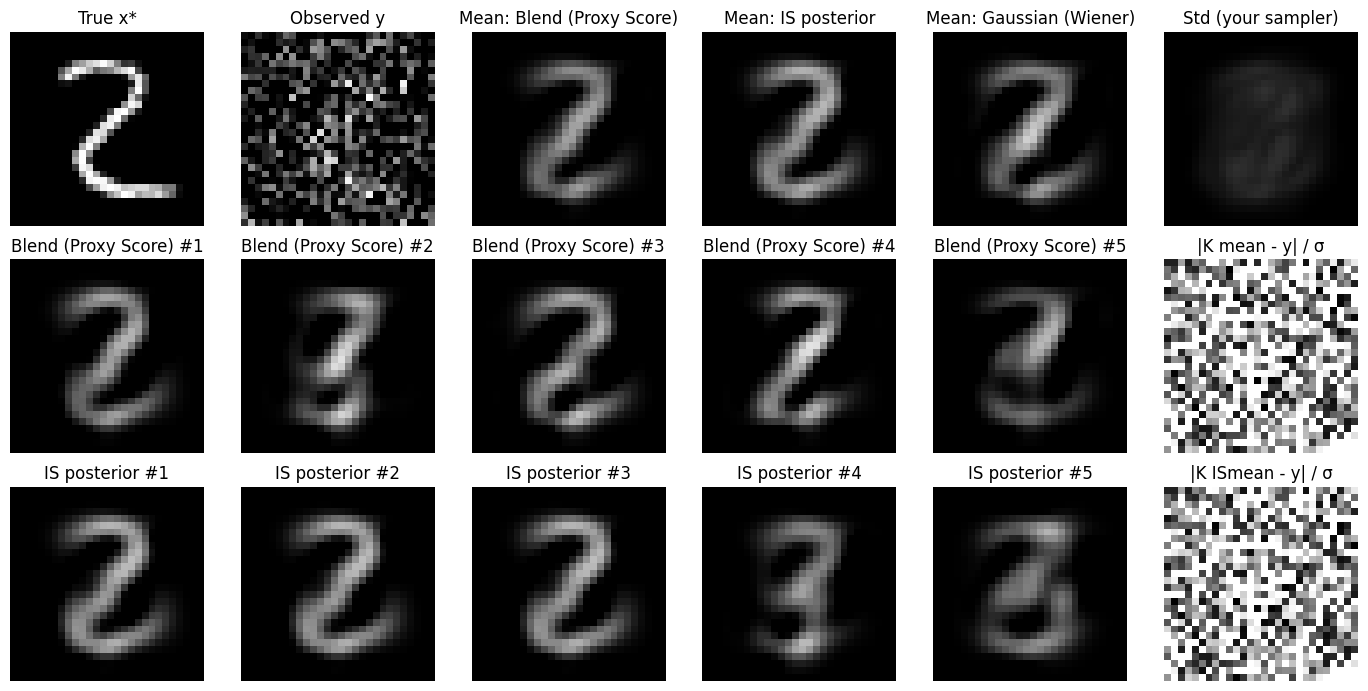

IS posterior ESS: 1  (fraction 0.0%)
[Blend (Proxy Score SVD)] PSNR=14.57 dB, MSE=0.0349, Pred ||Kx−y||²/(σ²·HW)=1.029, Coverage=68.5%, E[log p(y|x)]=-403.408
[IS posterior] PSNR=14.41 dB, MSE=0.0363, Pred ||Kx−y||²/(σ²·HW)=1.029, Coverage=41.6%, E[log p(y|x)]=-403.324
[Gaussian surrogate] PSNR=14.23 dB, MSE=0.0377, Pred ||Kx−y||²/(σ²·HW)=1.028, Coverage=81.5%, E[log p(y|x)]=-403.105


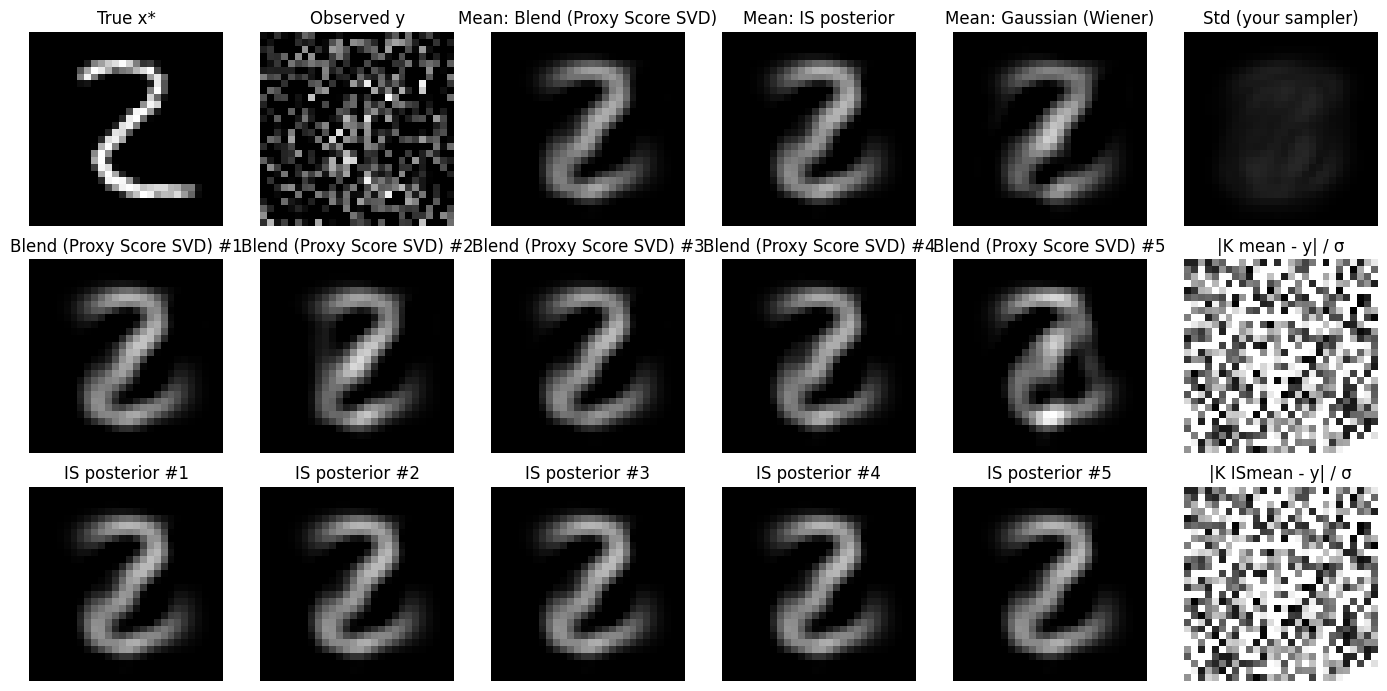

IS posterior ESS: 1  (fraction 0.0%)
[Tweedie only] PSNR=14.52 dB, MSE=0.0353, Pred ||Kx−y||²/(σ²·HW)=1.031, Coverage=55.0%, E[log p(y|x)]=-404.133
[IS posterior] PSNR=14.42 dB, MSE=0.0362, Pred ||Kx−y||²/(σ²·HW)=1.029, Coverage=47.2%, E[log p(y|x)]=-403.382
[Gaussian surrogate] PSNR=14.25 dB, MSE=0.0376, Pred ||Kx−y||²/(σ²·HW)=1.028, Coverage=81.4%, E[log p(y|x)]=-403.036


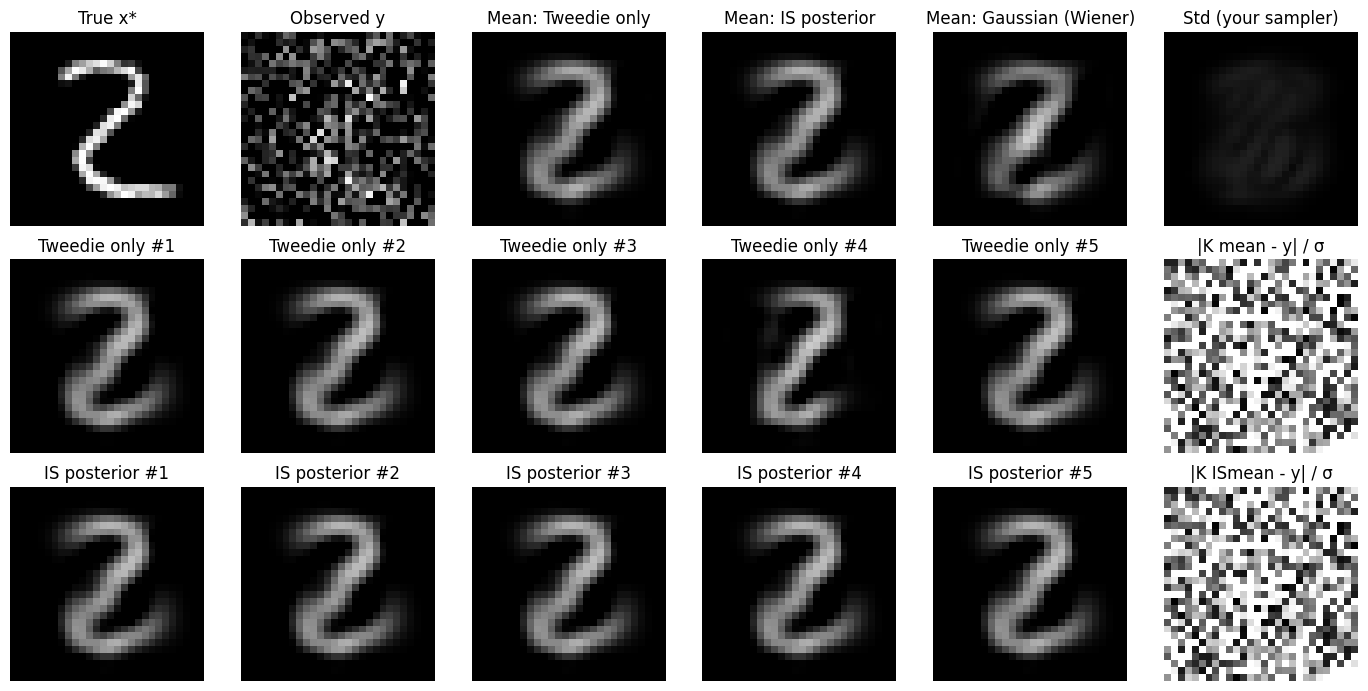

IS posterior ESS: 1  (fraction 0.0%)
[Blend (Proxy Score SVD diag)] PSNR=14.58 dB, MSE=0.0348, Pred ||Kx−y||²/(σ²·HW)=1.029, Coverage=69.0%, E[log p(y|x)]=-403.488
[IS posterior] PSNR=14.41 dB, MSE=0.0362, Pred ||Kx−y||²/(σ²·HW)=1.029, Coverage=39.5%, E[log p(y|x)]=-403.341
[Gaussian surrogate] PSNR=14.26 dB, MSE=0.0375, Pred ||Kx−y||²/(σ²·HW)=1.028, Coverage=81.8%, E[log p(y|x)]=-403.115


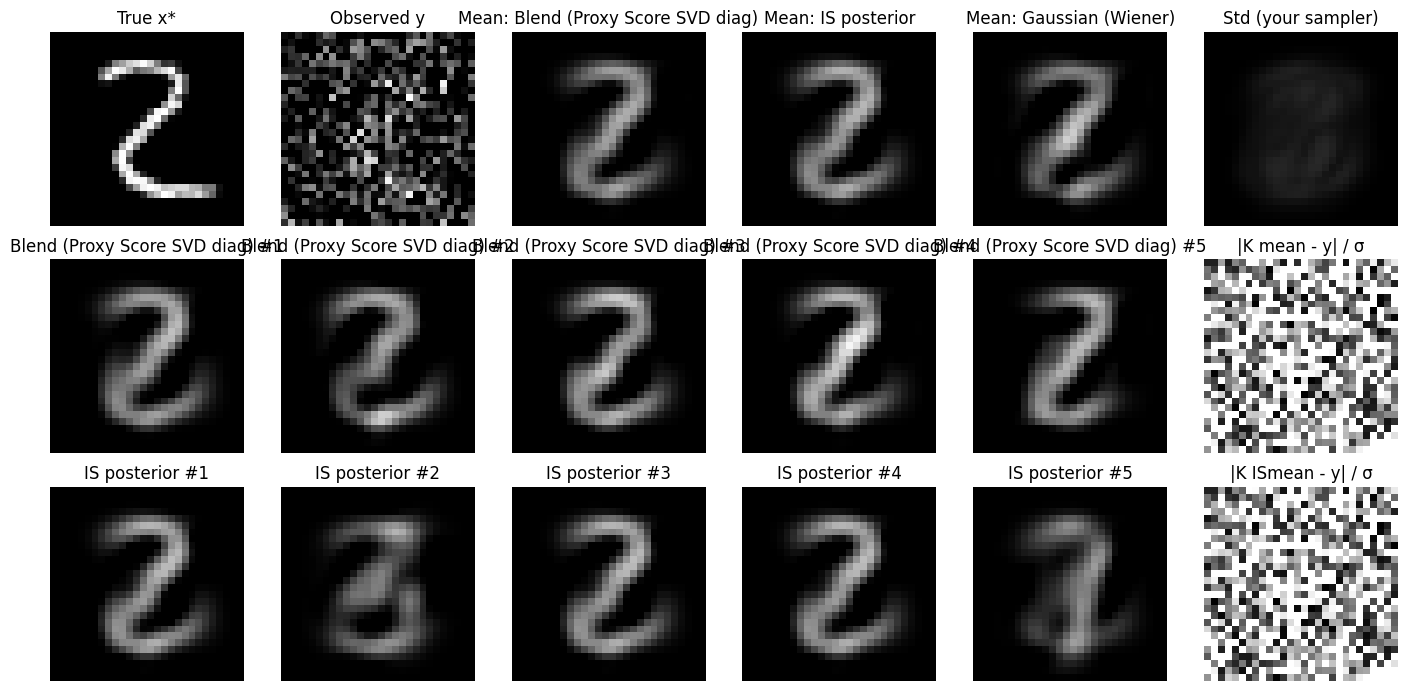

/tmp/ipython-input-412540719.py:1328: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a = min(1.0, float(np.exp(loga)))


[KDE-MALA] 1000/7000 acc=0.544 h=0.271
[KDE-MALA] 2000/7000 acc=0.562 h=0.273
[KDE-MALA] 3000/7000 acc=0.563 h=0.273
[KDE-MALA] 4000/7000 acc=0.565 h=0.273
[KDE-MALA] 5000/7000 acc=0.565 h=0.273
[KDE-MALA] 6000/7000 acc=0.568 h=0.273
[KDE-MALA] 7000/7000 acc=0.565 h=0.273
[chain 0] acceptance=0.565, kept=4000
[KDE-MALA] 1000/7000 acc=0.546 h=0.275
[KDE-MALA] 2000/7000 acc=0.560 h=0.273
[KDE-MALA] 3000/7000 acc=0.556 h=0.271
[KDE-MALA] 4000/7000 acc=0.548 h=0.271
[KDE-MALA] 5000/7000 acc=0.550 h=0.271
[KDE-MALA] 6000/7000 acc=0.552 h=0.271
[KDE-MALA] 7000/7000 acc=0.551 h=0.271
[chain 1] acceptance=0.551, kept=4000
[KDE-MALA] 1000/7000 acc=0.478 h=0.289
[KDE-MALA] 2000/7000 acc=0.510 h=0.282
[KDE-MALA] 3000/7000 acc=0.515 h=0.277
[KDE-MALA] 4000/7000 acc=0.533 h=0.277
[KDE-MALA] 5000/7000 acc=0.530 h=0.277
[KDE-MALA] 6000/7000 acc=0.531 h=0.277
[KDE-MALA] 7000/7000 acc=0.531 h=0.277
[chain 2] acceptance=0.531, kept=4000
[KDE-MALA] 1000/7000 acc=0.543 h=0.27
[KDE-MALA] 2000/7000 acc=0.55

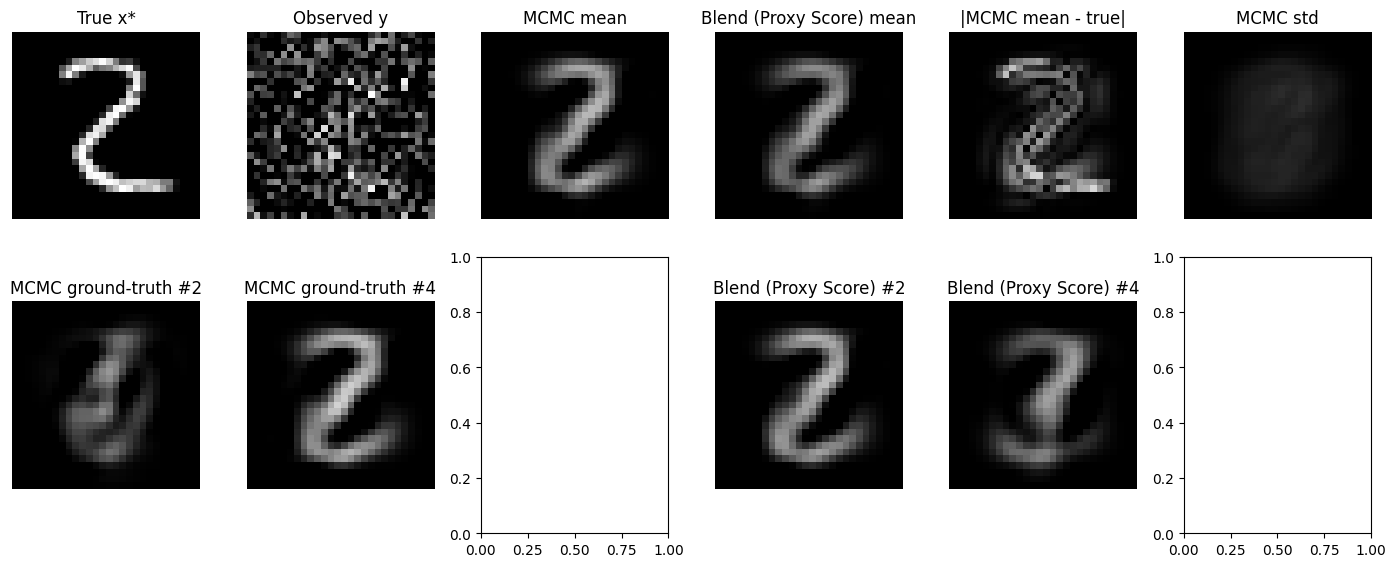

[MCMC ground-truth]    PSNR=25.99 dB, Pred=1.028, Coverage=100.0%
[Blend (Proxy Score SVD)]  PSNR=28.02 dB, Pred=1.029, Coverage=100.0%


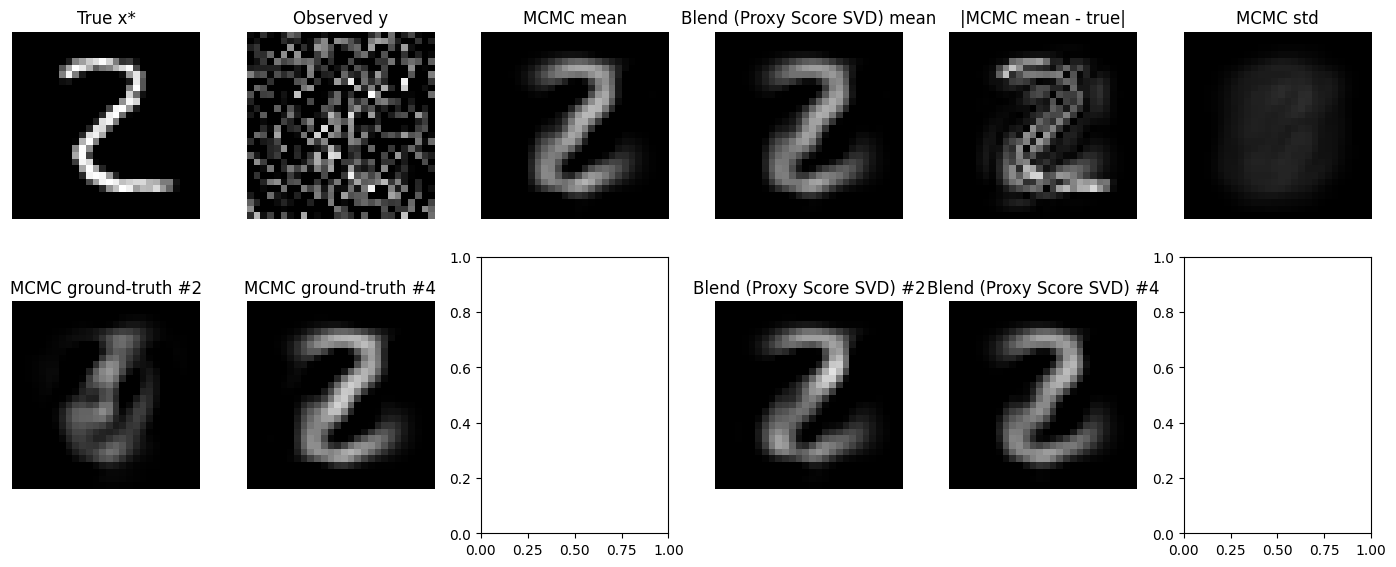

[MCMC ground-truth]    PSNR=25.99 dB, Pred=1.028, Coverage=100.0%
[Tweedie only]  PSNR=26.98 dB, Pred=1.031, Coverage=92.6%


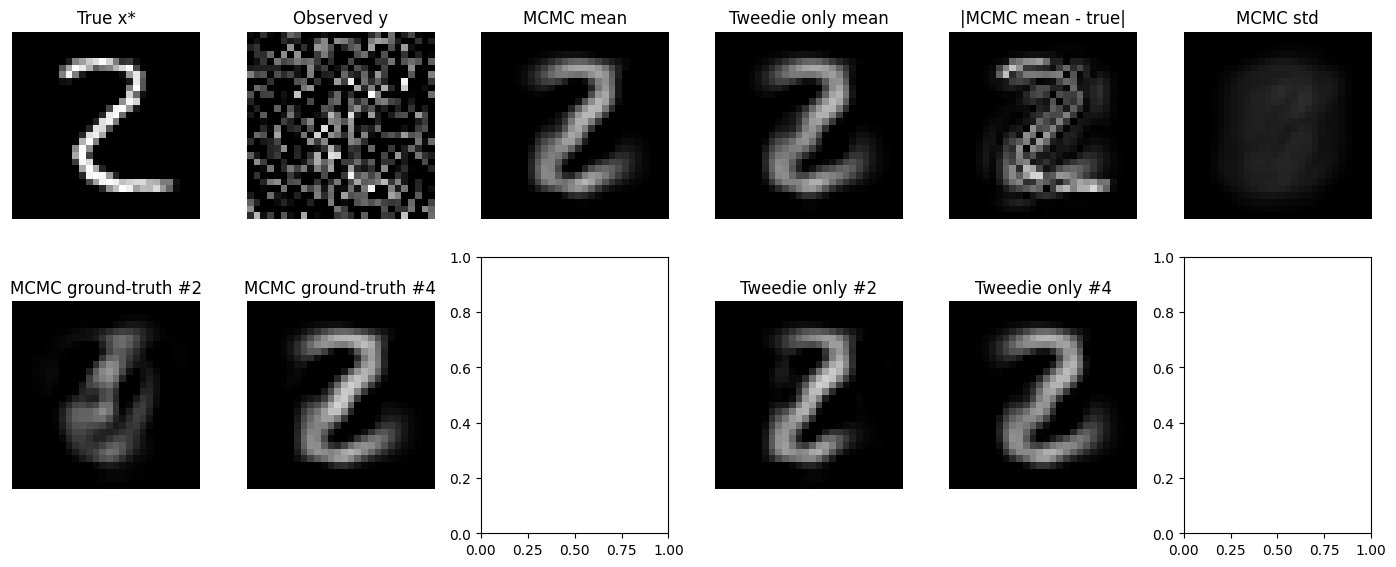

[MCMC ground-truth]    PSNR=25.99 dB, Pred=1.028, Coverage=100.0%
[Blend (Proxy Score SVD diag)]  PSNR=28.17 dB, Pred=1.029, Coverage=100.0%


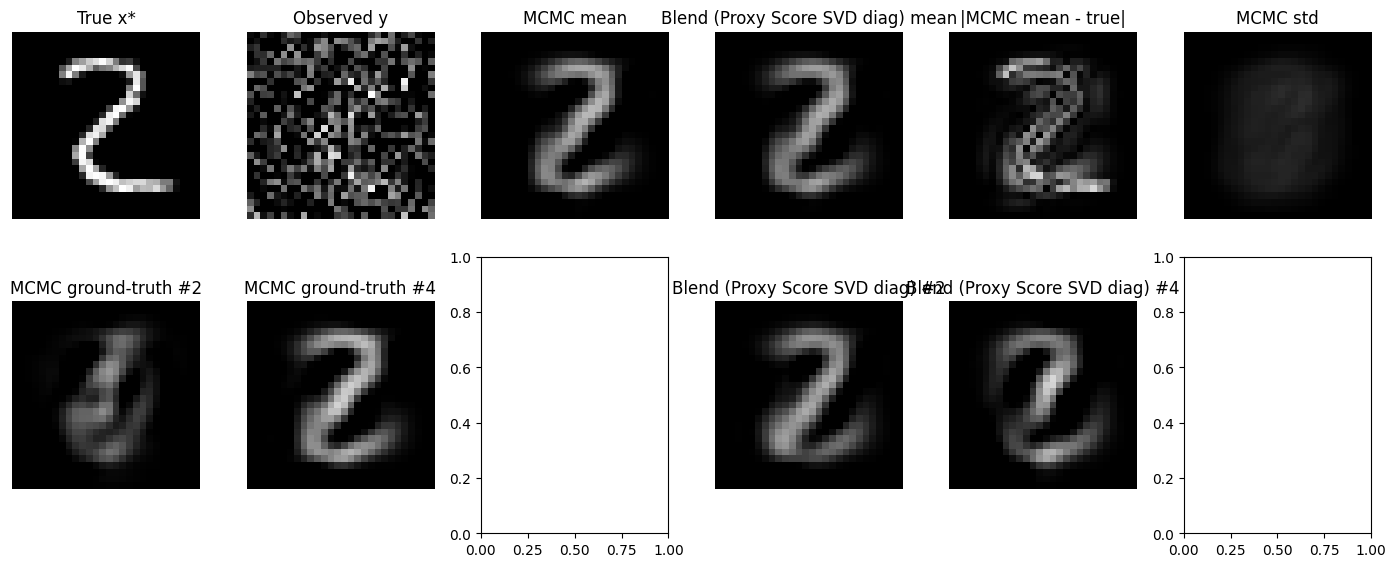

== building nonparametric references (IS posterior + KDE-MCMC) ==
[KDE-MCMC] acc=0.584, kept=2000

=== Prior Faithfulness Report (higher e_logp_kde is better; distances lower are better) ===
set                  E[loglik]  E[log p_KDE]     SW2→IS    SW2→KDE     MMD→IS
Proxy SVD Blend       -403.408       -22.669      0.233      0.595  1.086e-01
Proxy SVD Diag        -403.488       -22.623      0.234      0.597  1.082e-01
Tweedie               -404.133       -22.251      0.275      0.680  1.876e-01
Proxy Blend           -404.064       -22.718      0.339      0.590  1.070e-01
MCMC-GMM              -403.052       -23.511      0.288      0.498  1.326e-01


'mcmc_vs_sampler_overlay_new.png'

In [ ]:
# === MNIST-PCA prior + deblurring likelihood adapters for your pipeline ===
import numpy as np
import cupy as cp


def plot_pair_histograms_overlay(
        y_finals_dict: dict,
        prior_samples,
        post_samples,
        save_path: str,
        dim_pairs: list[tuple[int, int]] = None,
        *,
        bins: int = 100,
        norm_mode: str = "max",
        hist_norm: float = 1.25,
        nrows: int = 3,
        mode: str = 'first',
        display_mode: str = 'standard',
        pre_process_f=None,
        colormap: str = 'inferno',
        post_ref: bool = True,
        likelyhood_func = None,
        draw_countours: bool = True,
        prior_scale: bool = True,
        plot_prior: bool = True,
        plot_post: bool = True,
        post_hist_norm: float = .8,
        # ---------- overlay options ----------
        overlay_samples=None,              # (N,d)
        overlay_style: str = 'heatmap',    # 'heatmap' | 'contour' | 'scatter'
        overlay_cmap: str = 'winter',
        overlay_alpha: float = 0.65,
        overlay_gamma: float = 1.0,
        overlay_linewidth: float = 1.6,
        overlay_mass_levels=(0.50, 0.80, 0.95),
        overlay_on_prior: bool = False,
        # --- scatter controls ---
        overlay_scatter_color: str = '#00FFFF',
        overlay_scatter_alpha: float = 0.7,
        overlay_scatter_size: float = 10.0,
        overlay_scatter_marker: str = 'o',
        overlay_scatter_max: int | None = 50000,
        overlay_scatter_seed: int | None = 0,
    ):
    import numpy as np, matplotlib.pyplot as plt
    import matplotlib as mpl
    from sklearn.decomposition import PCA

    def _to_numpy_local(arr):
        try:
            import cupy as _cp
            if isinstance(arr, _cp.ndarray): return arr.get()
        except Exception:
            pass
        return np.asarray(arr)

    def div_unique_pairs(d):
        return [(i+1, j+1) for i in range(d) for j in range(i+1, d)]

    # --- helper: build Normalize using the SAME transform used to draw ---
    def _norm_from_edges(ref_np, xedges, yedges, i, j, *, n_samples, h_scale, gamma=0.95):
        H, _, _ = np.histogram2d(ref_np[:, i], ref_np[:, j],
                                 bins=[xedges, yedges], density=False)
        V = (h_scale * H / max(n_samples, 1)) ** gamma
        vmax = max(float(V.max()), 1e-12)
        return mpl.colors.Normalize(vmin=0.0, vmax=vmax)

    # --- prep ---
    true_np = _to_numpy_local(prior_samples)
    post_np = _to_numpy_local(post_samples) if (post_samples is not None) else None
    d = true_np.shape[1]

    # build columns
    yf = dict(y_finals_dict)
    if post_np is not None and plot_post:
        yf = {'Posterior': post_np, **yf}
    y_finals_np = {k: _to_numpy_local(v) for k, v in yf.items()}

    if pre_process_f is not None:
        true_np = _to_numpy_local(pre_process_f(true_np))
        post_np = _to_numpy_local(pre_process_f(post_np)) if post_np is not None else None
        y_finals_np = {k: _to_numpy_local(pre_process_f(v)) for k, v in y_finals_np.items()}

    if dim_pairs is None:
        pairs = div_unique_pairs(d)
        if mode == 'first':
            dim_pairs = pairs[: min(nrows, len(pairs))]
        elif mode == 'rand':
            idx = np.random.choice(len(pairs), min(nrows, len(pairs)), replace=False)
            dim_pairs = [pairs[i] for i in idx]
        elif mode == 'pca':
            p = PCA(n_components=min(32, d)).fit(true_np)
            ord_ = np.argsort(-p.explained_variance_)
            dim_pairs = [(ord_[2*k] + 1, ord_[2*k+1] + 1) for k in range(min(nrows, d // 2))]
        else:
            raise ValueError(f"Unknown mode {mode}")

    pairs = [(i - 1, j - 1) for (i, j) in dim_pairs]
    max_dim = max(max(p) for p in pairs)
    if true_np.shape[1] <= max_dim:
        raise ValueError("Requested dimension exceeds data dimensionality.")
    for name, gen in y_finals_np.items():
        if gen.shape[1] <= max_dim:
            raise ValueError(f"{name!r} has too few dimensions for selected pairs.")

    overlay_np = _to_numpy_local(overlay_samples) if overlay_samples is not None else None

    # --- figure ---
    n_rows = len(pairs)
    n_cols = (1 + len(y_finals_np)) if plot_prior else len(y_finals_np)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), squeeze=False)
    plt.subplots_adjust(wspace=0.05 if display_mode == 'min_label' else 0.25,
                        hspace=0.05 if display_mode == 'min_label' else 0.25)

    # -------- choose the reference for BIN EDGES (zoom) --------
    if prior_scale:
        edge_ref_np = true_np
    else:
        if (post_np is not None) and post_ref:
            edge_ref_np = post_np
        else:
            edge_ref_np = np.concatenate(list(y_finals_np.values()), axis=0)

    for row_idx, (i, j) in enumerate(pairs):
        # 1) Edges: from edge_ref_np → controls the zoom/window
        _, xedges, yedges = np.histogram2d(edge_ref_np[:, i], edge_ref_np[:, j],
                                           bins=bins, density=False)

        # 2) Normalization for sampler columns:
        #    ALWAYS computed from PRIOR on the SAME edges and with hist_norm,
        #    so appearance matches prior_scale=True regardless of the zoom.
        sampler_norm = _norm_from_edges(true_np, xedges, yedges, i, j,
                                        n_samples=true_np.shape[0],
                                        h_scale=hist_norm, gamma=0.95)

        # 3) Prior column’s own norm (if we’re showing it)
        if plot_prior:
            prior_norm = _norm_from_edges(true_np, xedges, yedges, i, j,
                                          n_samples=true_np.shape[0],
                                          h_scale=hist_norm, gamma=0.95)

        def _draw_base(ax, data_np, n_samples, title, draw_title, plt_norm, h_norm, likelihood_func=None):
            H, _, _ = np.histogram2d(data_np[:, i], data_np[:, j], bins=[xedges, yedges], density=False)
            density = (h_norm * H / max(n_samples, 1)) ** 0.95
            ax.imshow(density.T, origin="lower", cmap=colormap, norm=plt_norm,
                      extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                      aspect="auto", interpolation="nearest", zorder=0)
            if display_mode == 'min_label':
                ax.set_xticks([]); ax.set_yticks([])
            else:
                ax.set_xlabel(f"$d_{{{i+1}}}$"); ax.set_ylabel(f"$d_{{{j+1}}}$")
            if draw_title: ax.set_title(title, fontsize=16)

            if (likelihood_func is not None) and draw_countours:
                xlim = ax.get_xlim(); ylim = ax.get_ylim()
                plot_likelihood_contours(
                    ax, likelihood_func, xlim, ylim,
                    levels=5, color="#D3D3D3", alpha=.92,
                    linewidths=1.5, linestyles="solid", grid_res=200,
                    is_log_density=True, normalize=True,
                    transform=None, backend="auto", full_dim=d,
                    ij=(i, j), anchor=None, percentile_range=(75, 99.5),
                    mass_levels=None, debug_save_path=None
                )
        def _levels_for_masses(pdf, masses, dx, dy):
            # Return density thresholds whose superlevel sets have the desired masses
            z = np.sort(pdf.ravel())                        # ascending
            c = np.cumsum(z) * (dx * dy)                    # cumulative mass
            tot = c[-1]
            levels = []
            for m in np.clip(np.asarray(masses, float), 1e-6, 1-1e-6):
                # find density t such that mass{pdf >= t} ≈ m
                k = np.searchsorted(c, tot - m, side='left')
                k = min(max(k, 0), len(z) - 1)
                levels.append(z[k])
            return np.unique(levels)

        def _draw_overlay(ax):
            if overlay_style == 'contour':
                Hov, _, _ = np.histogram2d(overlay_np[:, i], overlay_np[:, j], bins=[xedges, yedges], density=False)
                P = Hov.astype(np.float64); s = P.sum()
                if s <= 0: return
                P /= s
                vals = np.sort(P[P > 0].ravel())[::-1]
                csum = np.cumsum(vals)
                thr = []
                for m in np.clip(np.asarray(overlay_mass_levels, float), 1e-6, 1-1e-6):
                    k = np.searchsorted(csum, m, side='left')
                    k = min(max(k, 0), len(vals)-1)
                    thr.append(vals[k])
                levels = np.unique(np.sort(thr))
                Xc = 0.5 * (xedges[:-1] + xedges[1:])
                Yc = 0.5 * (yedges[:-1] + yedges[1:])
                xx, yy = np.meshgrid(Xc, Yc, indexing='xy')
                if len(levels) >= 1:
                    ax.contour(xx, yy, P.T, levels=levels,
                               cmap=overlay_cmap, linewidths=overlay_linewidth,
                               alpha=overlay_alpha, zorder=10)

            if overlay_np is None:
                return

            Xc = 0.5 * (xedges[:-1] + xedges[1:])
            Yc = 0.5 * (yedges[:-1] + yedges[1:])
            xx, yy = np.meshgrid(Xc, Yc, indexing='xy')

            if overlay_style == 'contour':
                pts = overlay_np[:, [i, j]].astype(np.float64, copy=False)

                # ---- KDE on the grid (preferred) ----
                P = None
                try:
                    from sklearn.neighbors import KernelDensity
                    # Scott-like bandwidth
                    n = max(len(pts), 1)
                    bw_auto = (np.std(pts, axis=0).mean() + 1e-12) * (n ** (-1/5))
                    kde = KernelDensity(bandwidth=float(bw_auto), kernel='gaussian')
                    kde.fit(pts)
                    logp = kde.score_samples(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
                    P = np.exp(logp)                           # pdf on grid (unnormalized)
                except Exception:
                    # ---- Fallback: Gaussian-smoothed 2D histogram ----
                    Hov, _, _ = np.histogram2d(
                        pts[:, 0], pts[:, 1],
                        bins=[xedges, yedges], density=False
                    )
                    Z = Hov.astype(np.float64).T
                    try:
                        from scipy.ndimage import gaussian_filter
                        # sigma ~ few percent of grid size gives pleasant smoothing
                        P = gaussian_filter(Z, sigma=max(1.0, 0.06 * Z.shape[0]))
                    except Exception:
                        # very last resort: no smoothing
                        P = Z

                # normalize to **density** (so mass levels are meaningful)
                dx = float(xedges[1] - xedges[0])
                dy = float(yedges[1] - yedges[0])
                mass = P.sum() * dx * dy
                if mass > 0:
                    P = P / mass

                levels = _levels_for_masses(P, overlay_mass_levels, dx, dy)
                if len(levels) > 0:
                    ax.contour(xx, yy, P, levels=levels,
                               cmap=overlay_cmap, linewidths=overlay_linewidth,
                               alpha=overlay_alpha, zorder=10)
            elif overlay_style == 'heatmap':
                Hov, _, _ = np.histogram2d(overlay_np[:, i], overlay_np[:, j], bins=[xedges, yedges], density=False)
                Z = Hov.astype(np.float64).T
                if Z.max() <= 0: return
                Zn = Z / Z.max()
                alpha_map = (Zn ** overlay_gamma) * overlay_alpha
                Zm = np.ma.masked_where(Zn <= 0, Zn)
                cmap = plt.cm.get_cmap(overlay_cmap).copy()
                cmap.set_bad(alpha=0.0)
                ax.imshow(Zm, origin='lower', cmap=cmap,
                          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                          aspect='auto', interpolation='nearest',
                          alpha=alpha_map, zorder=10)
            elif overlay_style == 'scatter':
                pts = overlay_np[:, [i, j]]
                n = pts.shape[0]
                if overlay_scatter_max is not None and n > overlay_scatter_max:
                    rng = np.random.default_rng(overlay_scatter_seed)
                    idx = rng.choice(n, overlay_scatter_max, replace=False)
                    pts = pts[idx]
                ax.scatter(pts[:, 0], pts[:, 1],
                           s=overlay_scatter_size, c=overlay_scatter_color,
                           alpha=overlay_scatter_alpha, marker=overlay_scatter_marker,
                           linewidths=0.0, zorder=12)

        # --- prior column (optional) ---
        if plot_prior:
            like_wrapper = None
            if likelyhood_func is not None and draw_countours:
                def like_wrapper(U_np):
                    import cupy as cp
                    return cp.asnumpy(likelyhood_func(cp.asarray(U_np)))
            ax0 = axes[row_idx, 0]
            _draw_base(ax0, true_np, true_np.shape[0], "Prior & IS contours",
                       draw_title=(row_idx == 0), plt_norm=prior_norm, h_norm=hist_norm,
                       likelihood_func=like_wrapper)
            if overlay_on_prior: _draw_overlay(ax0)

        # --- sampler columns ---
        for col_idx, (lab, y_gen) in enumerate(y_finals_np.items(), start=int(plot_prior)):
            ax = axes[row_idx, col_idx]
            _draw_base(ax, y_gen, y_gen.shape[0], lab,
                       draw_title=(row_idx == 0),
                       plt_norm=sampler_norm,          # norm from PRIOR (same look as prior_scale=True)
                       h_norm=hist_norm,               # use same h_norm as prior
                       likelihood_func=None)
            _draw_overlay(ax)

        if display_mode == 'min_label':
            axes[row_idx, 0].set_ylabel(f"$d_{{{i+1}}}\\,v\\,d_{{{j+1}}}$",
                                        rotation=90, labelpad=20,
                                        va='center', ha='center', fontsize=14)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close(fig)



def to_legacy_results(res, steps_list, samplers):
    # 1) Restore per-sampler series (for plots)
    if 'divs_dict' in res:
        for _, _, label, *rest in samplers:
            if label not in res or len(res[label]) == 0:
                try:
                    res[label] = list(res['divs_dict'][label])
                except Exception:
                    res[label] = []

    # 2) Build legacy output_dict from the last step (or from samples_dict)
    out = {}
    last_step = steps_list[-1] if len(steps_list) else None
    if last_step is not None and f'{last_step}_dict' in res:
        step_out, _step_divs = res[f'{last_step}_dict']
        if isinstance(step_out, dict) and step_out:
            out = dict(step_out)

    if (not out) and ('samples_dict' in res):
        for k, v in res['samples_dict'].items():
            if isinstance(v, list) and len(v) > 0:
                out[k] = v[-1]
            elif k in ('True prior', 'True posterior'):
                out[k] = v

    # Ensure True prior/posterior passthrough
    if 'samples_dict' in res:
        for k in ('True prior', 'True posterior'):
            if k in res['samples_dict']:
                out[k] = res['samples_dict'][k]

    res['output_dict'] = out
    return res



# --- helpers (reuse FFT blur consistent with the likelihood) ---
def _decode_imgs(Xcp, components_np, mean_flat_np):
    W  = cp.asarray(components_np, dtype=cp.float64)        # (d,784)
    mu = cp.asarray(mean_flat_np, dtype=cp.float64)         # (784,)
    flat = Xcp @ W + mu[None, :]
    return flat.reshape(-1, 28, 28)

def _fft_blur(imgs_cp, G_fft_np):
    G = cp.asarray(G_fft_np)
    F = cp.fft.fft2(imgs_cp, axes=(1,2))
    Y = F * G[None, ...]
    return cp.fft.ifft2(Y, axes=(1,2)).real.astype(cp.float64)

def evaluate_sampler(label, results, extras, likelyhood_func, loglik_grad_fn, components, mean_flat, G_fft, noise_sigma):
    # Pull generated samples (PCA coeffs) from your results
    Xgen = results['output_dict'][label]           # (M, d) CuPy
    Xgen = cp.asarray(Xgen, dtype=cp.float64)

    # Decode to images and check likelihood/predictive
    imgs = _decode_imgs(Xgen, components, mean_flat)     # (M,28,28)
    y_obs = cp.asarray(extras['y_obs'], dtype=cp.float64)

    # 1) Mean log-likelihood under the *same* model used for sampling
    ll = likelyhood_func(Xgen)                            # (M,)
    mean_ll = float(ll.mean().get())

    # 2) Posterior predictive normalized error: ||Kx - y||^2 / (σ^2 * HW)
    y_hat = _fft_blur(imgs, G_fft)
    resid = y_hat - y_obs[None, :, :]
    pred_norm = float((cp.mean(resid**2) / (noise_sigma**2)).get())

    # 3) Posterior mean reconstruction vs true image
    x_true = cp.asarray(extras['x_true'], dtype=cp.float64)      # (28,28)
    img_mean = imgs.mean(axis=0)
    rmse_img = float(cp.sqrt(cp.mean((img_mean - x_true)**2)).get())

    # 4) Coverage: pixel-wise 95% credible band contains x_true?
    lo = cp.percentile(imgs, 2.5, axis=0)
    hi = cp.percentile(imgs,97.5, axis=0)
    cover = float(cp.mean((x_true >= lo) & (x_true <= hi)).get())

    # 5) Relative KSD (optional, if you defined a posterior score proxy)
    #    Here use s_post_proxy(x) = s_prior(x) + ∇ log p(y|x).
    #def post_score_proxy(Xcp):
    #    return fit_kernel_score(Xcp) + loglik_grad_fn(Xcp)
    #mksd = compute_multiscale_ksd(Xgen, post_score_proxy)
    # "floor" against OU-evolved prior (same as your run_comparison baseline)
    floor = None
    try:
        floor = [v for k,v in results.items() if k.endswith('_avg')][-1]  # last avg added
    except Exception:
        pass

    print(f"=== {label} ===")
    print(f"Mean log-likelihood E[log p(y|x)]: {mean_ll: .3f}  (↑ better)")
    print(f"Posterior predictive ||Kx - y||^2 / (σ^2·HW): {pred_norm: .3f}  (~1 is ideal)")
    print(f"RMSE of posterior mean (image space): {rmse_img: .4f}")
    print(f"Pixelwise 95% coverage: {cover*100: .1f}%")
    #print(f"M-KSD vs proxy score: {mksd: .3e}  (↓ better)")

    aux = extras
        # --- pull things from your previous run ------------------------------------
    X_samples = results['output_dict'][LABEL]       # (M, d) cp or np
    components = aux['components']                  # (d,784) np
    mean_flat  = aux['mean_flat']                   # (784,) np
    y_obs      = aux['y_obs']                       # (28,28) np
    x_true     = aux['x_true']                      # (28,28) np
    G_fft      = aux['kernel_fft']                  # (28,28) complex np
    noise_sigma = aux['meta']['noise_sigma']

    # --- decode your posterior samples to images --------------------------------
    imgs = decode_imgs(X_samples, components, mean_flat)        # (M,28,28)
    post_mean = imgs.mean(axis=0)
    post_std  = imgs.std(axis=0)

    # --- linear-Gaussian (Wiener) baseline --------------------------------------
    _, wiener_img = wiener_pca_posterior_mean(aux, noise_sigma)

    # --- predictive check --------------------------------------------------------
    yhat = fft_blur_np(imgs, G_fft)                            # (M,28,28)
    norm_resid = (yhat - y_obs[None,:,:]) / noise_sigma        # z-scores per pixel
    pred_m2 = np.mean(norm_resid**2)                           # should be ~1 if calibrated

    # --- simple metrics ----------------------------------------------------------
    mse_mean = np.mean((post_mean - x_true)**2)
    psnr_mean = 10*np.log10(1.0 / max(mse_mean, 1e-12))
    mse_wiener = np.mean((wiener_img - x_true)**2)
    psnr_wiener = 10*np.log10(1.0 / max(mse_wiener, 1e-12))

    print(f"[{LABEL}] posterior-mean MSE={mse_mean:.4f}, PSNR={psnr_mean:.2f} dB")
    print(f"[Wiener baseline] MSE={mse_wiener:.4f}, PSNR={psnr_wiener:.2f} dB")
    print(f"Predictive ||Kx - y||^2 / (σ^2·HW) over samples: {pred_m2:.3f} (≈1 ideal)")

    # --- panel: truths, reconstructions, uncertainty, samples --------------------
    def im(ax, a, title, cmap='gray'):
        ax.imshow(np.clip(a,0,1), cmap=cmap, vmin=0, vmax=1)
        ax.set_title(title, fontsize=12); ax.axis('off')

    fig, axs = plt.subplots(3, 6, figsize=(14,7))
    im(axs[0,0], x_true, "True x*")
    im(axs[0,1], y_obs, "Observed y (blur+noise)")
    im(axs[0,2], post_mean, f"Posterior mean\n{LABEL}")
    im(axs[0,3], wiener_img, "Wiener baseline (PCA-Gauss)")
    im(axs[0,4], np.abs(post_mean-x_true), "|mean - true|")
    im(axs[0,5], post_std, "Posterior std")

    # random 2×5 grid of posterior samples
    idx = np.random.choice(imgs.shape[0], size=10, replace=False)
    for k, idk in enumerate(idx[:5]):
        im(axs[1,k], imgs[idk], f"Sample {k+1}")
    for k, idk in enumerate(idx[5:10]):
        im(axs[2,k], imgs[idk], f"Sample {k+6}")

    # predictive residual maps for mean and Wiener
    res_mean = fft_blur_np(post_mean[None,...], G_fft)[0] - y_obs
    res_w = fft_blur_np(wiener_img[None,...], G_fft)[0] - y_obs
    im(axs[1,5], np.abs(res_mean)/noise_sigma, "|K mean - y| / σ")
    im(axs[2,5], np.abs(res_w)/noise_sigma, "|K Wiener - y| / σ")

    plt.tight_layout()
    plt.show()
    return dict(mean_ll=mean_ll, pred_norm=pred_norm, rmse_img=rmse_img, coverage=cover) #mksd=mksd)


LABEL = 'Blend (KSS+Tweedie)'   # or 'Tweedie only' / 'KSS only'

# --- helpers ---------------------------------------------------------------


def to_np(a):
    try:
        import cupy as _cp
        if isinstance(a, _cp.ndarray): return _cp.asnumpy(a)
    except Exception:
        pass
    return np.asarray(a)

def decode_imgs(X, components, mean_flat):
    X_np = to_np(X)                     # (N,d)
    imgs_flat = X_np @ components       # (N,784)
    imgs = (imgs_flat + mean_flat[None,:]).reshape(-1,28,28)
    return imgs

def fft_blur_np(imgs, G_fft):
    # imgs: (N,28,28) np
    F = np.fft.fft2(imgs, axes=(1,2))
    Y = F * G_fft[None,...]
    return np.fft.ifft2(Y, axes=(1,2)).real


def rmse_mean(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a - b)**2)))

def rel_l2(a, b, eps=1e-12):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.linalg.norm(a - b) / (np.linalg.norm(b) + eps))

def wiener_pca_posterior_mean(aux, noise_sigma):
    """
    Linear-Gaussian baseline in PCA space:
       z ~ N(0, Λ),  y ~ N(K(C^T z + μ), σ^2 I)
    Posterior mean solves:  (Λ^{-1} + C K^T Σ^{-1} K C^T) z = C K^T Σ^{-1} (y - K μ)
    """
    C   = aux['components']          # (d,784)
    mu  = aux['mean_flat']           # (784,)
    y   = aux['y_obs'].reshape(-1)   # (784,)
    G   = aux['kernel_fft']          # (28,28) complex
    pca = aux['pca']
    d   = C.shape[0]
    inv_s2 = 1.0/(noise_sigma**2)

    def K_apply(x_flat):  # (784,) -> (784,)
        img = x_flat.reshape(1,28,28)
        return fft_blur_np(img, G).reshape(-1)

    # precompute A = K C^T (784 x d)
    A = np.zeros((784, d))
    for j in range(d):
        basis_j = C[j].reshape(28,28)     # component row is 784-long
        A[:, j] = K_apply(basis_j.reshape(-1))

    # J = (1/σ^2) C (K^T K C^T) = (1/σ^2) C (K (A))
    LA = np.zeros_like(A)
    for j in range(d):
        LA[:, j] = K_apply(A[:, j])
    J = inv_s2 * (C @ LA)                 # (d,d)

    # rhs = C K^T Σ^{-1} (y - K μ) = (1/σ^2) C K (y - K μ)
    y_minus_Kmu = y - K_apply(mu)
    rhs = inv_s2 * (C @ K_apply(y_minus_Kmu))

    # prior precision Λ^{-1} from PCA explained variances
    lam = np.maximum(pca.explained_variance_.astype(np.float64), 1e-12)
    Prec = np.diag(1.0/lam) + J
    z_map = np.linalg.solve(Prec, rhs)     # (d,)
    x_map = (z_map @ C + mu).reshape(28,28)
    return z_map, x_map


# Build CuPy-native log-likelihood and gradient in PCA space
def make_deblur_likelihood_pca_cp(components_np, mean_flat_np, y_obs_np, G_fft_np, noise_sigma: float):
    """
    Returns:
      loglik_fn(X_cp)      -> (N,) cp.float64  (unnormalized log p(y|x), Gaussian)
      grad_loglik_fn(X_cp) -> (N,d) cp.float64 (∇_X log p(y|x))
    """
    # Cache on GPU
    W   = cp.asarray(components_np, dtype=cp.float64)         # (d, 784)
    mu  = cp.asarray(mean_flat_np, dtype=cp.float64)          # (784,)
    y   = cp.asarray(y_obs_np, dtype=cp.float64).reshape(28, 28)
    G   = cp.asarray(G_fft_np)                                 # complex FFT kernel
    inv_var = cp.asarray(1.0 / (noise_sigma * noise_sigma), dtype=cp.float64)

    def _decode_imgs(Xcp):  # (N,d) -> (N,28,28)
        Xcp = cp.asarray(Xcp, dtype=cp.float64)
        flat = Xcp @ W + mu[None, :]                           # (N,784)
        return flat.reshape(-1, 28, 28)

    def _fft_blur(imgs):                                       # (N,28,28) -> (N,28,28)
        F = cp.fft.fft2(imgs, axes=(1, 2))
        Y = F * G[None, ...]
        return cp.fft.ifft2(Y, axes=(1, 2)).real.astype(cp.float64)

    def loglik_fn(Xcp):
        imgs = _decode_imgs(Xcp)                               # (N,28,28)
        y_hat = _fft_blur(imgs)
        resid = y[None, :, :] - y_hat
        se = cp.sum(resid * resid, axis=(1, 2))                # (N,)
        return (-0.5 * inv_var * se).astype(cp.float64)

    def grad_loglik_fn(Xcp):
        imgs = _decode_imgs(Xcp)                               # (N,28,28)
        y_hat = _fft_blur(imgs)
        resid = y[None, :, :] - y_hat
        # image-space gradient: K^T (y - Kx) / σ^2 ; Gaussian blur => K^T = K
        grad_img = _fft_blur(resid) * inv_var                  # (N,28,28)
        grad_flat = grad_img.reshape(grad_img.shape[0], -1)    # (N,784)
        # chain rule to PCA coeffs: x_flat = X @ W + mu  => ∂x/∂X = W
        return grad_flat @ W.T                                 # (N,d)

    return loglik_fn, grad_loglik_fn


# --- Cupy-based score whitener -------------------------------------
def build_score_whitener_cp(prior_sampler_func, prior_score_func,
                            n_eval=20000, kind='diag', eps=1e-5, seed=0):
    import cupy as cp
    X = prior_sampler_func(n_eval, seed=seed)         # (N,d) cp array (MNIST PCA coeffs)
    S = prior_score_func(X)                           # (N,d) cp array (KSS scores at X)
    S = S - cp.mean(S, axis=0, keepdims=True)         # debias; should be ~0 in theory

    if kind == 'diag':
        # per-dim RMS scale
        rms = cp.sqrt(cp.mean(S**2, axis=0) + eps)    # (d,)
        W = 1.0 / rms                                 # diag preconditioner
        def P(V):  # V: (N,d)
            return V * W[None, :]
        info = dict(type='diag', W=W)
    else:
        # full whitening: Σ_s^{-1/2}
        d = S.shape[1]
        C = (S.T @ S) / S.shape[0] + eps * cp.eye(d)
        ev, U = cp.linalg.eigh(C)
        Winvhalf = U @ (cp.diag(1.0 / cp.sqrt(ev))) @ U.T
        def P(V):
            return V @ Winvhalf.T
        info = dict(type='full', Winvhalf=Winvhalf)

    return P, info


def get_data_prior_funcs(X_cp):
    """
    Adapts a *data prior* (pool X_cp in R^d) to your sampler API.
    Returns:
      prior_sampler_func(n, seed) -> (n,d) cp.ndarray (resample from pool)
      prior_score_func            -> alias to fit_kernel_score (already GPU)
    """
    X_cp = cp.asarray(X_cp, dtype=cp.float64)
    N = int(X_cp.shape[0])

    def prior_sampler_func(n, seed=None):
        rs = cp.random.RandomState(int(seed)) if (seed is not None and seed != 'rand') else cp.random
        idx = rs.choice(N, size=int(n), replace=True)
        return X_cp[idx]

    # You already have fit_kernel_score(X) -> (N,d) cp array
    prior_score_func = fit_kernel_score
    return prior_sampler_func, prior_score_func


# ---------- MAIN: run MNIST deblurring in your pipeline ----------
def main_mnist_deblur():
    import cupy as cp
    # 1) Prepare MNIST PCA & build the deblurring likelihood/grad (on GPU)
    (X_np, loglik_np, grad_np), aux = prepare_mnist_pca_and_likelihood(
        N_train=50_000, n_components=15, blur_sigma=2.6, noise_sigma=0.3,
        seed=0, batch_size_fft=1024)
    components = aux['components']     # (d,784) np
    mean_flat  = aux['mean_flat']      # (784,)   np
    y_obs      = aux['y_obs']          # (28,28)  np
    G_fft      = aux['kernel_fft']     # (28,28)  complex np
    noise_sig  = aux['meta']['noise_sigma']

    # Move prior pool to GPU
    X_cp = cp.asarray(X_np, dtype=cp.float64)

    # 2) Wrap prior & likelihood for your samplers
    prior_sampler_func, prior_score_func = get_data_prior_funcs(X_cp)

    tau_like = 1.0 #try 1.3, then 1.5 if coverage still low
    likelyhood_func, loglik_grad_fn = make_deblur_likelihood_pca_cp(
    components, mean_flat, y_obs, G_fft, noise_sig * tau_like)

    #trivial_likelyhood_func = lambda x: real_likelyhood_func(x)**1.0
    #trivial_loglik_grad_fn = lambda x: 1.0 * real_loglik_grad_fn(x)
    #likelyhood_func, loglik_grad_fn = trivial_likelyhood_func, trivial_loglik_grad_fn
    #likelyhood_func, loglik_grad_fn = make_deblur_likelihood_pca_cp(
    #    components, mean_flat, y_obs, G_fft, noise_sig
    #)

    #def prior_score_func_soft(Xcp):
      #return fit_kernel_score(Xcp, params={"k": 8*Xcp.shape[1], "ridge_frac": 1e-2, "dtype": cp.float64, "recompute": True})
    # Optional: a proxy posterior score for KSD diagnostics (s_prior + ∇ loglik)

    def posterior_score_proxy(Xcp):
        return fit_kernel_score(Xcp) + loglik_grad_fn(Xcp)

    # For plotting “true posterior” overlays we’ll just reuse the prior sampler
    post_sampler_func = prior_sampler_func
    post_score_func   = posterior_score_proxy


    #P, _ = build_score_whitener_cp(prior_sampler_func, prior_score_func,
                               #n_eval=20_000, kind='diag', eps=1e-5, seed=0)

    #def prior_score_whitened(Xcp):
        #return P(prior_score_func(Xcp))

    #def post_score_proxy_whitened(Xcp):
         #exact same blend as before, just left-multiplied by P
        #return P(prior_score_func(Xcp) + loglik_grad_fn(Xcp))

    # 3) Samplers to compare (you can add/remove as you like)
    samplers = [
        #('heun_pc', 'blend',   'Blend (Proxy Score White)'),
        ('heun_pc', 'blend_proxy_recomp',   'Blend (Proxy Score)'),
        ('heun_pc', 'blend_proxy_SVD_recomp_diag',   'Blend (Proxy Score SVD diag)'),
        ('heun_pc', 'blend_proxy_SVD_recomp',   'Blend (Proxy Score SVD)'),
        #('heun_pc', 'blend_proxy_recomp',   'Blend (Proxy Score SVD)'),
        ('heun_pc', 'tweedie', 'Tweedie only'),
    ]

    # 4) Run
    results = run_comparison(
        samplers              = samplers,
        steps_list            = [20],
        true_sampler_func     = prior_sampler_func,   # used when no likelihood
        prior_sampler_func    = prior_sampler_func,
        prior_score_func      = prior_score_func,
        likelyhood_func       = likelyhood_func,      # log p(y|x) (CuPy)
        loglik_grad_fn        = loglik_grad_fn,       # ∇_x log p(y|x) (CuPy)
        post_sampler_func     = post_sampler_func,    # for plots/floors
        post_score_func       = post_score_func,      #post_score_proxy_whitened,
        true_init_score       = prior_score_func,     # used in blend mode
        ref_seed              = 0,
        trials                = 1,
        N_part                = 3000,
        N_ref                 = min(18_000, X_cp.shape[0]),
        nrows                 = 4,
        time_split            = 'power',
        T_end                 = 2.0,
        T_target              = 5e-4,
        trial_name            = 'mnist_pca_deblur',
        div                   = 'W2',              # avoids needing true posterior
        plot_hists            = True,
        hist_mode             = 'pca',
        display_mode          = 'min_label',
        d_pairs               = None,                 # or provide a list of pairs
        plot_res              = False,
        plot_post             = False,                # no “true posterior” overlay
        draw_countours        = False,                 # draw likelihood contours
        prior_scale           = True,
        plot_prior            = True,
        hist_norm             = 1.0,
        post_hist_norm        = 1.0,
        cov_rank = 12,
        do_copy_test = False,
    )
    results = to_legacy_results(results, steps_list=[12], samplers=samplers)

    # ---- Run it for your labels (adjust to what you used) ----
    # _ = evaluate_sampler(
    #    label='Blend (KSS+Tweedie)',
    #    results=results,
    #    extras=aux,
    #    likelyhood_func=likelyhood_func,
    #    loglik_grad_fn=loglik_grad_fn,
    #    components=aux['components'],
    #    mean_flat=aux['mean_flat'],
    #    G_fft=aux['kernel_fft'],
    #    noise_sigma=aux['meta']['noise_sigma'],
    #)


     # _ = evaluate_sampler(
     #   label='Tweedie only',
     #   results=results,
     #   extras=aux,
     #   likelyhood_func=likelyhood_func,
     #   loglik_grad_fn=loglik_grad_fn,
     #   components=aux['components'],
     #   mean_flat=aux['mean_flat'],
     #   G_fft=aux['kernel_fft'],
     #   noise_sigma=aux['meta']['noise_sigma'],
    #)


        # --- CONFIG: choose which sampler's output to inspect ---
    #LABEL = 'Blend (KSS+Tweedie)'   # or 'Tweedie only' / 'KSS only'
    #labels = ['Blend (KSS+Tweedie)', 'Tweedie only', ]

    labels = ['Blend (Proxy Score)', 'Blend (Proxy Score SVD)', 'Tweedie only', 'Blend (Proxy Score SVD diag)']
    for LABEL in labels:

      import numpy as np, cupy as cp
      import matplotlib.pyplot as plt

      # ---------- helpers ----------
      def to_np(a):
          try:
              import cupy as _cp
              if isinstance(a, _cp.ndarray): return _cp.asnumpy(a)
          except: pass
          return np.asarray(a)

      def decode_imgs(X, components, mean_flat):
          X = to_np(X)
          imgs_flat = X @ components
          return (imgs_flat + mean_flat[None,:]).reshape(-1,28,28)

      def fft_blur_np(imgs, G_fft):
          F = np.fft.fft2(imgs, axes=(1,2))
          Y = F * G_fft[None,...]
          return np.fft.ifft2(Y, axes=(1,2)).real

      def wiener_pca_posterior(aux, noise_sigma, n_samp=2000):
          C   = aux['components']        # (d,784)
          mu  = aux['mean_flat']         # (784,)
          y   = aux['y_obs'].reshape(-1) # (784,)
          G   = aux['kernel_fft']        # (28,28) complex
          pca = aux['pca']; d = C.shape[0]
          inv_s2 = 1.0/(noise_sigma**2)

          def K_apply(x_flat):
              return fft_blur_np(x_flat.reshape(1,28,28), G).reshape(-1)

          # A = K C^T, LA = K(A)  → J = (1/σ²) C LA  and rhs = (1/σ²) C K (y - Kμ)
          A  = np.zeros((784,d))
          LA = np.zeros_like(A)
          for j in range(d):
              basis_j = C[j].reshape(28,28).reshape(-1)
              A[:,j]  = K_apply(basis_j)
              LA[:,j] = K_apply(A[:,j])
          J   = inv_s2 * (C @ LA)
          rhs = inv_s2 * (C @ K_apply(y - K_apply(mu)))
          lam = np.maximum(pca.explained_variance_.astype(np.float64), 1e-12)
          Prec = np.diag(1.0/lam) + J
          # mean
          z_mean = np.linalg.solve(Prec, rhs)
          x_mean = (z_mean @ C + mu).reshape(28,28)
          # covariance and samples
          L = np.linalg.cholesky(np.linalg.inv(Prec) + 1e-12*np.eye(d))
          zs = z_mean[None,:] + np.random.randn(n_samp, d) @ L.T
          Xs = cp.asarray(zs, dtype=cp.float64)
          return x_mean, Xs


      def metrics_block(Xcp, name, aux, likelyhood_func):
          imgs = decode_imgs(Xcp, aux['components'], aux['mean_flat'])
          x_true = aux['x_true']; y_obs = aux['y_obs']; G = aux['kernel_fft']
          sigma = aux['meta']['noise_sigma']

          post_mean = imgs.mean(axis=0)
          post_std  = imgs.std(axis=0)

          # reconstruction metrics
          mse = float(np.mean((post_mean - x_true)**2))
          psnr = 10*np.log10(1.0/max(mse,1e-12))

          # predictive calibration
          yhat = fft_blur_np(imgs, G)
          pred_m2 = float(np.mean(((yhat - y_obs[None,:,:]) / sigma)**2))

          # coverage (pixelwise 95%)
          lo = np.percentile(imgs, 2.5, axis=0); hi = np.percentile(imgs, 97.5, axis=0)
          cov = float(np.mean((x_true >= lo) & (x_true <= hi)))

          # mean log-likelihood (same model you used)
          try:
              ll = to_np(likelyhood_func(cp.asarray(Xcp, dtype=cp.float64))).mean()
          except Exception:
              ll = np.nan

          return dict(name=name, mse=mse, psnr=psnr, pred_m2=pred_m2, cover=cov, mean_ll=ll,
                      post_mean=post_mean, post_std=post_std, imgs=imgs)

      # ---------- pull your run objects ----------
      X_post = results['output_dict'][LABEL]          # (M,d) cp or np
      X_pool = cp.asarray(results['output_dict']['True prior'])  # OU-evolved prior (for scale)
      components = aux['components']; mean_flat = aux['mean_flat']
      x_true = aux['x_true']; y_obs = aux['y_obs']; G_fft = aux['kernel_fft']
      sigma  = aux['meta']['noise_sigma']

      # ---------- (1) DISCRETE POSTERIOR on the training pool (IS baseline) ----------
      # Weights: w_i ∝ exp(loglik(X_pool))
      ll_pool = likelyhood_func(X_pool)                          # Cupy (N,)
      m = cp.max(ll_pool)
      w = cp.exp(ll_pool - m)
      ess = float((cp.sum(w)**2 / cp.sum(w*w)).get())            # effective sample size
      ess_frac = ess / X_pool.shape[0]
      # Resample to get discrete posterior samples
      X_is, _ = resample_by_alpha(X_pool, w, N= min(5000, X_pool.shape[0]), return_indices=True)

      # ---------- (2) GAUSSIAN (Wiener) surrogate posterior in PCA ----------
      x_wiener_mean, X_gauss = wiener_pca_posterior(aux, sigma, n_samp=5000)

      # ---------- evaluate all three ----------
      me_post = metrics_block(X_post, f"{LABEL}",         aux, likelyhood_func)
      me_is   = metrics_block(X_is,   "IS posterior",     aux, likelyhood_func)
      me_gs   = metrics_block(X_gauss,"Gaussian surrogate", aux, likelyhood_func)

      print(f"IS posterior ESS: {ess:.0f}  (fraction {100*ess_frac:.1f}%)")
      for m in [me_post, me_is, me_gs]:
          print(f"[{m['name']}] PSNR={m['psnr']:.2f} dB, MSE={m['mse']:.4f}, "
                f"Pred ||Kx−y||²/(σ²·HW)={m['pred_m2']:.3f}, Coverage={100*m['cover']:.1f}%, "
                f"E[log p(y|x)]={m['mean_ll']:.3f}")

      # ---------- visualization ----------
      def im(ax, a, title, cmap='gray'):
          ax.imshow(np.clip(a,0,1), cmap=cmap, vmin=0, vmax=1); ax.set_title(title, fontsize=12); ax.axis('off')

      fig, axs = plt.subplots(3, 6, figsize=(14,7))
      im(axs[0,0], x_true, "True x*"); im(axs[0,1], y_obs, "Observed y")
      im(axs[0,2], me_post['post_mean'], f"Mean: {me_post['name']}")
      im(axs[0,3], me_is['post_mean'],   "Mean: IS posterior")
      im(axs[0,4], x_wiener_mean,        "Mean: Gaussian (Wiener)")
      im(axs[0,5], me_post['post_std'],  "Std (your sampler)")

      rng = np.random.default_rng(0)
      for k,(row,m) in enumerate(zip([1,2],[me_post, me_is])):
          idx = rng.choice(m['imgs'].shape[0], size=5, replace=False)
          for j,ii in enumerate(idx):
              im(axs[row,j], m['imgs'][ii], f"{m['name']} #{j+1}")
      # predictive residual of your mean (|K mean - y| / σ)
      res_mean = np.abs(fft_blur_np(me_post['post_mean'][None,...], G_fft)[0]-y_obs)/sigma
      im(axs[1,5], res_mean, "|K mean - y| / σ")
      # predictive residual for IS mean
      res_is   = np.abs(fft_blur_np(me_is['post_mean'][None,...], G_fft)[0]-y_obs)/sigma
      im(axs[2,5], res_is, "|K ISmean - y| / σ")

      plt.tight_layout(); plt.show()

    return results,aux,likelyhood_func,X_cp


# Heavyweight “ground truth” posterior via data-GMM prior + MALA
# Requires: scikit-learn (present on Colab). If needed: !pip -q install scikit-learn



import numpy as np
from sklearn.mixture import GaussianMixture

# ----------------- utilities from your QC (reused) -----------------
def to_np(a):
    try:
        import cupy as _cp
        if isinstance(a, _cp.ndarray): return _cp.asnumpy(a)
    except: pass
    return np.asarray(a)

def decode_imgs(X, components, mean_flat):
    X_np = to_np(X)
    imgs_flat = X_np @ components
    return (imgs_flat + mean_flat[None,:]).reshape(-1,28,28)

def fft_blur_np(imgs, G_fft):
    F = np.fft.fft2(imgs, axes=(1,2))
    Y = F * G_fft[None,...]
    return np.fft.ifft2(Y, axes=(1,2)).real

# ----- build linear-Gaussian pieces in PCA space (A, Kmu, sigma) -----
def build_linear_op(aux):
    C   = aux['components']        # (d,784)
    mu  = aux['mean_flat']         # (784,)
    G   = aux['kernel_fft']        # (28,28) complex
    y   = aux['y_obs'].reshape(-1) # (784,)
    sigma = aux['meta']['noise_sigma']

    # A = K C^T  (784 x d), Kmu = K μ  (784,)
    A = np.zeros((784, C.shape[0]))
    for j in range(C.shape[0]):
        A[:, j] = fft_blur_np(C[j].reshape(1,28,28), G).reshape(-1)
    Kmu = fft_blur_np(mu.reshape(1,28,28), G).reshape(-1)
    return A, Kmu, y, sigma

# --------------- data-GMM prior (diag) + score/logpdf ----------------
class GMMPrior:
    def __init__(self, Z_train, n_components=512, reg=1e-6, seed=0, max_iter=500):
        gm = GaussianMixture(
            n_components=n_components,
            covariance_type='diag',
            reg_covar=reg,
            max_iter=max_iter,
            random_state=seed,
            init_params='kmeans'
        )
        gm.fit(to_np(Z_train))
        self.means   = gm.means_             # (C,d)
        self.stds    = np.sqrt(gm.covariances_)  # (C,d)
        self.weights = gm.weights_           # (C,)
        self.C, self.d = self.means.shape

        # precompute constants
        self.inv_vars = 1.0 / (self.stds**2)            # (C,d)
        self.log_norm = -0.5*np.sum(np.log(2*np.pi*self.stds**2), axis=1)  # (C,)
        self.log_w    = np.log(self.weights + 1e-300)   # (C,)

    def logpdf_and_score(self, Z):
        Z = np.atleast_2d(to_np(Z))                    # (N,d)
        N = Z.shape[0]
        # log component densities
        # log N(z | mu, diag(std^2)) = const - 0.5 * (z-mu)^T Σ^{-1} (z-mu)
        diff = Z[:,None,:] - self.means[None,:,:]      # (N,C,d)
        quad = 0.5 * np.sum(diff*diff*self.inv_vars[None,:,:], axis=2)  # (N,C)
        log_comp = self.log_w[None,:] + self.log_norm[None,:] - quad     # (N,C)
        # log-sum-exp
        m = np.max(log_comp, axis=1, keepdims=True)
        w = np.exp(log_comp - m)                       # (N,C)
        Zlog = (m[:,0] + np.log(np.sum(w, axis=1) + 1e-300))            # (N,)
        resp = w / (np.sum(w, axis=1, keepdims=True) + 1e-300)          # (N,C)
        # score: ∑_c r_c Σ_c^{-1} (μ_c - z)
        score = np.sum(resp[:,:,None] * (self.inv_vars[None,:,:] * (self.means[None,:,:] - Z[:,None,:])), axis=1)
        return Zlog, score

# ----------------------- exact likelihood in z -----------------------
class LinLike:
    def __init__(self, A, Kmu, y, sigma):
        self.A = A.astype(np.float64)        # (784,d)
        self.Kmu = Kmu.astype(np.float64)    # (784,)
        self.y = y.astype(np.float64)        # (784,)
        self.inv_s2 = 1.0/(sigma*sigma)

    def logpdf_and_grad(self, Z):
        Z = np.atleast_2d(to_np(Z))          # (N,d)
        Az = Z @ self.A.T                    # (N,784)
        resid = self.y[None,:] - (self.Kmu[None,:] + Az)   # (N,784)
        ll = -0.5*self.inv_s2 * np.sum(resid*resid, axis=1)  # (N,)
        grad = self.inv_s2 * (resid @ self.A)              # (N,d)
        return ll, grad

# --------------- preconditioned MALA with MH correction ---------------
def mala(logpost_and_grad, z0, n_steps=6000, warmup=3000, target=0.57,
         step_size=0.4, M_diag=None, progress=True, seed=0):
    """
    z_{t+1} ~ N(z_t + 0.5*h*M ∇logπ(z_t),  h*M), accept via MH.
    M_diag: (d,) positive preconditioner. If None, uses ones.
    Returns: samples [n_steps, d], acceptance rate.
    """
    import numpy as np
    rng = np.random.RandomState(seed)
    z = np.asarray(z0, dtype=np.float64).copy()
    d = z.size
    M = np.ones(d, dtype=np.float64) if M_diag is None else np.asarray(M_diag, np.float64)
    invM  = 1.0 / M
    sqrtM = np.sqrt(M)

    # ensure scalar float step size
    def _to_float(x):
        x = np.asarray(x)
        return float(x.reshape(1)[0])
    step_size = _to_float(step_size)

    def log_q(x, mean):
        diff = (x - mean)
        quad = np.sum((diff * diff) * invM) / step_size
        logdet = np.sum(np.log(2*np.pi*step_size*M))
        return -0.5 * (quad + logdet)

    samples = []
    acc = 0
    n_total = warmup + n_steps

    logp, g = logpost_and_grad(z)   # log posterior & gradient at current z

    for t in range(n_total):
        mean_fwd = z + 0.5 * step_size * (M * g)
        prop = mean_fwd + sqrtM * np.sqrt(step_size) * rng.randn(d)
        logp_prop, g_prop = logpost_and_grad(prop)
        mean_bwd = prop + 0.5 * step_size * (M * g_prop)

        log_alpha = (logp_prop - logp) + (log_q(z, mean_bwd) - log_q(prop, mean_fwd))
        accepted = (np.log(rng.rand()) < log_alpha)
        if accepted:
            z, logp, g = prop, logp_prop, g_prop
            acc += 1

        # warmup: Robbins–Monro on log step size toward target accept prob
        if t < warmup:
            accept_prob = min(1.0, float(np.exp(log_alpha)))
            a = 1.0 / (10.0 + t)                 # decaying gain
            step_size *= float(np.exp(a * (accept_prob - target)))
            step_size = _to_float(step_size)     # keep as Python float
        else:
            samples.append(z.copy())

        if progress and ((t+1) % 1000 == 0):
            # robust printing even if step_size were to become array-ish
            h_disp = _to_float(step_size)
            print(f"[MALA] iter {t+1}/{n_total}, acc={(acc/(t+1)):.3f}, h={h_disp:.3g}")

    return np.asarray(samples), acc / n_total


# --------------- wrapper: build posterior & run MCMC -----------------
def run_ground_truth_mcmc(Z_train, aux, n_gmm=512, chains=4, steps=4000, warmup=3000,
                          seed=0, progress=True):
    """
    Z_train : (N,d) PCA coeffs used as prior data (your earlier X).
    Returns dict with 'samples' (concatenated across chains) and helpful bits.
    """
    A, Kmu, y, sigma = build_linear_op(aux)
    like = LinLike(A, Kmu, y, sigma)
    prior = GMMPrior(Z_train, n_components=n_gmm, seed=seed)

    # Gaussian surrogate to get a good starting point & preconditioner (diag of posterior cov)
    # Prec = Λ^{-1} + A^T A / σ^2 ; rhs = A^T (y - Kμ)/σ^2
    pca = aux['pca']; lam = np.maximum(pca.explained_variance_.astype(np.float64), 1e-12)
    Prec = np.diag(1.0/lam) + (A.T @ A) * (1.0/(sigma*sigma))
    rhs  = (A.T @ (y - Kmu)) * (1.0/(sigma*sigma))
    z_map_gauss = np.linalg.solve(Prec, rhs)
    Cov_gauss = np.linalg.inv(Prec)
    M_diag = np.diag(Cov_gauss)  # preconditioner scale per dimension

    def logpost_and_grad(z):
        lp, sp = prior.logpdf_and_score(z)
        ll, gl = like.logpdf_and_grad(z)
        return (lp + ll)[()], (sp + gl)[0] if sp.ndim==2 else (sp + gl)

    all_samps = []
    for c in range(chains):
        z0 = z_map_gauss + np.random.randn(*z_map_gauss.shape) * np.sqrt(M_diag) * 0.5
        samps, acc = mala(logpost_and_grad, z0,
                          n_steps=steps, warmup=warmup, step_size=0.4,
                          M_diag=M_diag, progress=progress, seed=seed+c)
        print(f"[chain {c}] acceptance={acc:.3f}, kept={samps.shape[0]}")
        all_samps.append(samps)
    Z_mcmc = np.concatenate(all_samps, axis=0)
    return dict(samples=Z_mcmc, prior=prior, A=A, Kmu=Kmu, sigma=sigma)


def project_to_pca_subspace(x_true_28x28, components, mean_flat):
    """
    Returns (z_proj, x_proj) where x_proj lives in span(components).
    components: (d,784) with orthonormal rows (standard PCA)
    mean_flat : (784,)
    """
    x = np.asarray(x_true_28x28).reshape(-1)
    C = np.asarray(components)         # (d,784)
    mu = np.asarray(mean_flat)         # (784,)
    z_proj  = C @ (x - mu)             # (d,)
    x_proj  = (C.T @ z_proj + mu).reshape(28,28)
    return z_proj, x_proj


# --------------- evaluate & visualize like your existing panel -------

def rmse_mean(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a - b)**2)))

def rel_l2(a, b, eps=1e-12):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.linalg.norm(a - b) / (np.linalg.norm(b) + eps))


def metrics_block(Xcp, name, aux, likelyhood_func, *, project_truth=True, Z_ref_is=None):
    C, mu = aux['components'], aux['mean_flat']
    imgs = decode_imgs(Xcp, C, mu)                       # (N,28,28)

    # choose which "truth" to evaluate against
    x_true = aux['x_true']
    if project_truth:
        _, x_ref = project_to_pca_subspace(x_true, C, mu)   # <-- keep this convention
    else:
        x_ref = x_true

    y_obs = aux['y_obs']; G = aux['kernel_fft']; sig = aux['meta']['noise_sigma']

    post_mean = imgs.mean(axis=0); post_std = imgs.std(axis=0)

    # reconstruction metrics vs chosen reference (true or projected true)
    mse  = float(np.mean((post_mean - x_ref)**2))
    psnr = 10*np.log10(1.0 / max(mse, 1e-12))

    # posterior predictive calibration (unchanged)
    yhat = fft_blur_np(imgs, G)
    pred_m2 = float(np.mean(((yhat - y_obs[None,:,:]) / sig)**2))

    # pixelwise 95% coverage vs chosen reference
    lo = np.percentile(imgs, 2.5, axis=0)
    hi = np.percentile(imgs,97.5, axis=0)
    cov = float(np.mean((x_ref >= lo) & (x_ref <= hi)))

    # mean log-likelihood under your model (optional)
    try:
        ll = to_np(likelyhood_func(cp.asarray(Xcp, dtype=cp.float64))).mean()
    except Exception:
        ll = np.nan

    # ---------------- NEW: shared metrics ----------------
    rmse_alpha = np.nan
    rmse_amb   = np.nan
    fwd_err    = np.nan

    # Ambient RMSE: use the same reference as PSNR/Coverage (true or projected true)
    rmse_amb = rmse_mean(post_mean, x_ref)

    # Forward/data-fit error: compare blur of posterior mean vs blur of the same ambient reference
    y_ref = fft_blur_np(x_ref[None,:,:], G)[0]          # noiseless reference observation
    y_mu  = fft_blur_np(post_mean[None,:,:], G)[0]
    fwd_err = rel_l2(y_mu, y_ref)

    # Coefficient RMSE: compare posterior mean in coeff space vs IS posterior mean in coeff space
    if Z_ref_is is not None:
        Znp   = to_np(Xcp)               # (N,d) in coeff space
        Zref  = to_np(Z_ref_is)          # (Nref,d) in coeff space
        mu_a     = Znp.mean(axis=0)
        mu_a_ref = Zref.mean(axis=0)
        rmse_alpha = rmse_mean(mu_a, mu_a_ref)

    return dict(
        name=name, mse=mse, psnr=psnr, pred_m2=pred_m2, cover=cov, mean_ll=ll,
        rmse_alpha=rmse_alpha, rmse_amb=rmse_amb, fwd_err=fwd_err,
        post_mean=post_mean, post_std=post_std, imgs=imgs
    )

def compare_to_sampler(Z_mcmc, results, aux, likelyhood_func, label='Blend (KSS+Tweedie)'):
    me_gt   = metrics_block(Z_mcmc, "MCMC ground-truth", aux, likelyhood_func)
    me_ours = metrics_block(results['output_dict'][label], label, aux, likelyhood_func)

    print(f"[{me_gt['name']}]    PSNR={me_gt['psnr']:.2f} dB, "
          f"Pred={me_gt['pred_m2']:.3f}, Coverage={100*me_gt['cover']:.1f}%")
    print(f"[{me_ours['name']}]  PSNR={me_ours['psnr']:.2f} dB, "
          f"Pred={me_ours['pred_m2']:.3f}, Coverage={100*me_ours['cover']:.1f}%")

    # small visual panel
    import matplotlib.pyplot as plt
    def im(ax, a, title, cmap='gray'):
        ax.imshow(np.clip(a,0,1), cmap=cmap, vmin=0, vmax=1); ax.set_title(title, fontsize=12); ax.axis('off')

    fig, axs = plt.subplots(2, 6, figsize=(14,6))
    im(axs[0,0], aux['x_true'], "True x*")
    im(axs[0,1], aux['y_obs'],  "Observed y")
    im(axs[0,2], me_gt['post_mean'],   "MCMC mean")
    im(axs[0,3], me_ours['post_mean'], label+" mean")
    im(axs[0,4], np.abs(me_gt['post_mean']-aux['x_true']), "|MCMC mean - true|")
    im(axs[0,5], me_gt['post_std'],    "MCMC std")
    rng = np.random.default_rng(0)
    for j,src in enumerate([me_gt, me_ours]):
        idx = rng.choice(src['imgs'].shape[0], size=4, replace=False)
        for k,i in enumerate(idx):
            im(axs[1, j*3 + k//2], src['imgs'][i], f"{src['name']} #{k+1}")
    plt.tight_layout(); plt.show()


# ------------------------- USAGE -------------------------------------
# Z_train = X   # <-- your PCA coeffs from the MNIST loader (shape N×d)
# gt = run_ground_truth_mcmc(Z_train, aux, n_gmm=512, chains=4, steps=4000, warmup=3000, seed=0)
# compare_to_sampler(gt['samples'], results, aux, likelyhood_func, label='Blend (KSS+Tweedie)')


# ====================== PRIOR-FAITHFULNESS EVAL MODULE ====================== #
import numpy as np
try:
    import cupy as cp
except Exception:
    cp = None

# --- light utils ---
def _to_np(a):
    if cp is not None and isinstance(a, cp.ndarray): return cp.asnumpy(a)
    return np.asarray(a)

def _to_cp(a):
    if cp is not None: return cp.asarray(a, dtype=cp.float64)
    return np.asarray(a, np.float64)

def decode_imgs(X, components, mean_flat):
    X = _to_np(X); imgs = X @ components
    return (imgs + mean_flat[None,:]).reshape(-1,28,28)

# --------------------- (A) Discrete IS posterior (empirical prior) ---------- #
def build_is_posterior(Z_pool_cp, likelyhood_func, n_draws=5000, seed=0):
    """Exact posterior for empirical prior p(z)=1/N ∑ δ(z-z_i) via IS-resampling."""
    Zp = _to_cp(Z_pool_cp)
    ll = likelyhood_func(Zp)                       # cp or np (N,)
    if cp is not None and isinstance(ll, cp.ndarray): ll = ll.get()
    m = ll.max(); w = np.exp(ll - m)
    w /= w.sum()
    rng = np.random.default_rng(seed)
    idx = rng.choice(Zp.shape[0], size=min(n_draws, Zp.shape[0]), replace=True, p=w)
    return _to_np(Zp[idx])                         # (n_draws,d) np

# --------------------- (B) KDE prior + score, and MCMC with it -------------- #
class KDEPrior:
    def __init__(self, Z_train, h=None):
        Z = _to_np(Z_train).astype(np.float64)
        self.Z = Z; self.N, self.d = Z.shape
        if h is None:  # Scott's rule (rough but OK)
            self.h = (self.N ** (-1.0/(self.d+4))) * Z.std(axis=0).mean()
        else:
            self.h = float(h)
        self.inv_h2 = 1.0/(self.h*self.h)
        self.const = -0.5*self.d*np.log(2*np.pi*self.h*self.h) - np.log(self.N)

    def logpdf_and_score(self, Zq):
        Zq = np.atleast_2d(_to_np(Zq).astype(np.float64))     # (M,d)
        diff = Zq[:,None,:] - self.Z[None,:,:]                # (M,N,d)
        q = -0.5*self.inv_h2*np.sum(diff*diff, axis=2)        # (M,N)
        m = q.max(1, keepdims=True)
        W = np.exp(q - m)                                     # (M,N)
        logp = m[:,0] + np.log(W.sum(1)+1e-300) + self.const  # (M,)
        R = W / (W.sum(1, keepdims=True)+1e-300)              # (M,N)
        score = (R[:,:,None]*(self.Z[None,:,:]-Zq[:,None,:])).sum(1)*self.inv_h2
        return logp, score

class LinLikeKDE:
    def __init__(self, aux):
        C, mu = aux['components'], aux['mean_flat']
        G = aux['kernel_fft']; y = aux['y_obs'].reshape(-1)
        self.inv_s2 = 1.0/(aux['meta']['noise_sigma']**2)
        # A = K C^T, Kμ
        A, Kmu = np.zeros((784,C.shape[0])), \
                 np.fft.ifft2(np.fft.fft2(mu.reshape(28,28))*G).real.reshape(-1)
        for j in range(C.shape[0]):
            basis = C[j].reshape(28,28)
            A[:,j] = np.fft.ifft2(np.fft.fft2(basis)*G).real.reshape(-1)
        self.A, self.Kmu, self.y = A.astype(np.float64), Kmu.astype(np.float64), y.astype(np.float64)

    def logpdf_and_grad(self, Z):
        Z = np.atleast_2d(_to_np(Z).astype(np.float64))
        Az = Z @ self.A.T
        resid = self.y[None,:] - (self.Kmu[None,:] + Az)
        ll = -0.5*self.inv_s2*np.sum(resid*resid, axis=1)
        grad = self.inv_s2*(resid @ self.A)
        return ll, grad

def mala(logpost_and_grad, z0, n_steps=3000, warmup=1500, target=0.57, step_size=0.4, M_diag=None, seed=0, progress=True):
    rng = np.random.RandomState(seed)
    z = np.asarray(z0, np.float64).copy()
    d = z.size
    M = np.ones(d, np.float64) if M_diag is None else np.asarray(M_diag, np.float64)
    invM, sqrtM = 1.0/M, np.sqrt(M)
    step = float(step_size)

    def log_q(x, m):
        diff = x-m
        return -0.5*((diff*diff*invM).sum()/step + np.sum(np.log(2*np.pi*step*M)))

    samples, acc = [], 0
    n_tot = warmup + n_steps
    lp, g = logpost_and_grad(z)
    for t in range(n_tot):
        mf = z + 0.5*step*(M*g)
        prop = mf + sqrtM*np.sqrt(step)*rng.randn(d)
        lp_p, g_p = logpost_and_grad(prop)
        mb = prop + 0.5*step*(M*g_p)
        loga = (lp_p - lp) + (log_q(z, mb) - log_q(prop, mf))
        if np.log(rng.rand()) < loga:
            z, lp, g = prop, lp_p, g_p
            acc += 1
        if t < warmup:
            a = min(1.0, float(np.exp(loga)))
            step *= float(np.exp( (1.0/(10.0+t)) * (a - target) ))
        else:
            samples.append(z.copy())
        if progress and (t+1)%1000==0:
            print(f"[KDE-MALA] {t+1}/{n_tot} acc={(acc/(t+1)):.3f} h={float(step):.3g}")
    return np.asarray(samples), acc/n_tot

def run_ground_truth_mcmc_kde(Z_train, aux, centers=5000, h=None, steps=3000, warmup=1500, seed=0, progress=True):
    rng = np.random.default_rng(seed)
    Zsub = _to_np(Z_train)[rng.choice(len(Z_train), size=min(centers, len(Z_train)), replace=False)]
    prior = KDEPrior(Zsub, h=h)
    like  = LinLikeKDE(aux)

    # Gaussian surrogate for start & preconditioner
    pca = aux['pca']; lam = np.maximum(pca.explained_variance_.astype(np.float64),1e-12)
    A, Kmu, y, sig = like.A, like.Kmu, like.y, 1.0/np.sqrt(like.inv_s2)
    Prec = np.diag(1.0/lam) + (A.T@A)*(1.0/(sig*sig))
    rhs  = (A.T@(y-Kmu))*(1.0/(sig*sig))
    z0   = np.linalg.solve(Prec, rhs)
    M_diag = np.diag(np.linalg.inv(Prec))

    def logpost_and_grad(z):
        lp, sp = prior.logpdf_and_score(z)
        ll, gl = like.logpdf_and_grad(z)
        return (lp+ll)[()], (sp+gl)[0] if sp.ndim==2 else (sp+gl)

    Zs, acc = mala(logpost_and_grad, z0, steps, warmup, seed=seed, M_diag=M_diag, progress=progress)
    print(f"[KDE-MCMC] acc={acc:.3f}, kept={Zs.shape[0]}")
    return {"samples": Zs, "prior": prior}

# --------------------- (C) distances & faithfulness metrics ------------------ #
def mmd_rbf(X, Y, sigma=1.0):
    X = _to_np(X); Y = _to_np(Y)
    def k(a,b):
        aa = (a*a).sum(1, keepdims=True)
        bb = (b*b).sum(1, keepdims=True)
        d2 = aa + bb.T - 2*a@b.T
        return np.exp(-d2/(2*sigma*sigma))
    Kxx = k(X,X); Kyy = k(Y,Y); Kxy = k(X,Y)
    n, m = len(X), len(Y)
    return (Kxx.sum()-np.trace(Kxx))/(n*(n-1)) + (Kyy.sum()-np.trace(Kyy))/(m*(m-1)) - 2*Kxy.mean()

def sliced_w2_np(A, B, n_proj=256, max_pts=5000, seed=0):
    rng = np.random.default_rng(seed)
    A = _to_np(A); B = _to_np(B)
    n = min(max_pts, len(A), len(B))
    ia = rng.choice(len(A), n, replace=False); ib = rng.choice(len(B), n, replace=False)
    A, B = A[ia], B[ib]
    d = A.shape[1]
    dirs = rng.standard_normal((n_proj,d)); dirs /= np.linalg.norm(dirs,axis=1,keepdims=True)+1e-12
    PA = np.sort(A@dirs.T, axis=0); PB = np.sort(B@dirs.T, axis=0)
    return float(np.sqrt(np.mean((PA-PB)**2)))

def prior_faithfulness_report(sets, aux, pool, kde_centers=5000, kde_bandwidth=None, n_is=6000):
    """
    sets: dict name -> (N,d) samples in PCA space (cp or np)
    pool: training pool (cp or np)
    Returns metrics dict and prints a quick table.
    """
    # Build IS posterior and KDE-MCMC as nonparametric references
    print("== building nonparametric references (IS posterior + KDE-MCMC) ==")
    Z_is = build_is_posterior(pool, likelyhood_func=lambda X: aux['likelyhood_func'](_to_cp(X)), n_draws=n_is)
    gt_kde = run_ground_truth_mcmc_kde(pool, aux, centers=kde_centers, h=kde_bandwidth, steps=2000, warmup=1000, progress=False)
    Z_kde = gt_kde['samples']
    # KDE prior for density eval
    kde = KDEPrior(_to_np(pool)[np.random.choice(len(_to_np(pool)), size=min(kde_centers, len(_to_np(pool))), replace=False)],
                   h=kde_bandwidth)

    # likelihood handle (CPU)
    def ll_cpu(Z):
        out = aux['likelyhood_func'](_to_cp(Z))
        return _to_np(out)

    rows = []
    for name, Z in sets.items():
        Znp = _to_np(Z)
        e_loglik = ll_cpu(Znp).mean()
        e_logp_kde = kde.logpdf_and_score(Znp)[0].mean()
        sw2_is  = sliced_w2_np(Znp, Z_is)
        sw2_kde = sliced_w2_np(Znp, Z_kde)
        mmd_is  = mmd_rbf(Znp, Z_is, sigma=1.0)
        rows.append((name, e_loglik, e_logp_kde, sw2_is, sw2_kde, mmd_is))

    print("\n=== Prior Faithfulness Report (higher e_logp_kde is better; distances lower are better) ===")
    print(f"{'set':<18}  {'E[loglik]':>10}  {'E[log p_KDE]':>12}  {'SW2→IS':>9}  {'SW2→KDE':>9}  {'MMD→IS':>9}")
    for r in rows:
        print(f"{r[0]:<18}  {r[1]:10.3f}  {r[2]:12.3f}  {r[3]:9.3f}  {r[4]:9.3f}  {r[5]:9.3e}")
    return {"rows": rows, "Z_is": Z_is, "Z_kde": Z_kde, "kde": kde}


# Run it
results, aux, likelyhood_func, X_train = main_mnist_deblur()
#results['Blend (Proxy Score)'] = results['Blend (Proxy Score )']
# 2) Run heavyweight MCMC to approximate “ground truth”
gt_gmm = run_ground_truth_mcmc(
    Z_train=X_train,   # PCA coefficients (N × d) used as data prior
    aux=aux,           # carries components, mean, blur kernel, y_obs, etc.
    n_gmm=512,         # GMM components for the data prior (diag)
    chains=4,
    steps=4000,
    warmup=3000,
    seed=0,
    progress=True
)


for label in ['Blend (Proxy Score)', 'Blend (Proxy Score SVD)',
              'Tweedie only', 'Blend (Proxy Score SVD diag)']:
  compare_to_sampler(gt_gmm['samples'], results, aux, likelyhood_func, label=label)

X_cp = X_train

# 1) Collect the sets to compare (in PCA space, not images)
proxy_blend  = results['output_dict']['Blend (Proxy Score)']
proxy_svd_diag  = results['output_dict']['Blend (Proxy Score SVD diag)']
proxy_svd_blend  = results['output_dict']['Blend (Proxy Score SVD)']
tweed  = results['output_dict']['Tweedie only']
gmm_gt = gt_gmm['samples']                     # if you ran GMM-MCMC
pool   = X_cp                                   # training pool (CuPy or NumPy)

# 2) Attach the likelihood for the report
aux['likelyhood_func'] = likelyhood_func

# 3) Run the fidelity report (adds IS and KDE-MCMC internally)
report = prior_faithfulness_report(
     sets={"Proxy SVD Blend": proxy_svd_blend,
           "Proxy SVD Diag": proxy_svd_diag,
           "Tweedie": tweed,
           "Proxy Blend": proxy_blend,
           "MCMC-GMM": gmm_gt},
     #sets={"Ours": ours, "MCMC-GMM": gmm_gt},
     aux=aux,
     pool=pool,
     kde_centers=5000,
 )

# 4) Optional: histogram panel against IS/KDE “gold” (you already have a function).



# ========= Compact MCMC-vs-Sampler histogram compare =========
import numpy as np
try:
    import cupy as cp
except Exception:
    cp = None

def _is_cp(a):
    return (cp is not None) and isinstance(a, cp.ndarray)

def _to_cp(a, dtype=np.float64):
    if _is_cp(a): return a.astype(dtype, copy=False)
    return cp.asarray(a, dtype=dtype) if cp is not None else a

def _to_np(a):
    if _is_cp(a): return cp.asnumpy(a)
    return np.asarray(a)

def _default_dim_pairs(d, nrows=5):
    # 1-based pairs, matching your plot_pair_histograms API
    pairs = []
    k = 0
    while 2*k+2 <= d and len(pairs) < nrows:
        pairs.append((2*k+1, 2*k+2))
        k += 1
    # fallbacks in case d is odd/small
    if not pairs and d >= 2:
        pairs = [(1,2)]
    return pairs
# --- optional: quick IS posterior from a pool of prior samples ---
def is_posterior_from_pool(X_pool, likelyhood_func, N=5000, seed=0):
    import numpy as np, cupy as cp
    Xp = cp.asarray(X_pool)
    ll = likelyhood_func(Xp)                         # (M,) cp
    m  = cp.max(ll)
    w  = cp.exp(ll - m)
    p  = (w / (cp.sum(w) + 1e-300)).astype(cp.float64)
    rs = cp.random.RandomState(seed)
    idx = rs.choice(Xp.shape[0], size=int(N), replace=True, p=cp.asnumpy(p))
    return Xp[idx]                                   # returns CuPy array (N,d)


# --- uses the new overlay-capable plotter ---------------------------


def hist_compare_mcmc_vs_samplers(
    Z_mcmc,
    results,
    aux,
    likelyhood_func,
    labels=('Blend (KSS+Tweedie)'),
    extra_cols=None,                          # other columns to show (except overlay)
    save_path="mcmc_vs_sampler_hists.png",
    nrows=4,
    bins=100,
    hist_norm=1.5,
    # --- overlay controls -------------------------------------------
    overlay_samples=None,                     # if None, try extra_cols[overlay_key]
    overlay_key='IS posterior',               # which extra_col to treat as overlay
    overlay_style='contour',                  # 'contour' | 'heatmap' | 'scatter'
    overlay_cmap='cool',
    overlay_alpha=1.0,
    overlay_mass_levels=(0.5, 0.8, 0.9, .95, .97, .985),   # contour mass levels
    overlay_linewidth=1.7,
    overlay_on_prior=False,                   # draw overlay on prior column as well
):
    import numpy as np, cupy as cp

    out = results['output_dict']

    # -------- columns to render (MCMC + requested labels + any extra_cols) ----------
    cols = {}
    if Z_mcmc is not None:
        cols['MCMC posterior'] = cp.asarray(Z_mcmc, dtype=cp.float64)

    for lab in labels:
        if lab in out:
            cols[lab] = cp.asarray(out[lab], dtype=cp.float64)

    # Copy extra_cols so we can pop safely
    extra_cols = dict(extra_cols) if extra_cols is not None else {}

    # Overlay: prefer explicit overlay_samples; else pull from extra_cols[overlay_key]
    overlay_arr = overlay_samples
    if overlay_arr is None and overlay_key in extra_cols:
        overlay_arr = extra_cols.pop(overlay_key)

    # Add remaining extra columns (overlay removed above)
    for k, v in extra_cols.items():
        cols[k] = cp.asarray(v, dtype=cp.float64)

    # Prior column (for ranges/contours)
    prior = out.get('True prior', None)
    if prior is None:
        # fall back to first col as the range-setter
        prior = next(iter(cols.values()))
    else:
        prior = cp.asarray(prior, dtype=cp.float64)

    # Wrap likelihood for contouring (plotter expects np -> np)
    def ll_wrap(U_np):
        x_cp = cp.asarray(U_np, dtype=cp.float64)
        return cp.asnumpy(likelyhood_func(x_cp))  # returns log p(y|x)

    # -------- call the overlay-enabled plotting function ---------------------------
    plot_pair_histograms_overlay(
        y_finals_dict=cols,                 # columns to render
        prior_samples=prior,
        post_samples=None,                  # we’re not inserting a separate "Posterior" column
        save_path=save_path,
        mode='pca',
        nrows=nrows,
        bins=bins,
        hist_norm=hist_norm,
        post_hist_norm=1.0,                 # keep your defaults; tweak if you like
        display_mode='min_label',
        likelyhood_func=ll_wrap,
        draw_countours=False,
        prior_scale=True,
        plot_prior=True,
        plot_post=False,
        # ---- overlay forwarding ----
        overlay_samples=overlay_arr,
        overlay_style=overlay_style,
        overlay_cmap=overlay_cmap,
        overlay_alpha=overlay_alpha,
        overlay_mass_levels=overlay_mass_levels,
        overlay_linewidth=overlay_linewidth,
        overlay_on_prior=overlay_on_prior,
    )
    return save_path

hist_compare_mcmc_vs_samplers(
    Z_mcmc=gt_gmm['samples'],
    results=results,
    aux=aux,
    likelyhood_func=likelyhood_func,
    #labels= ['Blend (Proxy Score)', 'Blend (Proxy Score SVD)',
              #'Tweedie only', 'Blend (Proxy Score SVD diag)'],
    labels= ['Blend (Proxy Score SVD diag)', 'Tweedie only'],
    extra_cols={'IS posterior': report['Z_is']},  # <- goes to overlay automatically
    save_path="mcmc_vs_sampler_overlay_new.png",
    overlay_style='contour',       # or 'contour' / 'heatmap'
    overlay_on_prior=True,
    overlay_alpha = 0.87,
    bins = 100,
    hist_norm=1.7,
)




/tmp/ipython-input-412540719.py:1328: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a = min(1.0, float(np.exp(loga)))


[KDE-MALA] 1000/7000 acc=0.528 h=0.271
[KDE-MALA] 2000/7000 acc=0.553 h=0.273
[KDE-MALA] 3000/7000 acc=0.557 h=0.273
[KDE-MALA] 4000/7000 acc=0.561 h=0.273
[KDE-MALA] 5000/7000 acc=0.562 h=0.273
[KDE-MALA] 6000/7000 acc=0.565 h=0.273
[KDE-MALA] 7000/7000 acc=0.562 h=0.273
[chain 0] acceptance=0.562, kept=4000
[KDE-MALA] 1000/7000 acc=0.547 h=0.277
[KDE-MALA] 2000/7000 acc=0.559 h=0.275
[KDE-MALA] 3000/7000 acc=0.552 h=0.271
[KDE-MALA] 4000/7000 acc=0.545 h=0.271
[KDE-MALA] 5000/7000 acc=0.548 h=0.271
[KDE-MALA] 6000/7000 acc=0.550 h=0.271
[KDE-MALA] 7000/7000 acc=0.549 h=0.271
[chain 1] acceptance=0.549, kept=4000
[KDE-MALA] 1000/7000 acc=0.479 h=0.287
[KDE-MALA] 2000/7000 acc=0.511 h=0.279
[KDE-MALA] 3000/7000 acc=0.516 h=0.276
[KDE-MALA] 4000/7000 acc=0.534 h=0.276
[KDE-MALA] 5000/7000 acc=0.531 h=0.276
[KDE-MALA] 6000/7000 acc=0.533 h=0.276
[KDE-MALA] 7000/7000 acc=0.534 h=0.276
[chain 2] acceptance=0.534, kept=4000
[KDE-MALA] 1000/7000 acc=0.543 h=0.27
[KDE-MALA] 2000/7000 acc=0.55

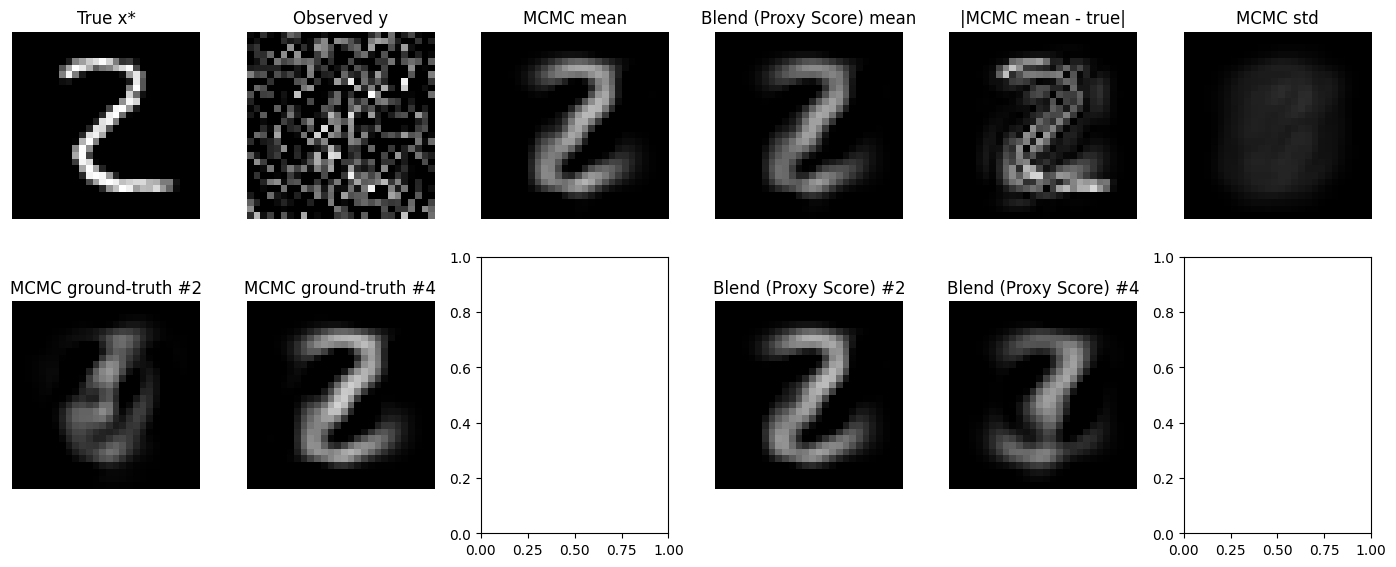

[MCMC ground-truth]    PSNR=25.99 dB, Pred=1.028, Coverage=100.0%
[Blend (Proxy Score SVD)]  PSNR=28.02 dB, Pred=1.029, Coverage=100.0%


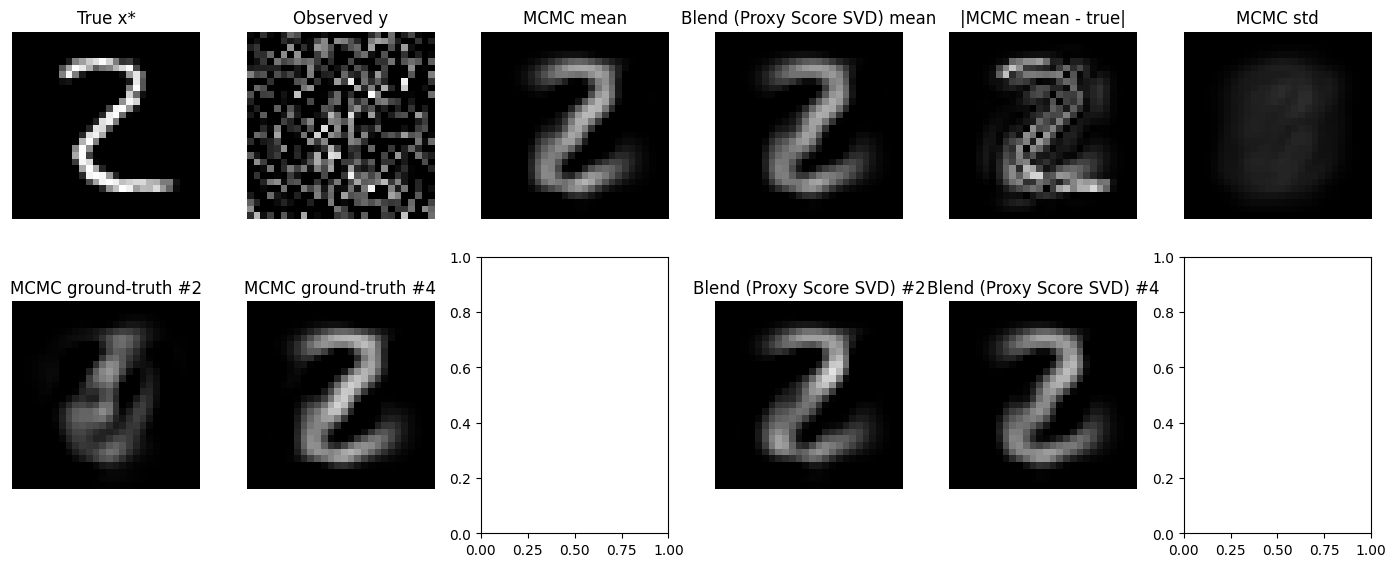

[MCMC ground-truth]    PSNR=25.99 dB, Pred=1.028, Coverage=100.0%
[Tweedie only]  PSNR=26.98 dB, Pred=1.031, Coverage=92.6%


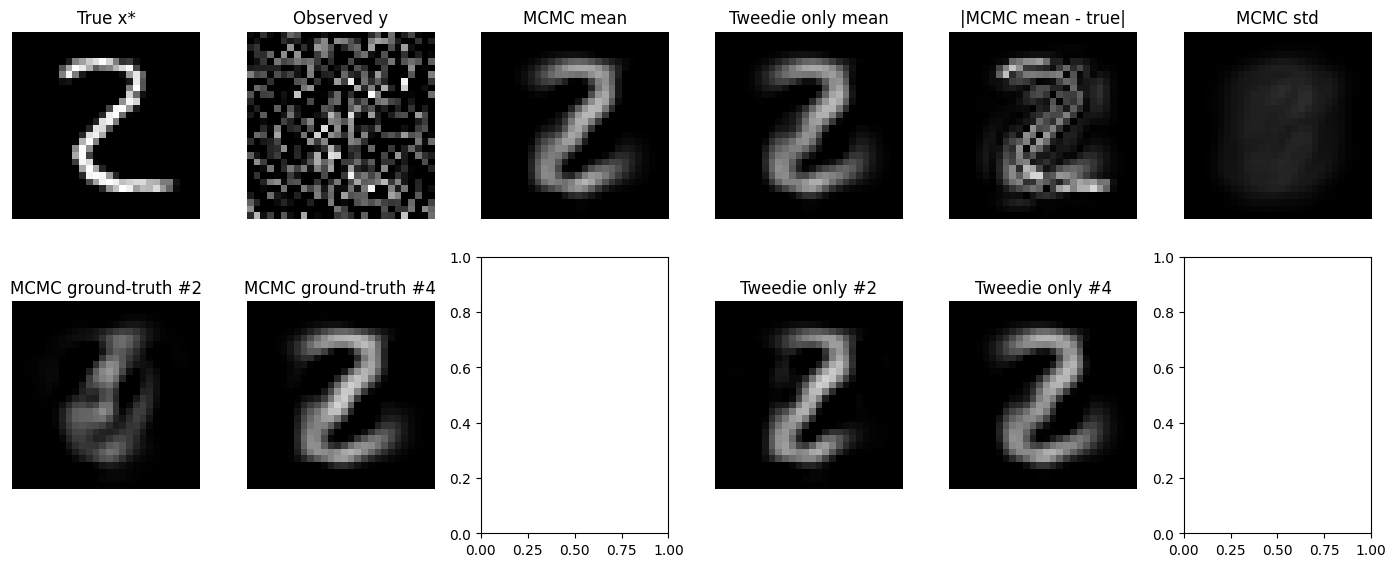

[MCMC ground-truth]    PSNR=25.99 dB, Pred=1.028, Coverage=100.0%
[Blend (Proxy Score SVD diag)]  PSNR=28.17 dB, Pred=1.029, Coverage=100.0%


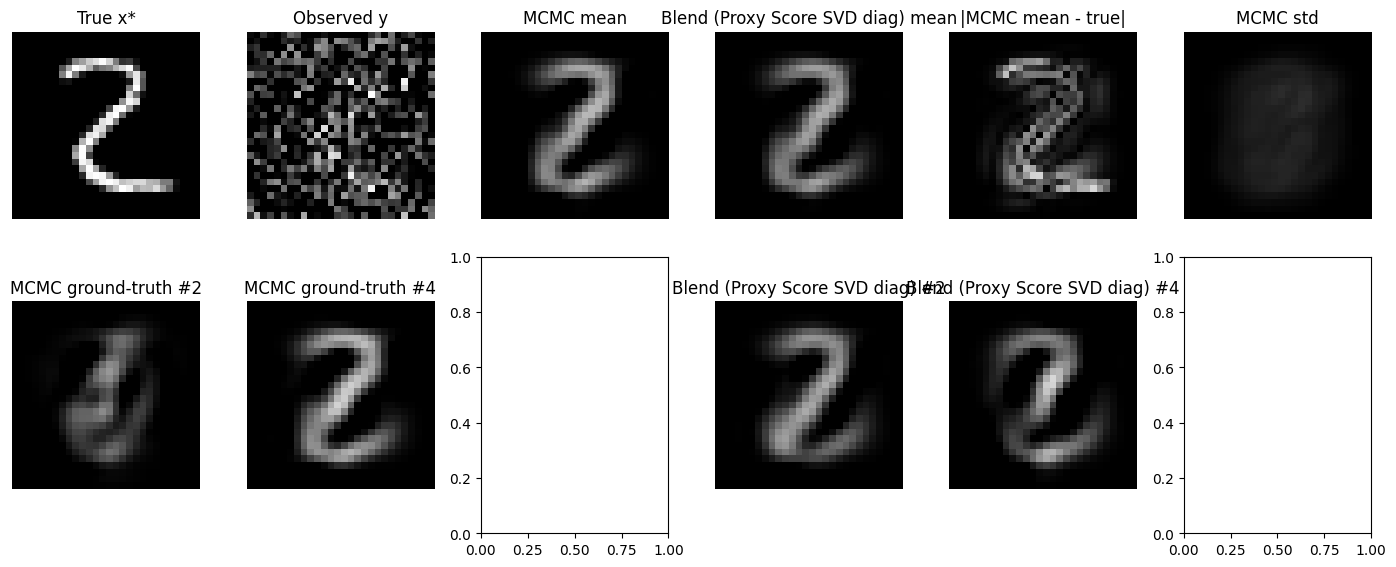

== building nonparametric references (IS posterior + KDE-MCMC) ==
[KDE-MCMC] acc=0.583, kept=2000

=== Prior Faithfulness Report (higher e_logp_kde is better; distances lower are better) ===
set                  E[loglik]  E[log p_KDE]     SW2→IS    SW2→KDE     MMD→IS
Proxy SVD Blend       -403.408       -32.653      0.233      0.636  1.086e-01
Proxy SVD Diag        -403.488       -32.633      0.234      0.639  1.082e-01
Tweedie               -404.133       -32.022      0.275      0.742  1.876e-01
Proxy Blend           -404.064       -32.597      0.339      0.530  1.070e-01
MCMC-GMM              -403.053       -33.866      0.288      0.582  1.324e-01

=== MNIST deblurring metrics (table-ready) ===
Method         | PSNR(dB) |  Cov(%) |   RMSE_a |  RMSE_amb |  FwdErr | MMD->IS
------------------------------------------------------------------------------
Blend (Proxy)  |    28.02 |   100.0 |   0.1550 |    0.0397 |  0.1152 |  0.1086
Tweedie only   |    26.98 |    92.6 |   0.1843 |    0.04

In [ ]:
gt_gmm = run_ground_truth_mcmc(
    Z_train=X_train,   # PCA coefficients (N × d) used as data prior
    aux=aux,           # carries components, mean, blur kernel, y_obs, etc.
    n_gmm=512,         # GMM components for the data prior (diag)
    chains=4,
    steps=4000,
    warmup=3000,
    seed=0,
    progress=True
)

for label in ['Blend (Proxy Score)', 'Blend (Proxy Score SVD)',
              'Tweedie only', 'Blend (Proxy Score SVD diag)']:
  compare_to_sampler(gt_gmm['samples'], results, aux, likelyhood_func, label=label)

X_cp = X_train

# 1) Collect the sets to compare (in PCA space, not images)
proxy_blend  = results['output_dict']['Blend (Proxy Score)']
proxy_svd_blend  = results['output_dict']['Blend (Proxy Score SVD)']
proxy_svd_diag  = results['output_dict']['Blend (Proxy Score SVD diag)']
tweed  = results['output_dict']['Tweedie only']
gmm_gt = gt_gmm['samples']                     # if you ran GMM-MCMC
pool   = X_cp                                   # training pool (CuPy or NumPy)


# 2) Attach the likelihood for the report
aux['likelyhood_func'] = likelyhood_func

# 3) Run the fidelity report (adds IS and KDE-MCMC internally)
report = prior_faithfulness_report(
     sets={"Proxy SVD Blend": proxy_svd_blend,
           "Proxy SVD Diag": proxy_svd_diag,
           "Tweedie": tweed,
           "Proxy Blend": proxy_blend,
           "MCMC-GMM": gmm_gt},
     aux=aux,
     pool=pool,
     kde_centers=5)
Z_is = report["Z_is"]

# 4) Optional: histogram panel against IS/KDE “gold” (you already have a function).



# ========= Compact MCMC-vs-Sampler histogram compare =========
import numpy as np
try:
    import cupy as cp
except Exception:
    cp = None

def _is_cp(a):
    return (cp is not None) and isinstance(a, cp.ndarray)

def _to_cp(a, dtype=np.float64):
    if _is_cp(a): return a.astype(dtype, copy=False)
    return cp.asarray(a, dtype=dtype) if cp is not None else a

def _to_np(a):
    if _is_cp(a): return cp.asnumpy(a)
    return np.asarray(a)

def _default_dim_pairs(d, nrows=5):
    # 1-based pairs, matching your plot_pair_histograms API
    pairs = []
    k = 0
    while 2*k+2 <= d and len(pairs) < nrows:
        pairs.append((2*k+1, 2*k+2))
        k += 1
    # fallbacks in case d is odd/small
    if not pairs and d >= 2:
        pairs = [(1,2)]
    return pairs
# --- optional: quick IS posterior from a pool of prior samples ---
def is_posterior_from_pool(X_pool, likelyhood_func, N=5000, seed=0):
    import numpy as np, cupy as cp
    Xp = cp.asarray(X_pool)
    ll = likelyhood_func(Xp)                         # (M,) cp
    m  = cp.max(ll)
    w  = cp.exp(ll - m)
    p  = (w / (cp.sum(w) + 1e-300)).astype(cp.float64)
    rs = cp.random.RandomState(seed)
    idx = rs.choice(Xp.shape[0], size=int(N), replace=True, p=cp.asnumpy(p))
    return Xp[idx]                                   # returns CuPy array (N,d)


# --- uses the new overlay-capable plotter ---------------------------


def hist_compare_mcmc_vs_samplers(
    Z_mcmc,
    results,
    aux,
    likelyhood_func,
    labels=('Blend (KSS+Tweedie)'),
    extra_cols=None,                          # other columns to show (except overlay)
    save_path="mcmc_vs_sampler_hists.png",
    nrows=2,
    bins=100,
    hist_norm=1.5,
    # --- overlay controls -------------------------------------------
    overlay_samples=None,                     # if None, try extra_cols[overlay_key]
    overlay_key='IS posterior',               # which extra_col to treat as overlay
    overlay_style='contour',                  # 'contour' | 'heatmap' | 'scatter'
    overlay_cmap='cool',
    overlay_alpha=1.0,
    overlay_mass_levels=(0.4, 0.8, .95, .99, .999),   # contour mass levels
    overlay_linewidth=1.7,
    overlay_on_prior=False,                   # draw overlay on prior column as well
    plot_prior = False,
):
    import numpy as np, cupy as cp

    out = results['output_dict']

    # -------- columns to render (MCMC + requested labels + any extra_cols) ----------
    cols = {}
    if Z_mcmc is not None:
        cols['MCMC posterior'] = cp.asarray(Z_mcmc, dtype=cp.float64)

    for lab in labels:
        if lab in out:
            cols[lab] = cp.asarray(out[lab], dtype=cp.float64)

    # Copy extra_cols so we can pop safely
    extra_cols = dict(extra_cols) if extra_cols is not None else {}

    # Overlay: prefer explicit overlay_samples; else pull from extra_cols[overlay_key]
    overlay_arr = overlay_samples
    if overlay_arr is None and overlay_key in extra_cols:
        overlay_arr = extra_cols.pop(overlay_key)

    # Add remaining extra columns (overlay removed above)
    for k, v in extra_cols.items():
        cols[k] = cp.asarray(v, dtype=cp.float64)

    # Prior column (for ranges/contours)
    prior = out.get('True prior', None)
    if prior is None:
        # fall back to first col as the range-setter
        prior = next(iter(cols.values()))
    else:
        prior = cp.asarray(prior, dtype=cp.float64)

    # Wrap likelihood for contouring (plotter expects np -> np)
    def ll_wrap(U_np):
        x_cp = cp.asarray(U_np, dtype=cp.float64)
        return cp.asnumpy(likelyhood_func(x_cp))  # returns log p(y|x)

    # -------- call the overlay-enabled plotting function ---------------------------
    plot_pair_histograms_overlay(
        y_finals_dict=cols,                 # columns to render
        prior_samples=prior,
        post_samples=None,                  # we’re not inserting a separate "Posterior" column
        save_path=save_path,
        mode='pca',
        nrows=2,
        bins=bins,
        hist_norm=hist_norm,
        post_hist_norm=1.0,                 # keep your defaults; tweak if you like
        display_mode='min_label',
        likelyhood_func=ll_wrap,
        draw_countours=False,
        prior_scale=False,
        plot_prior=plot_prior,
        plot_post=False,

        # ---- overlay forwarding ----
        overlay_samples=overlay_arr,
        overlay_style=overlay_style,
        overlay_cmap=overlay_cmap,
        overlay_alpha=overlay_alpha,
        overlay_mass_levels=overlay_mass_levels,
        overlay_linewidth=overlay_linewidth,
        overlay_on_prior=overlay_on_prior,
    )
    return save_path

hist_compare_mcmc_vs_samplers(
    Z_mcmc=gt_gmm['samples'],
    results=results,
    aux=aux,
    likelyhood_func=likelyhood_func,
    #labels= ['Blend (Proxy Score)', 'Blend (Proxy Score SVD)', 'Blend (Proxy Score SVD diag)', 'Tweedie only'],
    labels= ['Blend (Proxy Score SVD)', 'Tweedie only'],
    extra_cols={'IS posterior': report['Z_is']},  # <- goes to overlay automatically
    save_path="mcmc_vs_sampler_overlay.png",
    overlay_style='contour',       # or 'contour' / 'heatmap'
    plot_prior = False,
    overlay_on_prior=False,
    overlay_alpha = 0.6,
    bins = 100,
    hist_norm=1.0,
)


sets_for_table = {
    "Blend (Proxy)": results['output_dict']['Blend (Proxy Score SVD)'],
    "Tweedie only":  results['output_dict']['Tweedie only'],
    "MCMC--GMM":     gt_gmm['samples'],
}

rows = {}
for name, Z in sets_for_table.items():
    rows[name] = metrics_block(
        Z, name, aux, likelyhood_func,
        project_truth=True,     # <-- IMPORTANT: ensures ambient comparisons use projected truth
        Z_ref_is=Z_is
    )

# MMD->IS (keep same convention you used before)
mmd_to_is = {name: float(mmd_rbf(to_np(Z), to_np(Z_is), sigma=1.0))
             for name, Z in sets_for_table.items()}

print("\n=== MNIST deblurring metrics (table-ready) ===")
hdr = (
    f"{'Method':<14} | {'PSNR(dB)':>8} | {'Cov(%)':>7} | "
    f"{'RMSE_a':>8} | {'RMSE_amb':>9} | {'FwdErr':>7} | {'MMD->IS':>7}"
)
print(hdr)
print("-" * len(hdr))

for name in ["Blend (Proxy)", "Tweedie only", "MCMC--GMM"]:
    r = rows[name]
    print(
        f"{name:<14} | "
        f"{r['psnr']:8.2f} | {100*r['cover']:7.1f} | "
        f"{r['rmse_alpha']:8.4f} | {r['rmse_amb']:9.4f} | "
        f"{r['fwd_err']:7.4f} | {mmd_to_is[name]:7.4f}"
    )



In [ ]:
def make_mnist_recon_panel_clean(
    results,
    aux,
    likelyhood_func,
    *,
    Z_mcmc=None,                        # pass gt_gmm['samples'] if you have it
    save_path="Paper/Paper_Figures/mnist_recon_panel.png",
    n_show=5,
    seed=0,
    include_proxy_blend_samples=True,   # show Blend (Proxy Score) samples row
    include_proxy_svd_samples=True,     # show Blend (Proxy Score SVD) samples row
    include_tweedie_samples=True,       # show Tweedie-only samples row
    include_is_samples=True,
    include_mcmc_samples=True,
    project_truth=True,                 # compare means to PCA-projected truth
):
    """
    Minimal MNIST deblur panel:
      Top: True, Observed, Mean(Proxy Blend), Mean(Proxy SVD), Mean(Tweedie),
           Mean(IS), [Mean(MCMC-GMM)]
      Next rows (optional): Proxy Blend x5, Proxy SVD x5, Tweedie x5, IS x5, [MCMC-GMM x5]
    Relies on helpers present in your run: decode_imgs, build_is_posterior,
    project_to_pca_subspace.
    """
    import os, numpy as np, matplotlib.pyplot as plt
    rng = np.random.default_rng(seed)

    def _to_np(a):
        try:
            import cupy as _cp
            if isinstance(a, _cp.ndarray):
                return _cp.asnumpy(a)
        except Exception:
            pass
        return np.asarray(a)

    # --- pull common bits ---
    C, mu   = aux["components"], aux["mean_flat"]
    x_true  = aux["x_true"]
    y_obs   = aux["y_obs"]

    # truth reference (optionally projected to PCA span)
    if project_truth:
        _, x_ref = project_to_pca_subspace(x_true, C, mu)
    else:
        x_ref = x_true

    # Helper to fetch (imgs, mean) for a label if present
    def _imgs_and_mean(label):
        if label in results["output_dict"]:
            X = results["output_dict"][label]
            imgs = decode_imgs(X, C, mu)
            return imgs, imgs.mean(axis=0)
        return None, None

    # --- posterior variants ---
    # 1) Proxy Blend
    imgs_proxy, mean_proxy = _imgs_and_mean("Blend (Proxy Score)")
    # 2) Proxy SVD Blend
    imgs_proxy_svd, mean_proxy_svd = _imgs_and_mean("Blend (Proxy Score SVD)")
    # 3) Tweedie-only
    imgs_tweed, mean_tweed = _imgs_and_mean("Tweedie only")

    # IS posterior from the training pool
    Z_pool = results["output_dict"].get("True prior", None)
    if Z_pool is None:
        raise RuntimeError("need results['output_dict']['True prior'] to build IS posterior")
    Z_is   = build_is_posterior(Z_pool, likelyhood_func, n_draws=max(2000, 5*n_show), seed=seed)
    imgs_is = decode_imgs(Z_is, C, mu)
    mean_is = imgs_is.mean(axis=0)

    # MCMC–GMM “ground truth” (if provided)
    have_mcmc = Z_mcmc is not None
    if have_mcmc:
        imgs_mcmc = decode_imgs(Z_mcmc, C, mu)
        mean_mcmc = imgs_mcmc.mean(axis=0)

    # ---- set up figure grid ----
    # Top row (ordered): True, Observed, Means for each available method
    top_panels = [
        (x_ref,               "True x* (proj)" if project_truth else "True x*"),
        (y_obs,               "Observed y (blur+noise)"),
    ]
    if mean_proxy is not None:
        top_panels.append((mean_proxy,      "Mean: Proxy Blend"))
    #if mean_proxy_svd is not None:
    #    top_panels.append((mean_proxy_svd,  "Mean: Proxy SVD"))
    if mean_tweed is not None:
        top_panels.append((mean_tweed,      "Mean: Tweedie"))
   # top_panels.append((mean_is,             "Mean: IS"))
    if have_mcmc:
        top_panels.append((mean_mcmc,       "Mean: MCMC–GMM"))

    # Sample rows (ordered): Proxy Blend, Proxy SVD, Tweedie, IS, [MCMC]
    sample_rows = []
    if include_proxy_blend_samples and (imgs_proxy is not None):
        sample_rows.append(("Proxy Blend", imgs_proxy))
    if include_proxy_svd_samples and (imgs_proxy_svd is not None):
        sample_rows.append(("Proxy SVD", imgs_proxy_svd))
    if include_tweedie_samples and (imgs_tweed is not None):
        sample_rows.append(("Tweedie", imgs_tweed))
    if include_is_samples:
        sample_rows.append(("IS", imgs_is))
    if include_mcmc_samples and have_mcmc:
        sample_rows.append(("MCMC–GMM", imgs_mcmc))

    n_cols = len(top_panels)
    n_rows = 1 + len(sample_rows)
    os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)

    def _im(ax, a, title=None, cmap="gray"):
        ax.imshow(np.clip(a, 0, 1), cmap=cmap, vmin=0, vmax=1)
        if title: ax.set_title(title, fontsize=16)
        ax.axis("off")

    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3.0*n_cols, 3.0*n_rows), squeeze=False)

    # Row 1: top_panels
    for j, (img, title) in enumerate(top_panels):
        _im(axs[0, j], img, title)

    # Subsequent rows: samples
    for r, (name, imgs) in enumerate(sample_rows, start=1):
        idx = rng.choice(imgs.shape[0], size=min(n_show, imgs.shape[0]), replace=False)
        # fill left-to-right; if fewer than n_cols samples, we just fill what we have
        for j, ii in enumerate(idx[:n_cols]):
            _im(axs[r, j], imgs[ii], f"{name} #{j+1}")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close(fig)
    return save_path



_ = make_mnist_recon_panel_clean(
    results=results,
    aux=aux,
    likelyhood_func=likelyhood_func,
    Z_mcmc=gt_gmm['samples'],
    save_path="mnist_recon_panel_all.png",
    n_show=5,
    seed=1,
    include_proxy_blend_samples=True,
    include_proxy_svd_samples=False,
    include_tweedie_samples=True,
    include_is_samples=False,
    include_mcmc_samples=True,
    project_truth=True
)
print("Saved panel to mnist_recon_panel_all.png")

